In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from dataTransformation import labels4clients, distribute_data_labels4clients, distribute_data_per_client_edited
from gan_model import Discriminator, Generator, initialize_weights
from network import Server, Worker
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from utils import Logger
from fid_score import *
from inception import *
import math

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True

In [4]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [5]:
NUM_WORKERS = 2
CLASSES_PER_USER = 2
WORKER_OVERRIDE = True # overrides other workers weights with the chosen worker
NUM_EPOCHS = 200
BATCH_SIZE = 16

LEARNING_RATE_D = 2e-4
LEARNING_RATE_G = 2e-4
B1 = 0.5
B2 = 0.999

NOISE_DIM = 128
FID_BATCH_SIZE = 20
NUM_UNIQUE_USERS = NUM_WORKERS

In [6]:
limit_classes = True
Discriminator_trainig_iterations = 1
chosen_strategy = 1
trainig_strategies = {0:'fed_avg', 1:'weighted_avg_most',2:'weighted_avg_least', 3:'most_forgiving', 4:'least_forgiving'}
trainig_strategies = trainig_strategies[chosen_strategy]

In [7]:
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# trans_cifar = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root='./datasets/cifar/', train=True, download=True, transform=trans_cifar)
dataset_test = datasets.CIFAR10(root='./datasets/cifar/', train=False, download=True, transform=trans_cifar)
dataloader_one = torch.utils.data.DataLoader(dataset, shuffle = True,batch_size=BATCH_SIZE)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle = True,batch_size=10000)

MAX_WORKER_SAMPLE = len(dataset)/NUM_WORKERS

Files already downloaded and verified
Files already downloaded and verified


In [8]:
num_classes = 10


dictionary = labels4clients(num_classes,CLASSES_PER_USER,NUM_WORKERS,NUM_UNIQUE_USERS,random_seed=False)

if limit_classes:
    worker1_classes = []
    worker1_classes.append(dataset.class_to_idx['truck'])
    worker1_classes.append(dataset.class_to_idx['automobile'])
    print(worker1_classes)

    worker2_classes = []
    worker2_classes.append(dataset.class_to_idx['dog'])
    worker2_classes.append(dataset.class_to_idx['cat'])
    print(worker2_classes)

    dictionary = {}
    for i in worker1_classes:
        if i in dictionary:
            dictionary[i].append(0)
        else:
            dictionary[i]= [0]
    for i in worker2_classes:
        if i in dictionary:
            dictionary[i].append(1)
        else:
            dictionary[i]= [1]

print(dictionary)

[9, 1]
[5, 3]
{9: [0], 1: [0], 5: [1], 3: [1]}


In [9]:
for img in dataloader_test:
    test_imgs=img[0].to(dev)

In [10]:
# print(dataset.data[0])
# print(dataset.transforms(dataset.data[0],transforms.ToTensor()))
# print(dataset.transforms(dataset.data[0],trans_cifar))

transformed shape: (3, 32, 32)


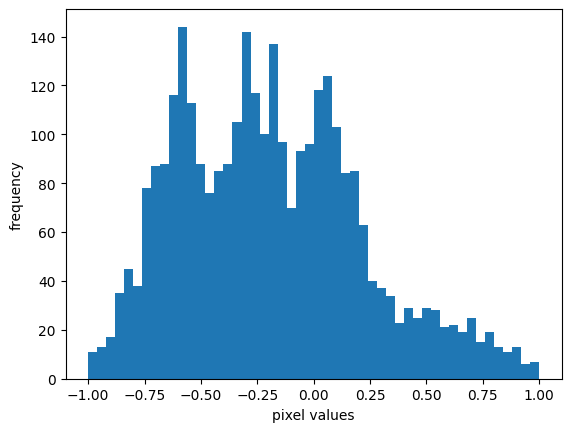

In [11]:
transformed = trans_cifar(dataset.data[0]).cpu().detach().numpy()
print("transformed shape:", transformed.shape)
plt.figure('normalized data')
plt.hist(transformed.ravel(), bins=50, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [12]:
# print(dataset.data.shape)
# print(type(dataset))
# print(dataloader_one.dataset.data.shape)
# x,_ = dataloader_one.dataset[0]
# print(x.shape)
# print(x)

In [13]:
x_train_normalized_np = np.empty((dataset.data.shape[0],dataset.data.shape[3],dataset.data.shape[1],dataset.data.shape[2]))
print("train datatset shape:",x_train_normalized_np.shape)
for i in range(len(dataset)):
    x_train_normalized_np[i] = trans_cifar(dataset.data[i])

train datatset shape: (50000, 3, 32, 32)


In [14]:
x_train_normalized_np[0][0].shape

(32, 32)

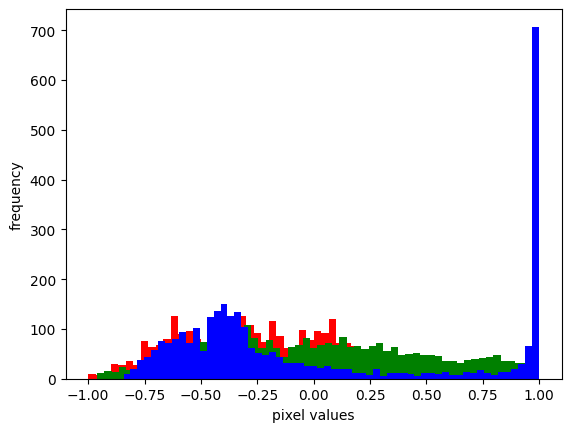

In [15]:
plt.figure('normalized data')
bin_size = 60
plt.hist(x_train_normalized_np[:][0].ravel(),color='r', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][1].ravel(),color='g', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][2].ravel(),color='b', bins=bin_size, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [16]:
# x_train = np.asarray(dataset.data)
y_train = np.asarray(dataset.targets)
x_client_list, y_client_list = distribute_data_per_client_edited(x_train_normalized_np,y_train,dictionary,CLASSES_PER_USER,random_seed = False, max_samples_per_client = MAX_WORKER_SAMPLE)

In [17]:
for i, x in enumerate(x_client_list):
    print(f'worker#{i} data count: {len(x)}')

worker#0 data count: 10000
worker#1 data count: 10000


In [18]:
# def getDist(y,class_list,user_num):
#     ax = sns.countplot(x=y)
#     ax.set(title="Count of data classes for %s" %user_num)
#     plt.show()

In [19]:
def getDist(y,class_list,user_num):
    ax = sns.barplot(x=class_list,y=y)
    ax.set(title="Count of data classes for %s" %user_num)
    plt.show()

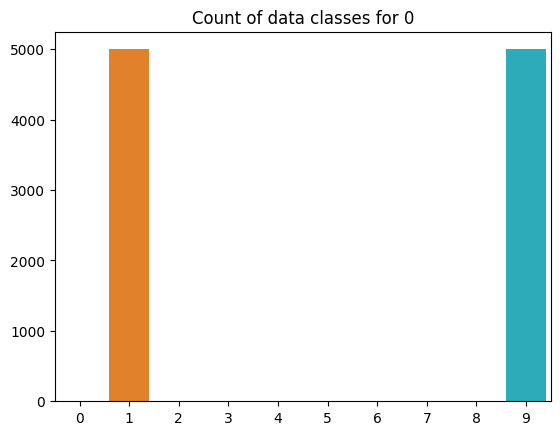

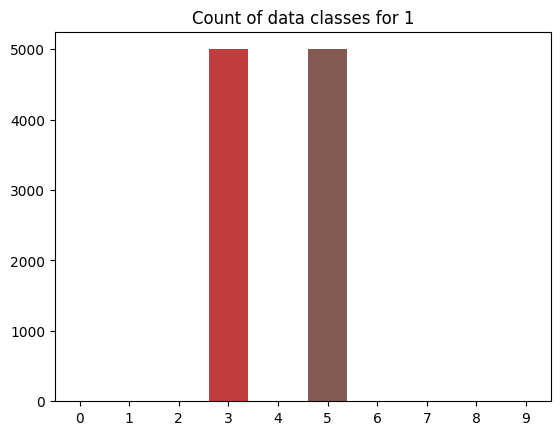

total used data 20000


In [20]:
total_data = 0
class_list = [i for i in range(num_classes)]
for i in range (len(x_client_list)):
    length = len(y_client_list[i])
    total_data+= length
    y_list = np.bincount(y_client_list[i],minlength=num_classes)
    getDist(y_list,class_list,i)
print("total used data", total_data)

In [21]:
fic_model = InceptionV3().to(dev)

In [22]:
main_server = Server(0,LEARNING_RATE_G,B1,B2,dev)
# initialize_weights(main_server.generator)
# initialize_weights(main_server.global_disc)
main_server.generator.train()
main_server.global_disc.train()
workers = []
workers_weights= []
copy_workers = False
for i in range(NUM_WORKERS):
    worker = Worker(i,LEARNING_RATE_D,B1,B2,dev)
    # x_clinet_list[i] = np.transpose(x_clinet_list[i],(0, 3, 1, 2))
    if copy_workers:
        worker.load_worker_data(x_client_list[0], y_client_list[0])
    else:
        worker.load_worker_data(x_client_list[i], y_client_list[i]) 
    # initialize_weights(worker.discriminator)
    worker.discriminator.train()
    workers.append(worker)
    workers_weights.append(worker.discriminator.state_dict())
    
# summary(main_server.generator,(128,1,1))
# summary(workers[0].discriminator,(3,32,32))

In [23]:
# # code to make all the workers the same
# workers_weights= []
# for worker in workers:
#     worker.discriminator = workers[-1].discriminator
#     workers_weights.append(worker.discriminator.state_dict())

In [24]:
criterion = nn.MSELoss()
fixed_noise = torch.randn(36, NOISE_DIM, 1, 1).to(dev) # to use for generating output images

worker_loaders = []

for worker in workers:
    # print(worker.x_data.shape)
    worker_loaders.append([])
    for batch_id, real in enumerate(DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE)):
        worker_loaders[-1].append(real)

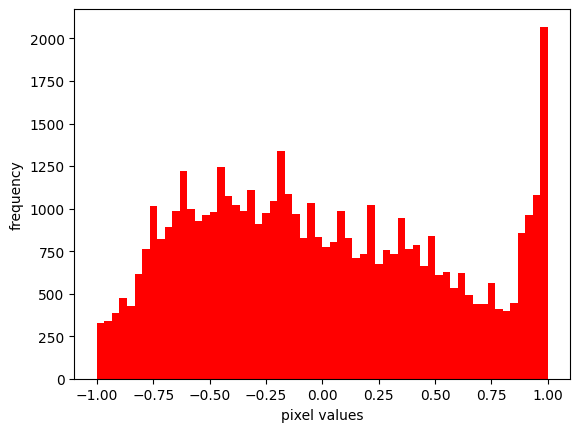

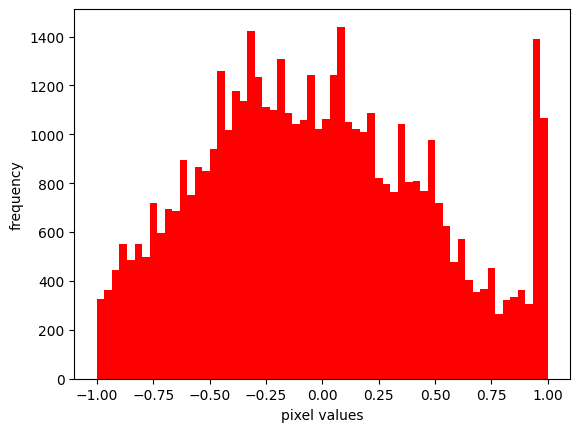

In [25]:
for worker in worker_loaders:
    plt.figure('normalized data')
    plt.hist(worker[:][1].ravel(),color='r', bins=bin_size, density=False)
    # plt.hist(x_train_normalized_np[:][1].ravel(),color='g', bins=bin_size, density=False)
    # plt.hist(x_train_normalized_np[:][2].ravel(),color='b', bins=bin_size, density=False)
    plt.xlabel("pixel values")
    plt.ylabel("frequency")
    plt.show()

In [26]:
logger = Logger(model_name='F2U',data_name='CIFAR10')
param_list = ["NUM_WORKERS", "CLASSES_PER_USER", "NUM_EPOCHS", "BATCH_SIZE",
"Discriminator_trainig_iterations","LEARNING_RATE_D", "LEARNING_RATE_G", "trainig_strategies", "WORKER_OVERRIDE","limit_classes"]
global_params = list(globals().items()) 
logger.log_params(param_list,global_params)

Epoch [0/200] Batch 0/625                 Loss D: 0.5046, loss G: 0.9986, FID Score: 419.3
Epoch [0/200] Batch 100/625                 Loss D: 0.0296, loss G: 0.8511, FID Score: 389.4
Epoch [0/200] Batch 200/625                 Loss D: 0.0247, loss G: 0.9211, FID Score: 442.2
Epoch [0/200] Batch 300/625                 Loss D: 0.0273, loss G: 0.6589, FID Score: 347.7
Epoch [0/200] Batch 400/625                 Loss D: 0.0836, loss G: 0.6112, FID Score: 401.8
Epoch [0/200] Batch 500/625                 Loss D: 0.1544, loss G: 0.4429, FID Score: 368.2
Epoch [0/200] Batch 600/625                 Loss D: 0.1099, loss G: 0.6928, FID Score: 331.5
Epoch [1/200] Batch 0/625                 Loss D: 0.1756, loss G: 0.3537, FID Score: 304.2
Epoch [1/200] Batch 100/625                 Loss D: 0.1518, loss G: 0.6389, FID Score: 330.4
Epoch [1/200] Batch 200/625                 Loss D: 0.1929, loss G: 1.0762, FID Score: 337.0
Epoch [1/200] Batch 300/625                 Loss D: 0.1885, loss G: 1.6799

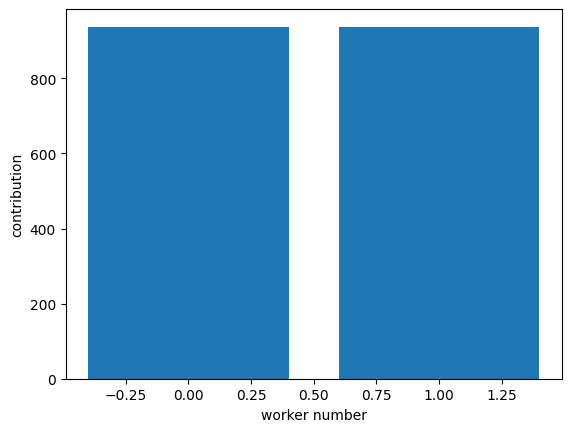

Epoch [3/200] Batch 0/625                 Loss D: 0.2133, loss G: 0.8522, FID Score: 246.0
Epoch [3/200] Batch 100/625                 Loss D: 0.1585, loss G: 0.6203, FID Score: 254.3
Epoch [3/200] Batch 200/625                 Loss D: 0.0793, loss G: 0.7167, FID Score: 243.1
Epoch [3/200] Batch 300/625                 Loss D: 0.1355, loss G: 0.7711, FID Score: 238.5
Epoch [3/200] Batch 400/625                 Loss D: 0.0959, loss G: 0.5994, FID Score: 247.8
Epoch [3/200] Batch 500/625                 Loss D: 0.3022, loss G: 0.7236, FID Score: 257.6
Epoch [3/200] Batch 600/625                 Loss D: 0.1177, loss G: 0.5865, FID Score: 246.5
Epoch [4/200] Batch 0/625                 Loss D: 0.1770, loss G: 0.9697, FID Score: 232.1
Epoch [4/200] Batch 100/625                 Loss D: 0.1454, loss G: 0.6022, FID Score: 268.7
Epoch [4/200] Batch 200/625                 Loss D: 0.1871, loss G: 0.6522, FID Score: 252.2
Epoch [4/200] Batch 300/625                 Loss D: 0.1342, loss G: 0.6332

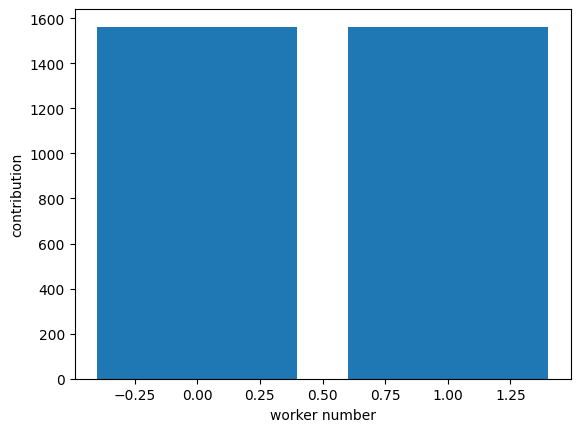

Epoch [5/200] Batch 0/625                 Loss D: 0.2205, loss G: 0.5508, FID Score: 257.7
Epoch [5/200] Batch 100/625                 Loss D: 0.1576, loss G: 0.5755, FID Score: 251.7
Epoch [5/200] Batch 200/625                 Loss D: 0.1601, loss G: 0.9602, FID Score: 252.0
Epoch [5/200] Batch 300/625                 Loss D: 0.1498, loss G: 0.6930, FID Score: 242.5
Epoch [5/200] Batch 400/625                 Loss D: 0.1629, loss G: 0.5877, FID Score: 250.9
Epoch [5/200] Batch 500/625                 Loss D: 0.1284, loss G: 0.5547, FID Score: 239.3
Epoch [5/200] Batch 600/625                 Loss D: 0.1191, loss G: 0.9140, FID Score: 231.4
Epoch [6/200] Batch 0/625                 Loss D: 0.1524, loss G: 0.6480, FID Score: 234.2
Epoch [6/200] Batch 100/625                 Loss D: 0.1118, loss G: 0.4680, FID Score: 241.6
Epoch [6/200] Batch 200/625                 Loss D: 0.1379, loss G: 0.6737, FID Score: 227.6
Epoch [6/200] Batch 300/625                 Loss D: 0.1236, loss G: 0.4518

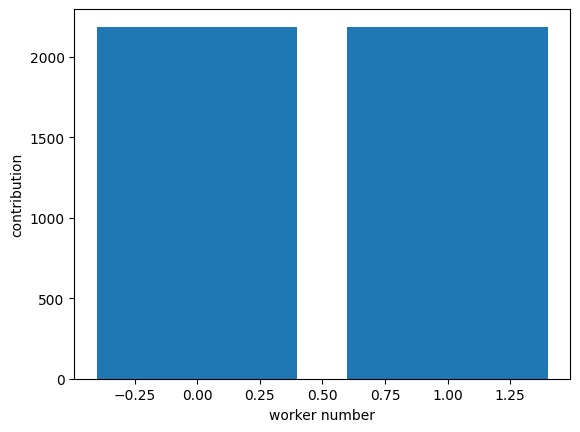

Epoch [7/200] Batch 0/625                 Loss D: 0.1281, loss G: 0.6071, FID Score: 228.3
Epoch [7/200] Batch 100/625                 Loss D: 0.1231, loss G: 0.7544, FID Score: 227.3
Epoch [7/200] Batch 200/625                 Loss D: 0.1165, loss G: 0.5554, FID Score: 238.5
Epoch [7/200] Batch 300/625                 Loss D: 0.1500, loss G: 0.4493, FID Score: 239.7
Epoch [7/200] Batch 400/625                 Loss D: 0.1387, loss G: 0.6275, FID Score: 223.1
Epoch [7/200] Batch 500/625                 Loss D: 0.2042, loss G: 0.3506, FID Score: 216.3
Epoch [7/200] Batch 600/625                 Loss D: 0.1717, loss G: 0.6335, FID Score: 244.8
Epoch [8/200] Batch 0/625                 Loss D: 0.1478, loss G: 0.8833, FID Score: 247.0
Epoch [8/200] Batch 100/625                 Loss D: 0.1322, loss G: 0.6137, FID Score: 246.0
Epoch [8/200] Batch 200/625                 Loss D: 0.1682, loss G: 0.6336, FID Score: 235.7
Epoch [8/200] Batch 300/625                 Loss D: 0.1499, loss G: 0.4320

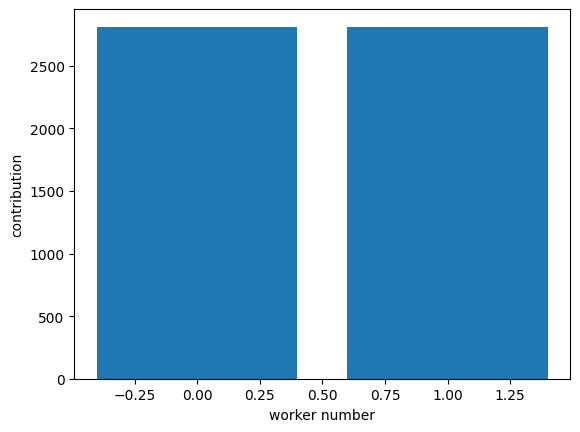

Epoch [9/200] Batch 0/625                 Loss D: 0.1748, loss G: 0.5262, FID Score: 242.7
Epoch [9/200] Batch 100/625                 Loss D: 0.1315, loss G: 0.4893, FID Score: 235.1
Epoch [9/200] Batch 200/625                 Loss D: 0.1359, loss G: 0.4512, FID Score: 236.0
Epoch [9/200] Batch 300/625                 Loss D: 0.3005, loss G: 0.6048, FID Score: 239.9
Epoch [9/200] Batch 400/625                 Loss D: 0.1537, loss G: 0.5338, FID Score: 243.4
Epoch [9/200] Batch 500/625                 Loss D: 0.1769, loss G: 0.3358, FID Score: 228.5
Epoch [9/200] Batch 600/625                 Loss D: 0.1748, loss G: 0.6298, FID Score: 249.9
Epoch [10/200] Batch 0/625                 Loss D: 0.1801, loss G: 0.6641, FID Score: 238.4
Epoch [10/200] Batch 100/625                 Loss D: 0.1669, loss G: 0.5601, FID Score: 238.3
Epoch [10/200] Batch 200/625                 Loss D: 0.1575, loss G: 0.5275, FID Score: 239.3
Epoch [10/200] Batch 300/625                 Loss D: 0.1929, loss G: 0.

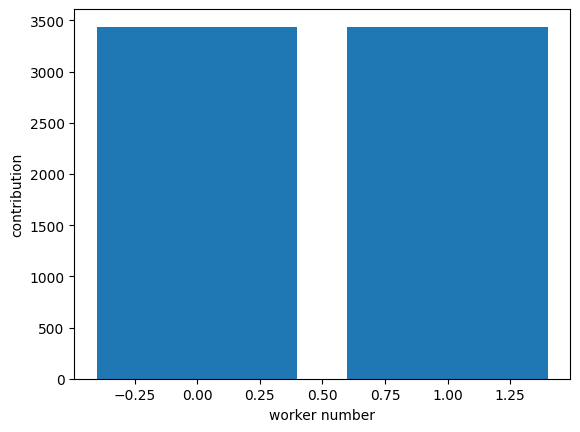

Epoch [11/200] Batch 0/625                 Loss D: 0.1989, loss G: 0.4595, FID Score: 234.0
Epoch [11/200] Batch 100/625                 Loss D: 0.2167, loss G: 0.3606, FID Score: 226.1
Epoch [11/200] Batch 200/625                 Loss D: 0.1793, loss G: 0.3830, FID Score: 261.1
Epoch [11/200] Batch 300/625                 Loss D: 0.1790, loss G: 0.2927, FID Score: 236.3
Epoch [11/200] Batch 400/625                 Loss D: 0.1588, loss G: 0.4671, FID Score: 231.9
Epoch [11/200] Batch 500/625                 Loss D: 0.2191, loss G: 0.5835, FID Score: 239.6
Epoch [11/200] Batch 600/625                 Loss D: 0.1754, loss G: 0.3688, FID Score: 240.4
Epoch [12/200] Batch 0/625                 Loss D: 0.1853, loss G: 0.4060, FID Score: 252.5
Epoch [12/200] Batch 100/625                 Loss D: 0.1666, loss G: 0.4948, FID Score: 227.9
Epoch [12/200] Batch 200/625                 Loss D: 0.1941, loss G: 0.4425, FID Score: 244.4
Epoch [12/200] Batch 300/625                 Loss D: 0.2443, los

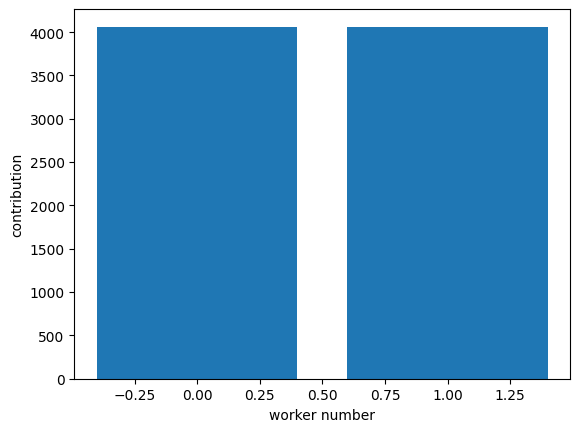

Epoch [13/200] Batch 0/625                 Loss D: 0.2391, loss G: 0.3543, FID Score: 241.5
Epoch [13/200] Batch 100/625                 Loss D: 0.1410, loss G: 0.5657, FID Score: 228.7
Epoch [13/200] Batch 200/625                 Loss D: 0.1526, loss G: 0.3142, FID Score: 222.4
Epoch [13/200] Batch 300/625                 Loss D: 0.1548, loss G: 0.4330, FID Score: 244.4
Epoch [13/200] Batch 400/625                 Loss D: 0.2332, loss G: 0.3229, FID Score: 236.6
Epoch [13/200] Batch 500/625                 Loss D: 0.2076, loss G: 0.5231, FID Score: 245.1
Epoch [13/200] Batch 600/625                 Loss D: 0.1914, loss G: 0.4238, FID Score: 235.8
Epoch [14/200] Batch 0/625                 Loss D: 0.2234, loss G: 0.6500, FID Score: 246.4
Epoch [14/200] Batch 100/625                 Loss D: 0.1776, loss G: 0.6675, FID Score: 242.4
Epoch [14/200] Batch 200/625                 Loss D: 0.1682, loss G: 0.3484, FID Score: 233.6
Epoch [14/200] Batch 300/625                 Loss D: 0.1609, los

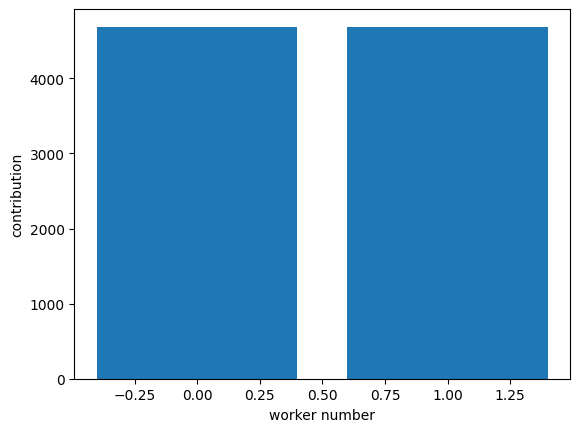

Epoch [15/200] Batch 0/625                 Loss D: 0.1955, loss G: 0.3483, FID Score: 251.6
Epoch [15/200] Batch 100/625                 Loss D: 0.1633, loss G: 0.8310, FID Score: 231.4
Epoch [15/200] Batch 200/625                 Loss D: 0.2091, loss G: 0.4454, FID Score: 244.6
Epoch [15/200] Batch 300/625                 Loss D: 0.1949, loss G: 0.5083, FID Score: 226.2
Epoch [15/200] Batch 400/625                 Loss D: 0.1535, loss G: 0.4691, FID Score: 240.2
Epoch [15/200] Batch 500/625                 Loss D: 0.2522, loss G: 0.4918, FID Score: 250.3
Epoch [15/200] Batch 600/625                 Loss D: 0.1809, loss G: 0.4405, FID Score: 234.9
Epoch [16/200] Batch 0/625                 Loss D: 0.2163, loss G: 0.3372, FID Score: 230.4
Epoch [16/200] Batch 100/625                 Loss D: 0.1587, loss G: 0.6687, FID Score: 231.5
Epoch [16/200] Batch 200/625                 Loss D: 0.1904, loss G: 0.4473, FID Score: 234.6
Epoch [16/200] Batch 300/625                 Loss D: 0.2157, los

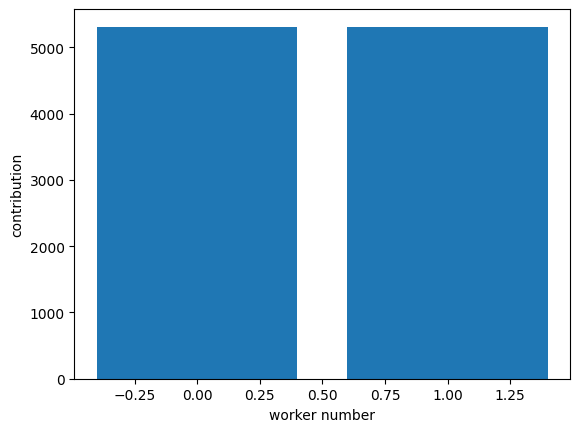

Epoch [17/200] Batch 0/625                 Loss D: 0.1871, loss G: 0.4348, FID Score: 239.0
Epoch [17/200] Batch 100/625                 Loss D: 0.1448, loss G: 0.6412, FID Score: 228.8
Epoch [17/200] Batch 200/625                 Loss D: 0.1710, loss G: 0.3511, FID Score: 230.0
Epoch [17/200] Batch 300/625                 Loss D: 0.1696, loss G: 0.4383, FID Score: 230.8
Epoch [17/200] Batch 400/625                 Loss D: 0.2152, loss G: 0.3255, FID Score: 242.9
Epoch [17/200] Batch 500/625                 Loss D: 0.2282, loss G: 0.2613, FID Score: 247.3
Epoch [17/200] Batch 600/625                 Loss D: 0.1818, loss G: 0.3755, FID Score: 225.8
Epoch [18/200] Batch 0/625                 Loss D: 0.2184, loss G: 0.5101, FID Score: 243.6
Epoch [18/200] Batch 100/625                 Loss D: 0.1905, loss G: 0.7601, FID Score: 245.6
Epoch [18/200] Batch 200/625                 Loss D: 0.1725, loss G: 0.4215, FID Score: 240.6
Epoch [18/200] Batch 300/625                 Loss D: 0.1412, los

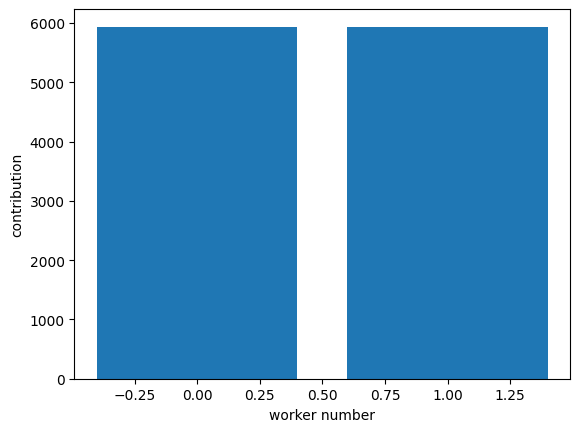

Epoch [19/200] Batch 0/625                 Loss D: 0.2533, loss G: 0.3494, FID Score: 232.1
Epoch [19/200] Batch 100/625                 Loss D: 0.2080, loss G: 0.7714, FID Score: 236.9
Epoch [19/200] Batch 200/625                 Loss D: 0.1868, loss G: 0.5268, FID Score: 230.7
Epoch [19/200] Batch 300/625                 Loss D: 0.2375, loss G: 0.3207, FID Score: 239.9
Epoch [19/200] Batch 400/625                 Loss D: 0.1664, loss G: 0.2693, FID Score: 235.1
Epoch [19/200] Batch 500/625                 Loss D: 0.2070, loss G: 0.3872, FID Score: 231.0
Epoch [19/200] Batch 600/625                 Loss D: 0.2204, loss G: 0.6209, FID Score: 232.1
Epoch [20/200] Batch 0/625                 Loss D: 0.2030, loss G: 0.4443, FID Score: 243.7
Epoch [20/200] Batch 100/625                 Loss D: 0.1482, loss G: 0.4997, FID Score: 235.4
Epoch [20/200] Batch 200/625                 Loss D: 0.1748, loss G: 0.5512, FID Score: 240.1
Epoch [20/200] Batch 300/625                 Loss D: 0.1437, los

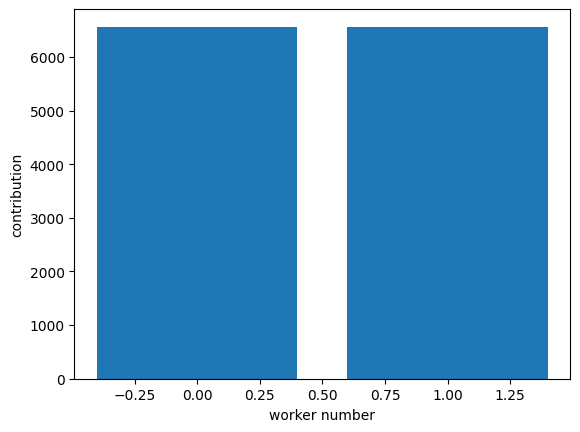

Epoch [21/200] Batch 0/625                 Loss D: 0.2217, loss G: 0.5338, FID Score: 229.3
Epoch [21/200] Batch 100/625                 Loss D: 0.1770, loss G: 0.5053, FID Score: 236.2
Epoch [21/200] Batch 200/625                 Loss D: 0.1671, loss G: 0.4441, FID Score: 225.2
Epoch [21/200] Batch 300/625                 Loss D: 0.1407, loss G: 0.3785, FID Score: 241.5
Epoch [21/200] Batch 400/625                 Loss D: 0.1777, loss G: 0.4034, FID Score: 237.2
Epoch [21/200] Batch 500/625                 Loss D: 0.2418, loss G: 0.3518, FID Score: 231.8
Epoch [21/200] Batch 600/625                 Loss D: 0.1928, loss G: 0.4068, FID Score: 229.3
Epoch [22/200] Batch 0/625                 Loss D: 0.1924, loss G: 0.4150, FID Score: 243.0
Epoch [22/200] Batch 100/625                 Loss D: 0.1942, loss G: 0.4112, FID Score: 226.3
Epoch [22/200] Batch 200/625                 Loss D: 0.1748, loss G: 0.6469, FID Score: 226.9
Epoch [22/200] Batch 300/625                 Loss D: 0.1821, los

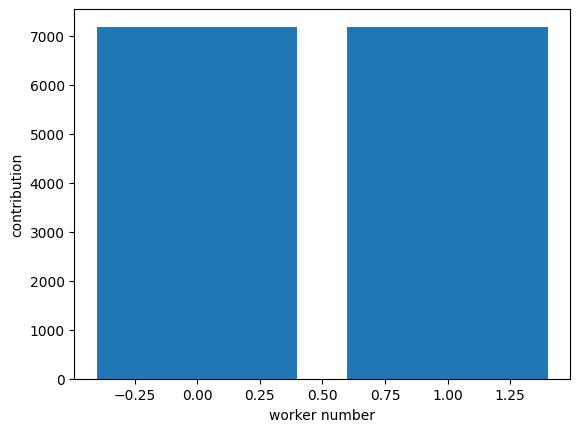

Epoch [23/200] Batch 0/625                 Loss D: 0.2859, loss G: 0.6242, FID Score: 237.3
Epoch [23/200] Batch 100/625                 Loss D: 0.2038, loss G: 0.7008, FID Score: 227.2
Epoch [23/200] Batch 200/625                 Loss D: 0.1797, loss G: 0.3550, FID Score: 245.1
Epoch [23/200] Batch 300/625                 Loss D: 0.1858, loss G: 0.5169, FID Score: 237.8
Epoch [23/200] Batch 400/625                 Loss D: 0.1842, loss G: 0.7068, FID Score: 238.7
Epoch [23/200] Batch 500/625                 Loss D: 0.2755, loss G: 0.4240, FID Score: 229.3
Epoch [23/200] Batch 600/625                 Loss D: 0.2124, loss G: 0.4524, FID Score: 232.2
Epoch [24/200] Batch 0/625                 Loss D: 0.2423, loss G: 0.4170, FID Score: 222.5
Epoch [24/200] Batch 100/625                 Loss D: 0.1821, loss G: 0.4841, FID Score: 231.0
Epoch [24/200] Batch 200/625                 Loss D: 0.1951, loss G: 0.4604, FID Score: 239.1
Epoch [24/200] Batch 300/625                 Loss D: 0.1680, los

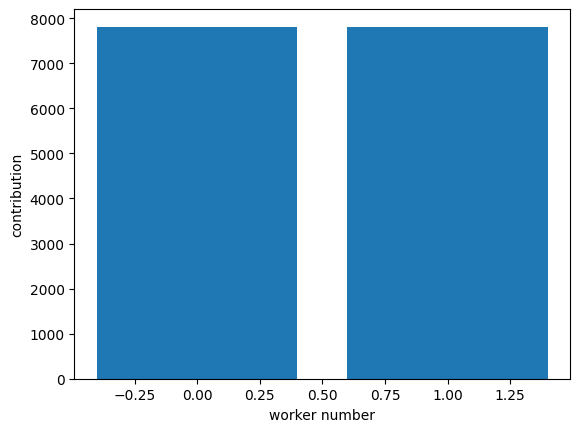

Epoch [25/200] Batch 0/625                 Loss D: 0.2384, loss G: 0.2919, FID Score: 241.6
Epoch [25/200] Batch 100/625                 Loss D: 0.1820, loss G: 0.4362, FID Score: 223.8
Epoch [25/200] Batch 200/625                 Loss D: 0.1998, loss G: 0.4576, FID Score: 235.9
Epoch [25/200] Batch 300/625                 Loss D: 0.1418, loss G: 0.4332, FID Score: 231.6
Epoch [25/200] Batch 400/625                 Loss D: 0.1762, loss G: 0.2789, FID Score: 259.7
Epoch [25/200] Batch 500/625                 Loss D: 0.2394, loss G: 0.2625, FID Score: 243.3
Epoch [25/200] Batch 600/625                 Loss D: 0.2256, loss G: 0.3282, FID Score: 224.4
Epoch [26/200] Batch 0/625                 Loss D: 0.1975, loss G: 0.4533, FID Score: 243.9
Epoch [26/200] Batch 100/625                 Loss D: 0.1700, loss G: 0.3461, FID Score: 251.2
Epoch [26/200] Batch 200/625                 Loss D: 0.2089, loss G: 0.6074, FID Score: 240.7
Epoch [26/200] Batch 300/625                 Loss D: 0.1914, los

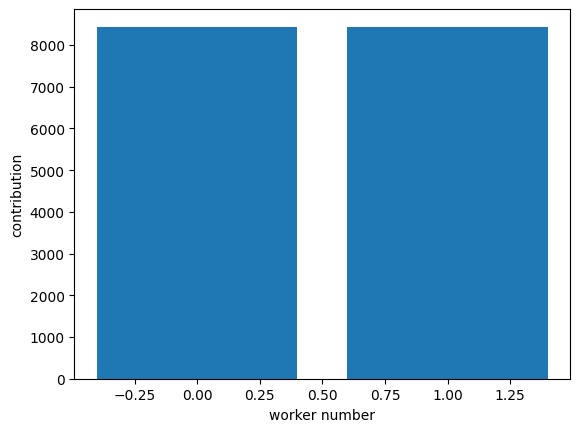

Epoch [27/200] Batch 0/625                 Loss D: 0.2285, loss G: 0.3498, FID Score: 234.4
Epoch [27/200] Batch 100/625                 Loss D: 0.1670, loss G: 0.2421, FID Score: 225.1
Epoch [27/200] Batch 200/625                 Loss D: 0.2201, loss G: 0.5121, FID Score: 237.3
Epoch [27/200] Batch 300/625                 Loss D: 0.1515, loss G: 0.4426, FID Score: 226.2
Epoch [27/200] Batch 400/625                 Loss D: 0.1964, loss G: 0.2868, FID Score: 230.9
Epoch [27/200] Batch 500/625                 Loss D: 0.2562, loss G: 0.5273, FID Score: 229.2
Epoch [27/200] Batch 600/625                 Loss D: 0.2093, loss G: 0.4372, FID Score: 227.1
Epoch [28/200] Batch 0/625                 Loss D: 0.2406, loss G: 0.4068, FID Score: 219.9
Epoch [28/200] Batch 100/625                 Loss D: 0.1760, loss G: 0.4797, FID Score: 247.8
Epoch [28/200] Batch 200/625                 Loss D: 0.2199, loss G: 0.6440, FID Score: 227.9
Epoch [28/200] Batch 300/625                 Loss D: 0.1739, los

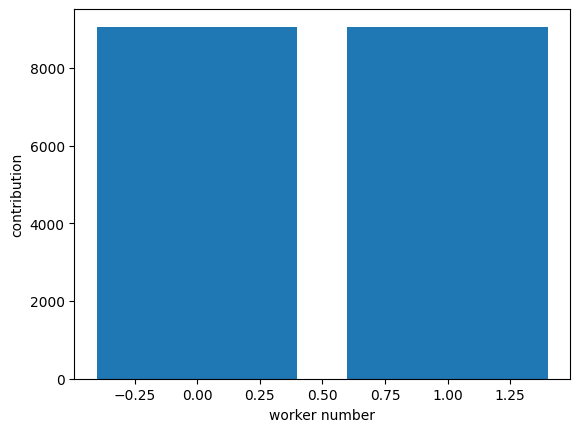

Epoch [29/200] Batch 0/625                 Loss D: 0.2055, loss G: 0.4276, FID Score: 228.5
Epoch [29/200] Batch 100/625                 Loss D: 0.2191, loss G: 0.2731, FID Score: 239.5
Epoch [29/200] Batch 200/625                 Loss D: 0.2248, loss G: 0.4209, FID Score: 240.6
Epoch [29/200] Batch 300/625                 Loss D: 0.1787, loss G: 0.6427, FID Score: 234.2
Epoch [29/200] Batch 400/625                 Loss D: 0.1906, loss G: 0.4302, FID Score: 242.0
Epoch [29/200] Batch 500/625                 Loss D: 0.2741, loss G: 0.5015, FID Score: 226.4
Epoch [29/200] Batch 600/625                 Loss D: 0.2022, loss G: 0.5231, FID Score: 253.9
Epoch [30/200] Batch 0/625                 Loss D: 0.2497, loss G: 0.4282, FID Score: 249.5
Epoch [30/200] Batch 100/625                 Loss D: 0.1520, loss G: 0.3246, FID Score: 219.7
Epoch [30/200] Batch 200/625                 Loss D: 0.1883, loss G: 0.5402, FID Score: 235.7
Epoch [30/200] Batch 300/625                 Loss D: 0.1497, los

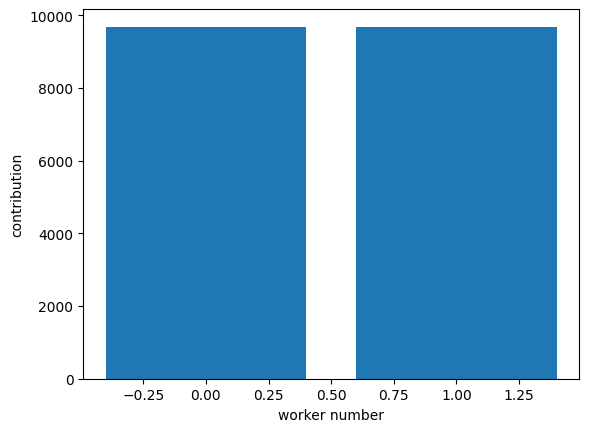

Epoch [31/200] Batch 0/625                 Loss D: 0.1940, loss G: 0.5048, FID Score: 248.8
Epoch [31/200] Batch 100/625                 Loss D: 0.1967, loss G: 0.4501, FID Score: 222.1
Epoch [31/200] Batch 200/625                 Loss D: 0.1724, loss G: 0.3342, FID Score: 254.3
Epoch [31/200] Batch 300/625                 Loss D: 0.1740, loss G: 0.4592, FID Score: 237.8
Epoch [31/200] Batch 400/625                 Loss D: 0.1836, loss G: 0.4981, FID Score: 227.6
Epoch [31/200] Batch 500/625                 Loss D: 0.2287, loss G: 0.5353, FID Score: 238.0
Epoch [31/200] Batch 600/625                 Loss D: 0.2461, loss G: 0.4529, FID Score: 232.2
Epoch [32/200] Batch 0/625                 Loss D: 0.2176, loss G: 0.4189, FID Score: 242.6
Epoch [32/200] Batch 100/625                 Loss D: 0.1608, loss G: 0.5678, FID Score: 234.2
Epoch [32/200] Batch 200/625                 Loss D: 0.1872, loss G: 0.5425, FID Score: 237.5
Epoch [32/200] Batch 300/625                 Loss D: 0.1691, los

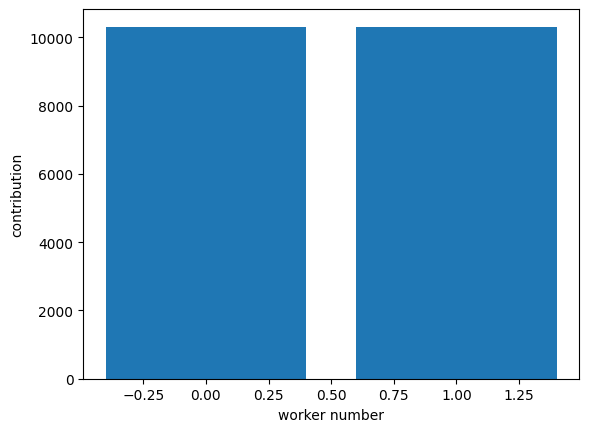

Epoch [33/200] Batch 0/625                 Loss D: 0.2300, loss G: 0.3813, FID Score: 238.6
Epoch [33/200] Batch 100/625                 Loss D: 0.2342, loss G: 0.6854, FID Score: 244.6
Epoch [33/200] Batch 200/625                 Loss D: 0.2268, loss G: 0.4218, FID Score: 237.1
Epoch [33/200] Batch 300/625                 Loss D: 0.1476, loss G: 0.3483, FID Score: 232.0
Epoch [33/200] Batch 400/625                 Loss D: 0.1972, loss G: 0.3963, FID Score: 236.2
Epoch [33/200] Batch 500/625                 Loss D: 0.2420, loss G: 0.5348, FID Score: 238.4
Epoch [33/200] Batch 600/625                 Loss D: 0.2440, loss G: 0.3780, FID Score: 231.4
Epoch [34/200] Batch 0/625                 Loss D: 0.2165, loss G: 0.3955, FID Score: 231.0
Epoch [34/200] Batch 100/625                 Loss D: 0.1799, loss G: 0.3621, FID Score: 225.3
Epoch [34/200] Batch 200/625                 Loss D: 0.1914, loss G: 0.4559, FID Score: 230.0
Epoch [34/200] Batch 300/625                 Loss D: 0.1794, los

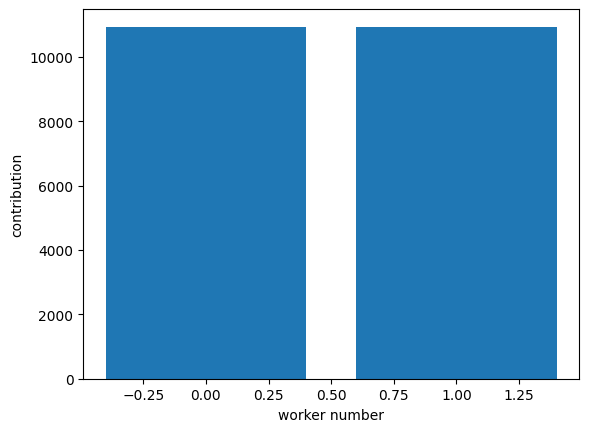

Epoch [35/200] Batch 0/625                 Loss D: 0.1920, loss G: 0.3088, FID Score: 235.4
Epoch [35/200] Batch 100/625                 Loss D: 0.1732, loss G: 0.4101, FID Score: 228.7
Epoch [35/200] Batch 200/625                 Loss D: 0.2021, loss G: 0.6386, FID Score: 234.0
Epoch [35/200] Batch 300/625                 Loss D: 0.1659, loss G: 0.4082, FID Score: 231.0
Epoch [35/200] Batch 400/625                 Loss D: 0.2025, loss G: 0.2808, FID Score: 248.5
Epoch [35/200] Batch 500/625                 Loss D: 0.2900, loss G: 0.3161, FID Score: 234.4
Epoch [35/200] Batch 600/625                 Loss D: 0.2442, loss G: 0.4568, FID Score: 258.0
Epoch [36/200] Batch 0/625                 Loss D: 0.2159, loss G: 0.5043, FID Score: 246.7
Epoch [36/200] Batch 100/625                 Loss D: 0.2155, loss G: 0.3940, FID Score: 234.0
Epoch [36/200] Batch 200/625                 Loss D: 0.1874, loss G: 0.3621, FID Score: 236.1
Epoch [36/200] Batch 300/625                 Loss D: 0.1958, los

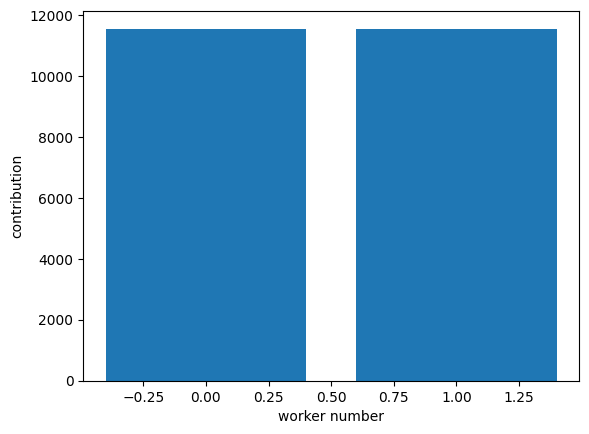

Epoch [37/200] Batch 0/625                 Loss D: 0.2482, loss G: 0.4462, FID Score: 226.5
Epoch [37/200] Batch 100/625                 Loss D: 0.1878, loss G: 0.3872, FID Score: 237.4
Epoch [37/200] Batch 200/625                 Loss D: 0.2253, loss G: 0.6309, FID Score: 242.6
Epoch [37/200] Batch 300/625                 Loss D: 0.2043, loss G: 0.3069, FID Score: 232.9
Epoch [37/200] Batch 400/625                 Loss D: 0.2068, loss G: 0.3759, FID Score: 243.4
Epoch [37/200] Batch 500/625                 Loss D: 0.2286, loss G: 0.4276, FID Score: 233.0
Epoch [37/200] Batch 600/625                 Loss D: 0.2521, loss G: 0.5250, FID Score: 238.0
Epoch [38/200] Batch 0/625                 Loss D: 0.2300, loss G: 0.3596, FID Score: 232.4
Epoch [38/200] Batch 100/625                 Loss D: 0.2052, loss G: 0.4739, FID Score: 229.8
Epoch [38/200] Batch 200/625                 Loss D: 0.2082, loss G: 0.6469, FID Score: 238.5
Epoch [38/200] Batch 300/625                 Loss D: 0.1813, los

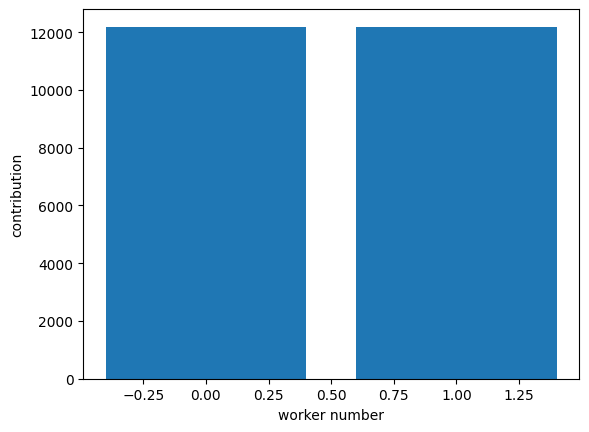

Epoch [39/200] Batch 0/625                 Loss D: 0.2343, loss G: 0.4700, FID Score: 235.4
Epoch [39/200] Batch 100/625                 Loss D: 0.2026, loss G: 0.4152, FID Score: 235.2
Epoch [39/200] Batch 200/625                 Loss D: 0.2457, loss G: 0.2900, FID Score: 229.2
Epoch [39/200] Batch 300/625                 Loss D: 0.1863, loss G: 0.2987, FID Score: 247.1
Epoch [39/200] Batch 400/625                 Loss D: 0.2046, loss G: 0.3574, FID Score: 241.0
Epoch [39/200] Batch 500/625                 Loss D: 0.2757, loss G: 0.5302, FID Score: 254.7
Epoch [39/200] Batch 600/625                 Loss D: 0.2212, loss G: 0.3193, FID Score: 238.8
Epoch [40/200] Batch 0/625                 Loss D: 0.2357, loss G: 0.3451, FID Score: 234.3
Epoch [40/200] Batch 100/625                 Loss D: 0.1960, loss G: 0.6053, FID Score: 244.6
Epoch [40/200] Batch 200/625                 Loss D: 0.2254, loss G: 0.2968, FID Score: 230.3
Epoch [40/200] Batch 300/625                 Loss D: 0.1851, los

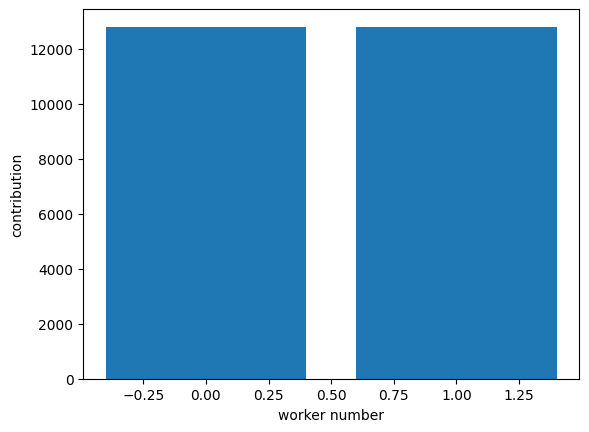

Epoch [41/200] Batch 0/625                 Loss D: 0.2270, loss G: 0.4106, FID Score: 229.0
Epoch [41/200] Batch 100/625                 Loss D: 0.1816, loss G: 0.3934, FID Score: 233.3
Epoch [41/200] Batch 200/625                 Loss D: 0.2276, loss G: 0.5183, FID Score: 239.8
Epoch [41/200] Batch 300/625                 Loss D: 0.2239, loss G: 0.2891, FID Score: 227.6
Epoch [41/200] Batch 400/625                 Loss D: 0.1733, loss G: 0.3779, FID Score: 235.6
Epoch [41/200] Batch 500/625                 Loss D: 0.2603, loss G: 0.3092, FID Score: 234.5
Epoch [41/200] Batch 600/625                 Loss D: 0.2022, loss G: 0.3100, FID Score: 249.6
Epoch [42/200] Batch 0/625                 Loss D: 0.2151, loss G: 0.4591, FID Score: 220.9
Epoch [42/200] Batch 100/625                 Loss D: 0.2240, loss G: 0.4915, FID Score: 222.2
Epoch [42/200] Batch 200/625                 Loss D: 0.2077, loss G: 0.4982, FID Score: 236.4
Epoch [42/200] Batch 300/625                 Loss D: 0.2025, los

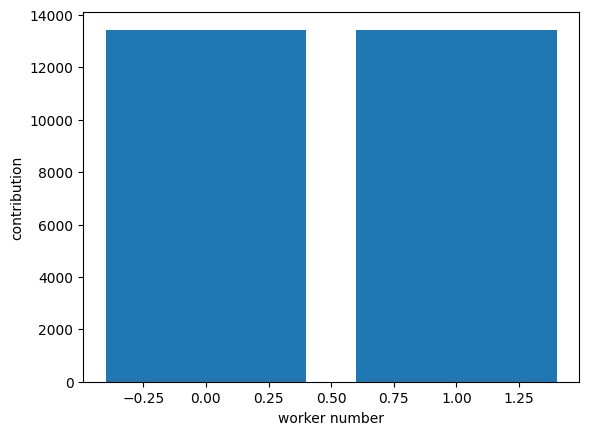

Epoch [43/200] Batch 0/625                 Loss D: 0.2297, loss G: 0.5601, FID Score: 230.0
Epoch [43/200] Batch 100/625                 Loss D: 0.1923, loss G: 0.4961, FID Score: 231.2
Epoch [43/200] Batch 200/625                 Loss D: 0.2427, loss G: 0.3242, FID Score: 244.1
Epoch [43/200] Batch 300/625                 Loss D: 0.1671, loss G: 0.2954, FID Score: 240.6
Epoch [43/200] Batch 400/625                 Loss D: 0.2133, loss G: 0.3986, FID Score: 223.6
Epoch [43/200] Batch 500/625                 Loss D: 0.2438, loss G: 0.4823, FID Score: 248.2
Epoch [43/200] Batch 600/625                 Loss D: 0.2317, loss G: 0.4350, FID Score: 229.7
Epoch [44/200] Batch 0/625                 Loss D: 0.2165, loss G: 0.3050, FID Score: 238.3
Epoch [44/200] Batch 100/625                 Loss D: 0.1948, loss G: 0.5142, FID Score: 233.8
Epoch [44/200] Batch 200/625                 Loss D: 0.2201, loss G: 0.5419, FID Score: 232.3
Epoch [44/200] Batch 300/625                 Loss D: 0.1613, los

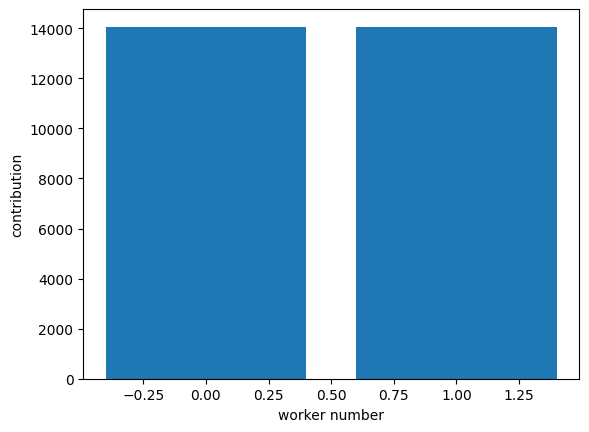

Epoch [45/200] Batch 0/625                 Loss D: 0.2283, loss G: 0.3089, FID Score: 247.5
Epoch [45/200] Batch 100/625                 Loss D: 0.1838, loss G: 0.3750, FID Score: 238.4
Epoch [45/200] Batch 200/625                 Loss D: 0.2395, loss G: 0.8149, FID Score: 238.5
Epoch [45/200] Batch 300/625                 Loss D: 0.2071, loss G: 0.4006, FID Score: 222.4
Epoch [45/200] Batch 400/625                 Loss D: 0.2115, loss G: 0.3475, FID Score: 234.0
Epoch [45/200] Batch 500/625                 Loss D: 0.2676, loss G: 0.4527, FID Score: 229.3
Epoch [45/200] Batch 600/625                 Loss D: 0.2348, loss G: 0.3311, FID Score: 228.5
Epoch [46/200] Batch 0/625                 Loss D: 0.2240, loss G: 0.3165, FID Score: 241.1
Epoch [46/200] Batch 100/625                 Loss D: 0.1888, loss G: 0.3825, FID Score: 223.8
Epoch [46/200] Batch 200/625                 Loss D: 0.2269, loss G: 0.4837, FID Score: 233.1
Epoch [46/200] Batch 300/625                 Loss D: 0.2159, los

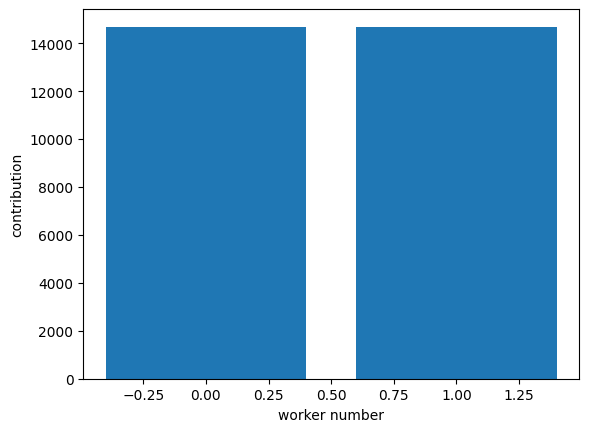

Epoch [47/200] Batch 0/625                 Loss D: 0.2663, loss G: 0.2617, FID Score: 242.5
Epoch [47/200] Batch 100/625                 Loss D: 0.2088, loss G: 0.3833, FID Score: 240.4
Epoch [47/200] Batch 200/625                 Loss D: 0.2090, loss G: 0.3858, FID Score: 243.4
Epoch [47/200] Batch 300/625                 Loss D: 0.2142, loss G: 0.2430, FID Score: 230.0
Epoch [47/200] Batch 400/625                 Loss D: 0.1897, loss G: 0.4248, FID Score: 236.9
Epoch [47/200] Batch 500/625                 Loss D: 0.2585, loss G: 0.4269, FID Score: 234.8
Epoch [47/200] Batch 600/625                 Loss D: 0.2466, loss G: 0.2281, FID Score: 234.4
Epoch [48/200] Batch 0/625                 Loss D: 0.2490, loss G: 0.2604, FID Score: 237.6
Epoch [48/200] Batch 100/625                 Loss D: 0.2442, loss G: 0.5734, FID Score: 221.5
Epoch [48/200] Batch 200/625                 Loss D: 0.2130, loss G: 0.3611, FID Score: 242.0
Epoch [48/200] Batch 300/625                 Loss D: 0.2115, los

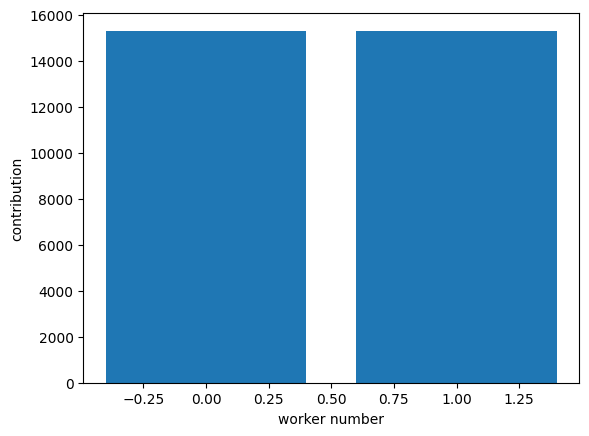

Epoch [49/200] Batch 0/625                 Loss D: 0.2396, loss G: 0.4644, FID Score: 231.9
Epoch [49/200] Batch 100/625                 Loss D: 0.2088, loss G: 0.4313, FID Score: 250.0
Epoch [49/200] Batch 200/625                 Loss D: 0.2184, loss G: 0.4777, FID Score: 228.1
Epoch [49/200] Batch 300/625                 Loss D: 0.1954, loss G: 0.3621, FID Score: 228.1
Epoch [49/200] Batch 400/625                 Loss D: 0.1935, loss G: 0.3490, FID Score: 232.9
Epoch [49/200] Batch 500/625                 Loss D: 0.2658, loss G: 0.3020, FID Score: 235.4
Epoch [49/200] Batch 600/625                 Loss D: 0.1962, loss G: 0.4221, FID Score: 222.1
Epoch [50/200] Batch 0/625                 Loss D: 0.2727, loss G: 0.6221, FID Score: 240.0
Epoch [50/200] Batch 100/625                 Loss D: 0.2238, loss G: 0.3100, FID Score: 224.2
Epoch [50/200] Batch 200/625                 Loss D: 0.2293, loss G: 0.4350, FID Score: 227.0
Epoch [50/200] Batch 300/625                 Loss D: 0.1686, los

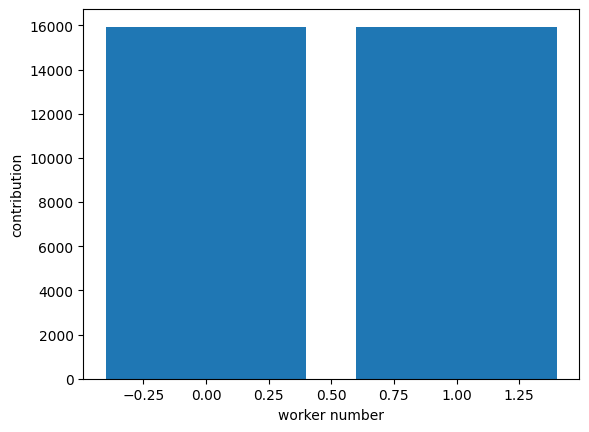

Epoch [51/200] Batch 0/625                 Loss D: 0.2329, loss G: 0.3103, FID Score: 231.0
Epoch [51/200] Batch 100/625                 Loss D: 0.2033, loss G: 0.3218, FID Score: 220.3
Epoch [51/200] Batch 200/625                 Loss D: 0.2460, loss G: 0.4682, FID Score: 231.3
Epoch [51/200] Batch 300/625                 Loss D: 0.1926, loss G: 0.2585, FID Score: 230.3
Epoch [51/200] Batch 400/625                 Loss D: 0.2264, loss G: 0.2763, FID Score: 233.8
Epoch [51/200] Batch 500/625                 Loss D: 0.2587, loss G: 0.4570, FID Score: 243.9
Epoch [51/200] Batch 600/625                 Loss D: 0.2582, loss G: 0.2318, FID Score: 250.1
Epoch [52/200] Batch 0/625                 Loss D: 0.2762, loss G: 0.6086, FID Score: 228.4
Epoch [52/200] Batch 100/625                 Loss D: 0.2345, loss G: 0.3832, FID Score: 237.1
Epoch [52/200] Batch 200/625                 Loss D: 0.2784, loss G: 0.2695, FID Score: 231.7
Epoch [52/200] Batch 300/625                 Loss D: 0.1904, los

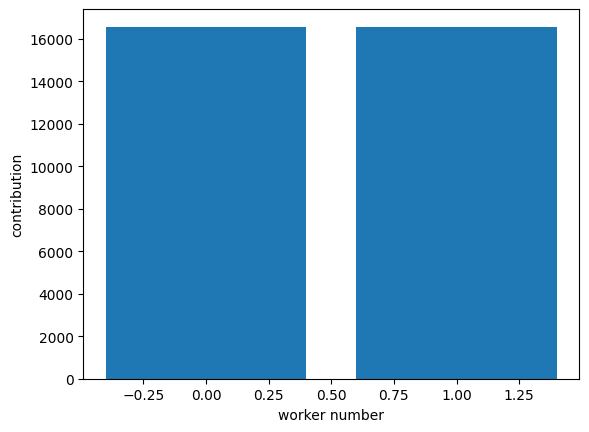

Epoch [53/200] Batch 0/625                 Loss D: 0.2247, loss G: 0.3441, FID Score: 230.0
Epoch [53/200] Batch 100/625                 Loss D: 0.2127, loss G: 0.2657, FID Score: 245.3
Epoch [53/200] Batch 200/625                 Loss D: 0.2342, loss G: 0.3303, FID Score: 230.1
Epoch [53/200] Batch 300/625                 Loss D: 0.1943, loss G: 0.4019, FID Score: 238.5
Epoch [53/200] Batch 400/625                 Loss D: 0.1996, loss G: 0.3572, FID Score: 241.2
Epoch [53/200] Batch 500/625                 Loss D: 0.2627, loss G: 0.3682, FID Score: 229.5
Epoch [53/200] Batch 600/625                 Loss D: 0.2246, loss G: 0.4803, FID Score: 246.4
Epoch [54/200] Batch 0/625                 Loss D: 0.2622, loss G: 0.2231, FID Score: 221.5
Epoch [54/200] Batch 100/625                 Loss D: 0.2276, loss G: 0.3177, FID Score: 237.0
Epoch [54/200] Batch 200/625                 Loss D: 0.2289, loss G: 0.3600, FID Score: 248.2
Epoch [54/200] Batch 300/625                 Loss D: 0.1930, los

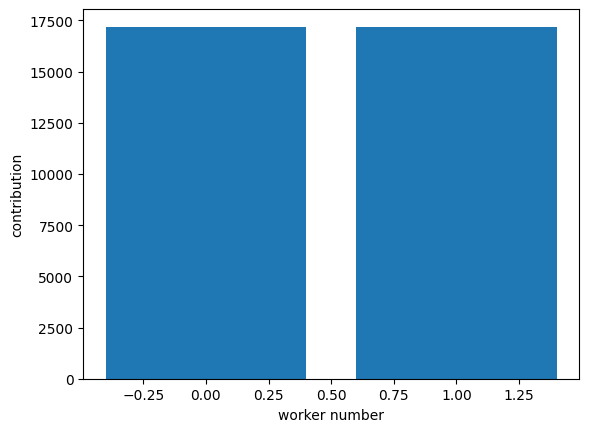

Epoch [55/200] Batch 0/625                 Loss D: 0.2553, loss G: 0.4830, FID Score: 223.3
Epoch [55/200] Batch 100/625                 Loss D: 0.2244, loss G: 0.2590, FID Score: 235.9
Epoch [55/200] Batch 200/625                 Loss D: 0.2334, loss G: 0.3796, FID Score: 237.5
Epoch [55/200] Batch 300/625                 Loss D: 0.2022, loss G: 0.3711, FID Score: 234.6
Epoch [55/200] Batch 400/625                 Loss D: 0.2405, loss G: 0.3712, FID Score: 240.2
Epoch [55/200] Batch 500/625                 Loss D: 0.2581, loss G: 0.3818, FID Score: 239.3
Epoch [55/200] Batch 600/625                 Loss D: 0.2080, loss G: 0.2493, FID Score: 246.2
Epoch [56/200] Batch 0/625                 Loss D: 0.2449, loss G: 0.3424, FID Score: 236.8
Epoch [56/200] Batch 100/625                 Loss D: 0.2328, loss G: 0.2686, FID Score: 231.1
Epoch [56/200] Batch 200/625                 Loss D: 0.2218, loss G: 0.5373, FID Score: 229.8
Epoch [56/200] Batch 300/625                 Loss D: 0.2051, los

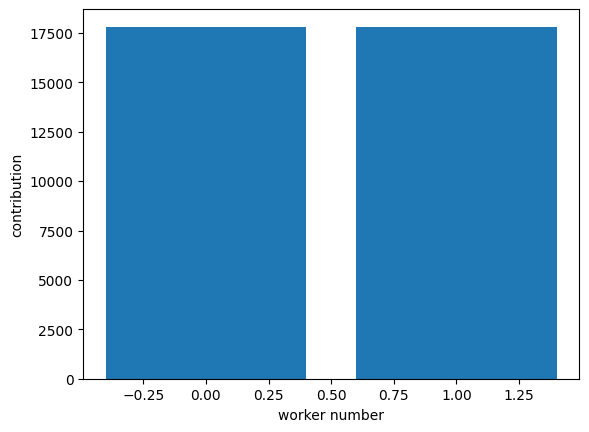

Epoch [57/200] Batch 0/625                 Loss D: 0.2647, loss G: 0.4351, FID Score: 242.5
Epoch [57/200] Batch 100/625                 Loss D: 0.2171, loss G: 0.3574, FID Score: 238.7
Epoch [57/200] Batch 200/625                 Loss D: 0.2823, loss G: 0.6155, FID Score: 239.2
Epoch [57/200] Batch 300/625                 Loss D: 0.1902, loss G: 0.3577, FID Score: 232.7
Epoch [57/200] Batch 400/625                 Loss D: 0.2293, loss G: 0.2716, FID Score: 240.2
Epoch [57/200] Batch 500/625                 Loss D: 0.2542, loss G: 0.3267, FID Score: 235.9
Epoch [57/200] Batch 600/625                 Loss D: 0.2382, loss G: 0.3717, FID Score: 232.2
Epoch [58/200] Batch 0/625                 Loss D: 0.2521, loss G: 0.3355, FID Score: 219.3
Epoch [58/200] Batch 100/625                 Loss D: 0.2169, loss G: 0.3261, FID Score: 231.2
Epoch [58/200] Batch 200/625                 Loss D: 0.2286, loss G: 0.3584, FID Score: 233.4
Epoch [58/200] Batch 300/625                 Loss D: 0.2086, los

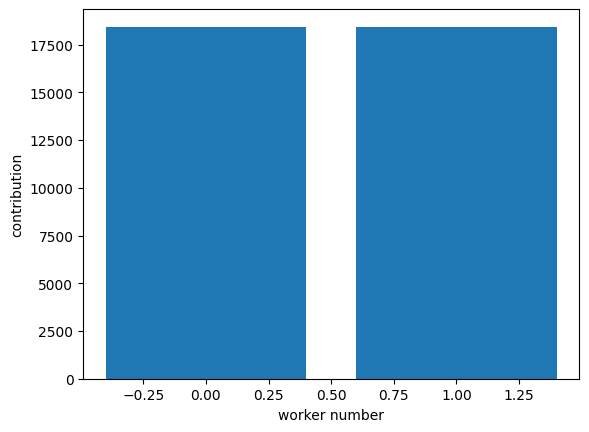

Epoch [59/200] Batch 0/625                 Loss D: 0.2578, loss G: 0.3039, FID Score: 253.6
Epoch [59/200] Batch 100/625                 Loss D: 0.2270, loss G: 0.4555, FID Score: 238.0
Epoch [59/200] Batch 200/625                 Loss D: 0.2562, loss G: 0.4573, FID Score: 241.2
Epoch [59/200] Batch 300/625                 Loss D: 0.2200, loss G: 0.2899, FID Score: 236.3
Epoch [59/200] Batch 400/625                 Loss D: 0.2236, loss G: 0.3454, FID Score: 243.5
Epoch [59/200] Batch 500/625                 Loss D: 0.2483, loss G: 0.4281, FID Score: 245.6
Epoch [59/200] Batch 600/625                 Loss D: 0.2811, loss G: 0.3956, FID Score: 229.2
Epoch [60/200] Batch 0/625                 Loss D: 0.2349, loss G: 0.3679, FID Score: 226.1
Epoch [60/200] Batch 100/625                 Loss D: 0.2547, loss G: 0.3195, FID Score: 250.0
Epoch [60/200] Batch 200/625                 Loss D: 0.2564, loss G: 0.5252, FID Score: 236.1
Epoch [60/200] Batch 300/625                 Loss D: 0.2107, los

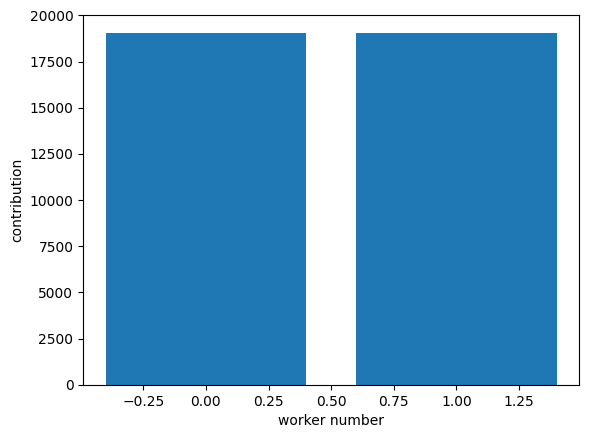

Epoch [61/200] Batch 0/625                 Loss D: 0.2340, loss G: 0.3099, FID Score: 232.0
Epoch [61/200] Batch 100/625                 Loss D: 0.2418, loss G: 0.3505, FID Score: 224.5
Epoch [61/200] Batch 200/625                 Loss D: 0.3677, loss G: 0.1918, FID Score: 229.3
Epoch [61/200] Batch 300/625                 Loss D: 0.2374, loss G: 0.3047, FID Score: 238.1
Epoch [61/200] Batch 400/625                 Loss D: 0.2438, loss G: 0.3105, FID Score: 234.7
Epoch [61/200] Batch 500/625                 Loss D: 0.2413, loss G: 0.2825, FID Score: 239.8
Epoch [61/200] Batch 600/625                 Loss D: 0.2293, loss G: 0.3178, FID Score: 230.3
Epoch [62/200] Batch 0/625                 Loss D: 0.2388, loss G: 0.3372, FID Score: 240.9
Epoch [62/200] Batch 100/625                 Loss D: 0.2257, loss G: 0.3498, FID Score: 225.9
Epoch [62/200] Batch 200/625                 Loss D: 0.2551, loss G: 0.3794, FID Score: 231.5
Epoch [62/200] Batch 300/625                 Loss D: 0.2122, los

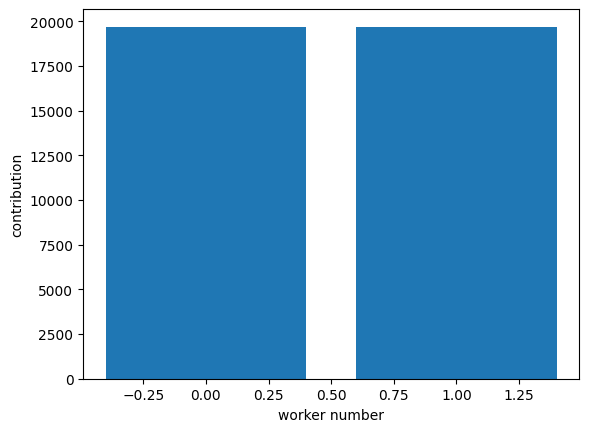

Epoch [63/200] Batch 0/625                 Loss D: 0.2409, loss G: 0.4532, FID Score: 240.5
Epoch [63/200] Batch 100/625                 Loss D: 0.2439, loss G: 0.4987, FID Score: 222.8
Epoch [63/200] Batch 200/625                 Loss D: 0.2967, loss G: 0.6896, FID Score: 232.4
Epoch [63/200] Batch 300/625                 Loss D: 0.2476, loss G: 0.2233, FID Score: 232.9
Epoch [63/200] Batch 400/625                 Loss D: 0.2552, loss G: 0.2222, FID Score: 226.6
Epoch [63/200] Batch 500/625                 Loss D: 0.2584, loss G: 0.4086, FID Score: 250.9
Epoch [63/200] Batch 600/625                 Loss D: 0.2359, loss G: 0.3733, FID Score: 232.9
Epoch [64/200] Batch 0/625                 Loss D: 0.2422, loss G: 0.3308, FID Score: 231.8
Epoch [64/200] Batch 100/625                 Loss D: 0.2180, loss G: 0.2724, FID Score: 242.4
Epoch [64/200] Batch 200/625                 Loss D: 0.2672, loss G: 0.5967, FID Score: 222.1
Epoch [64/200] Batch 300/625                 Loss D: 0.2024, los

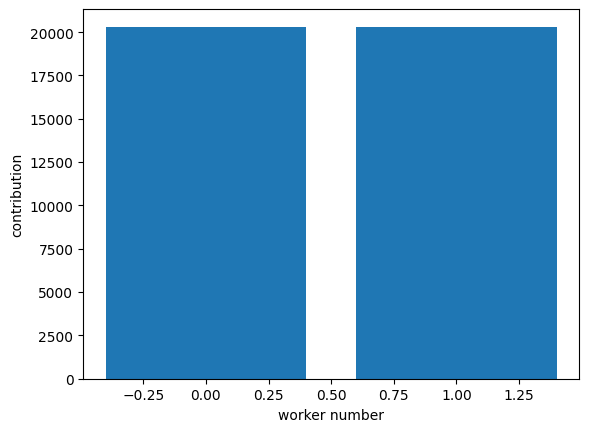

Epoch [65/200] Batch 0/625                 Loss D: 0.2654, loss G: 0.3253, FID Score: 237.8
Epoch [65/200] Batch 100/625                 Loss D: 0.2281, loss G: 0.2527, FID Score: 227.7
Epoch [65/200] Batch 200/625                 Loss D: 0.2824, loss G: 0.3963, FID Score: 244.4
Epoch [65/200] Batch 300/625                 Loss D: 0.2136, loss G: 0.3304, FID Score: 236.0
Epoch [65/200] Batch 400/625                 Loss D: 0.2469, loss G: 0.2479, FID Score: 228.3
Epoch [65/200] Batch 500/625                 Loss D: 0.2630, loss G: 0.3628, FID Score: 223.5
Epoch [65/200] Batch 600/625                 Loss D: 0.2335, loss G: 0.2840, FID Score: 230.9
Epoch [66/200] Batch 0/625                 Loss D: 0.2637, loss G: 0.5381, FID Score: 239.6
Epoch [66/200] Batch 100/625                 Loss D: 0.2491, loss G: 0.2987, FID Score: 233.6
Epoch [66/200] Batch 200/625                 Loss D: 0.2484, loss G: 0.3891, FID Score: 248.9
Epoch [66/200] Batch 300/625                 Loss D: 0.2708, los

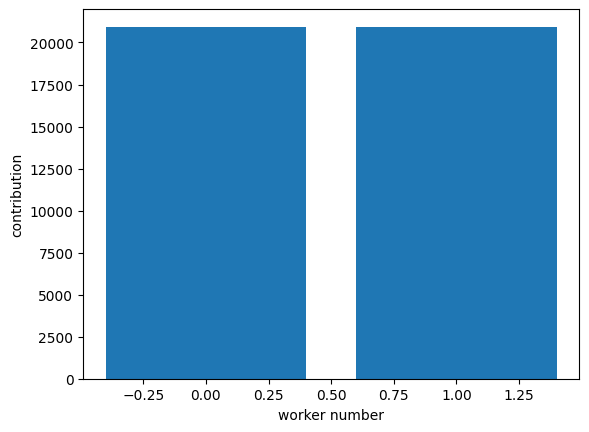

Epoch [67/200] Batch 0/625                 Loss D: 0.2604, loss G: 0.2759, FID Score: 239.8
Epoch [67/200] Batch 100/625                 Loss D: 0.2502, loss G: 0.2598, FID Score: 232.8
Epoch [67/200] Batch 200/625                 Loss D: 0.2117, loss G: 0.4585, FID Score: 241.9
Epoch [67/200] Batch 300/625                 Loss D: 0.2317, loss G: 0.3570, FID Score: 247.1
Epoch [67/200] Batch 400/625                 Loss D: 0.2341, loss G: 0.2476, FID Score: 235.1
Epoch [67/200] Batch 500/625                 Loss D: 0.2256, loss G: 0.2837, FID Score: 225.2
Epoch [67/200] Batch 600/625                 Loss D: 0.2131, loss G: 0.3465, FID Score: 232.3
Epoch [68/200] Batch 0/625                 Loss D: 0.2413, loss G: 0.3435, FID Score: 227.5
Epoch [68/200] Batch 100/625                 Loss D: 0.2438, loss G: 0.3143, FID Score: 233.3
Epoch [68/200] Batch 200/625                 Loss D: 0.2658, loss G: 0.5946, FID Score: 234.4
Epoch [68/200] Batch 300/625                 Loss D: 0.1862, los

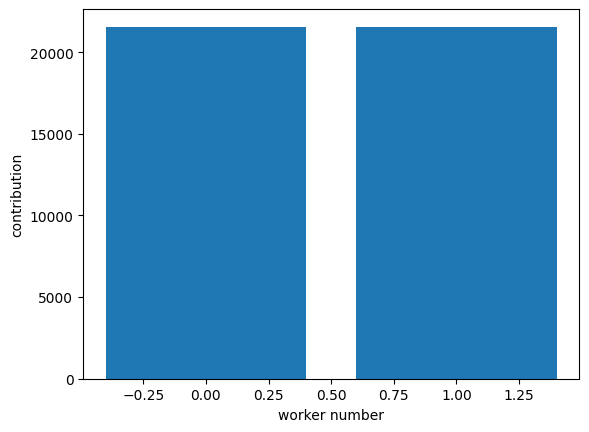

Epoch [69/200] Batch 0/625                 Loss D: 0.2558, loss G: 0.3464, FID Score: 230.4
Epoch [69/200] Batch 100/625                 Loss D: 0.2359, loss G: 0.3217, FID Score: 243.1
Epoch [69/200] Batch 200/625                 Loss D: 0.2686, loss G: 0.4193, FID Score: 239.5
Epoch [69/200] Batch 300/625                 Loss D: 0.2189, loss G: 0.4053, FID Score: 239.4
Epoch [69/200] Batch 400/625                 Loss D: 0.2218, loss G: 0.3372, FID Score: 238.2
Epoch [69/200] Batch 500/625                 Loss D: 0.2404, loss G: 0.3494, FID Score: 229.8
Epoch [69/200] Batch 600/625                 Loss D: 0.2380, loss G: 0.3168, FID Score: 232.8
Epoch [70/200] Batch 0/625                 Loss D: 0.2316, loss G: 0.2947, FID Score: 236.0
Epoch [70/200] Batch 100/625                 Loss D: 0.2311, loss G: 0.3518, FID Score: 238.6
Epoch [70/200] Batch 200/625                 Loss D: 0.2499, loss G: 0.4370, FID Score: 252.3
Epoch [70/200] Batch 300/625                 Loss D: 0.2462, los

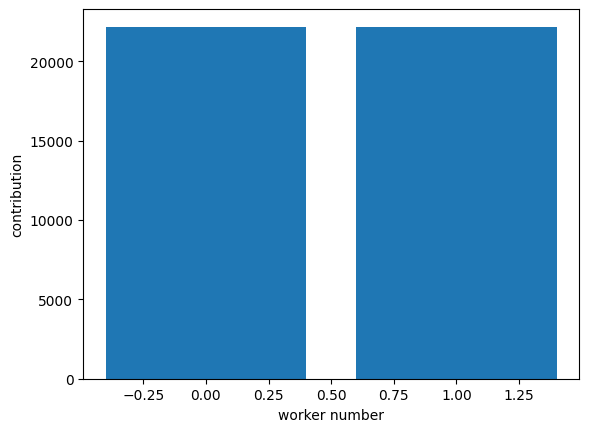

Epoch [71/200] Batch 0/625                 Loss D: 0.2521, loss G: 0.3764, FID Score: 224.3
Epoch [71/200] Batch 100/625                 Loss D: 0.2342, loss G: 0.3374, FID Score: 239.2
Epoch [71/200] Batch 200/625                 Loss D: 0.2942, loss G: 0.3014, FID Score: 243.0
Epoch [71/200] Batch 300/625                 Loss D: 0.1921, loss G: 0.3305, FID Score: 238.3
Epoch [71/200] Batch 400/625                 Loss D: 0.2061, loss G: 0.3515, FID Score: 250.8
Epoch [71/200] Batch 500/625                 Loss D: 0.2631, loss G: 0.3571, FID Score: 234.8
Epoch [71/200] Batch 600/625                 Loss D: 0.2524, loss G: 0.3035, FID Score: 237.3
Epoch [72/200] Batch 0/625                 Loss D: 0.2695, loss G: 0.2554, FID Score: 229.7
Epoch [72/200] Batch 100/625                 Loss D: 0.2653, loss G: 0.2764, FID Score: 251.0
Epoch [72/200] Batch 200/625                 Loss D: 0.2297, loss G: 0.4141, FID Score: 244.5
Epoch [72/200] Batch 300/625                 Loss D: 0.2515, los

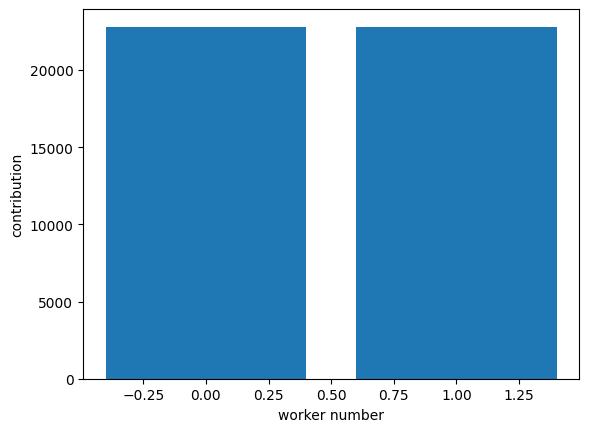

Epoch [73/200] Batch 0/625                 Loss D: 0.2550, loss G: 0.3789, FID Score: 231.8
Epoch [73/200] Batch 100/625                 Loss D: 0.2844, loss G: 0.5630, FID Score: 225.9
Epoch [73/200] Batch 200/625                 Loss D: 0.2611, loss G: 0.2890, FID Score: 244.7
Epoch [73/200] Batch 300/625                 Loss D: 0.2184, loss G: 0.2740, FID Score: 243.0
Epoch [73/200] Batch 400/625                 Loss D: 0.2298, loss G: 0.3226, FID Score: 244.7
Epoch [73/200] Batch 500/625                 Loss D: 0.2905, loss G: 0.5493, FID Score: 236.7
Epoch [73/200] Batch 600/625                 Loss D: 0.2078, loss G: 0.3198, FID Score: 228.2
Epoch [74/200] Batch 0/625                 Loss D: 0.2545, loss G: 0.4269, FID Score: 227.6
Epoch [74/200] Batch 100/625                 Loss D: 0.2594, loss G: 0.2984, FID Score: 231.0
Epoch [74/200] Batch 200/625                 Loss D: 0.2591, loss G: 0.3615, FID Score: 228.7
Epoch [74/200] Batch 300/625                 Loss D: 0.2109, los

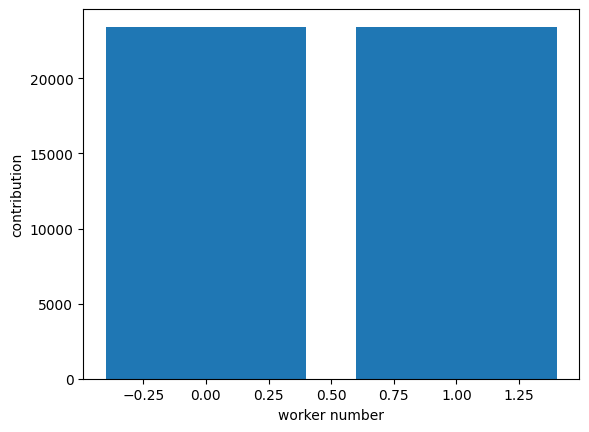

Epoch [75/200] Batch 0/625                 Loss D: 0.2556, loss G: 0.3938, FID Score: 243.5
Epoch [75/200] Batch 100/625                 Loss D: 0.2365, loss G: 0.3017, FID Score: 226.8
Epoch [75/200] Batch 200/625                 Loss D: 0.2491, loss G: 0.3846, FID Score: 241.1
Epoch [75/200] Batch 300/625                 Loss D: 0.2293, loss G: 0.5479, FID Score: 226.4
Epoch [75/200] Batch 400/625                 Loss D: 0.2358, loss G: 0.3647, FID Score: 233.7
Epoch [75/200] Batch 500/625                 Loss D: 0.2750, loss G: 0.3287, FID Score: 219.3
Epoch [75/200] Batch 600/625                 Loss D: 0.2558, loss G: 0.3525, FID Score: 222.4
Epoch [76/200] Batch 0/625                 Loss D: 0.2546, loss G: 0.2759, FID Score: 217.0
Epoch [76/200] Batch 100/625                 Loss D: 0.2576, loss G: 0.2592, FID Score: 240.2
Epoch [76/200] Batch 200/625                 Loss D: 0.2912, loss G: 0.1913, FID Score: 235.3
Epoch [76/200] Batch 300/625                 Loss D: 0.2457, los

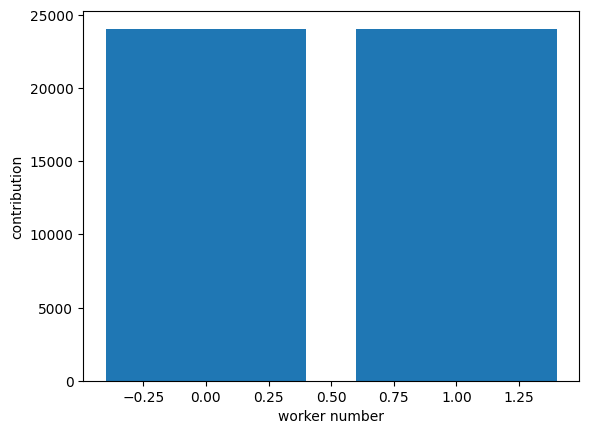

Epoch [77/200] Batch 0/625                 Loss D: 0.2489, loss G: 0.2607, FID Score: 237.5
Epoch [77/200] Batch 100/625                 Loss D: 0.2292, loss G: 0.3294, FID Score: 247.9
Epoch [77/200] Batch 200/625                 Loss D: 0.2623, loss G: 0.4510, FID Score: 243.2
Epoch [77/200] Batch 300/625                 Loss D: 0.2189, loss G: 0.3759, FID Score: 233.1
Epoch [77/200] Batch 400/625                 Loss D: 0.2667, loss G: 0.2970, FID Score: 244.3
Epoch [77/200] Batch 500/625                 Loss D: 0.2661, loss G: 0.3025, FID Score: 229.6
Epoch [77/200] Batch 600/625                 Loss D: 0.2553, loss G: 0.3674, FID Score: 225.8
Epoch [78/200] Batch 0/625                 Loss D: 0.2600, loss G: 0.3624, FID Score: 224.7
Epoch [78/200] Batch 100/625                 Loss D: 0.2479, loss G: 0.3887, FID Score: 238.9
Epoch [78/200] Batch 200/625                 Loss D: 0.2384, loss G: 0.4573, FID Score: 225.4
Epoch [78/200] Batch 300/625                 Loss D: 0.2223, los

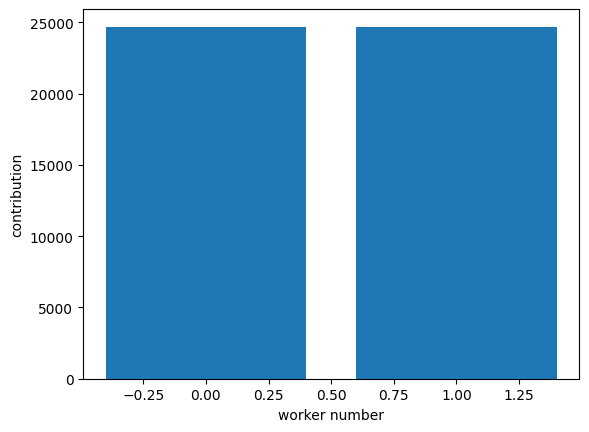

Epoch [79/200] Batch 0/625                 Loss D: 0.2740, loss G: 0.3160, FID Score: 224.5
Epoch [79/200] Batch 100/625                 Loss D: 0.2785, loss G: 0.3026, FID Score: 224.8
Epoch [79/200] Batch 200/625                 Loss D: 0.2699, loss G: 0.3887, FID Score: 237.5
Epoch [79/200] Batch 300/625                 Loss D: 0.2670, loss G: 0.2400, FID Score: 256.4
Epoch [79/200] Batch 400/625                 Loss D: 0.2330, loss G: 0.2817, FID Score: 237.5
Epoch [79/200] Batch 500/625                 Loss D: 0.2856, loss G: 0.3193, FID Score: 242.0
Epoch [79/200] Batch 600/625                 Loss D: 0.2798, loss G: 0.3866, FID Score: 236.4
Epoch [80/200] Batch 0/625                 Loss D: 0.2553, loss G: 0.4598, FID Score: 230.3
Epoch [80/200] Batch 100/625                 Loss D: 0.2452, loss G: 0.3529, FID Score: 260.0
Epoch [80/200] Batch 200/625                 Loss D: 0.2476, loss G: 0.3189, FID Score: 224.4
Epoch [80/200] Batch 300/625                 Loss D: 0.2360, los

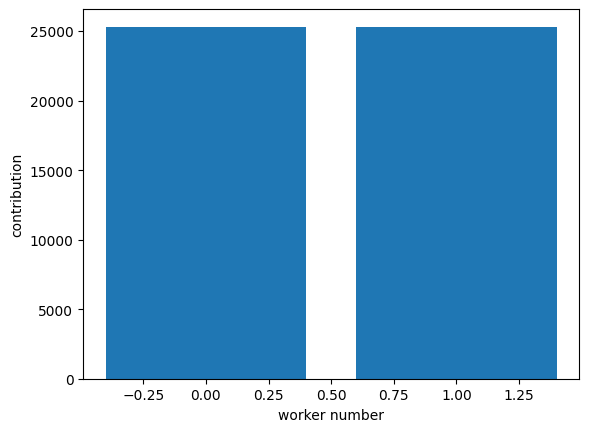

Epoch [81/200] Batch 0/625                 Loss D: 0.2513, loss G: 0.3654, FID Score: 241.0
Epoch [81/200] Batch 100/625                 Loss D: 0.2437, loss G: 0.2666, FID Score: 225.6
Epoch [81/200] Batch 200/625                 Loss D: 0.2487, loss G: 0.3161, FID Score: 232.6
Epoch [81/200] Batch 300/625                 Loss D: 0.2340, loss G: 0.3154, FID Score: 253.9
Epoch [81/200] Batch 400/625                 Loss D: 0.2471, loss G: 0.2456, FID Score: 228.2
Epoch [81/200] Batch 500/625                 Loss D: 0.2664, loss G: 0.4467, FID Score: 235.8
Epoch [81/200] Batch 600/625                 Loss D: 0.2743, loss G: 0.2925, FID Score: 231.9
Epoch [82/200] Batch 0/625                 Loss D: 0.2778, loss G: 0.4026, FID Score: 230.0
Epoch [82/200] Batch 100/625                 Loss D: 0.2626, loss G: 0.3782, FID Score: 229.5
Epoch [82/200] Batch 200/625                 Loss D: 0.2519, loss G: 0.3491, FID Score: 234.4
Epoch [82/200] Batch 300/625                 Loss D: 0.2080, los

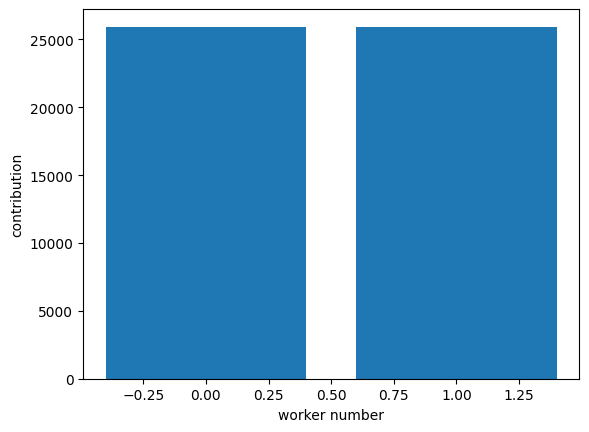

Epoch [83/200] Batch 0/625                 Loss D: 0.2577, loss G: 0.4071, FID Score: 237.6
Epoch [83/200] Batch 100/625                 Loss D: 0.2738, loss G: 0.3707, FID Score: 238.0
Epoch [83/200] Batch 200/625                 Loss D: 0.3233, loss G: 0.2659, FID Score: 238.4
Epoch [83/200] Batch 300/625                 Loss D: 0.2220, loss G: 0.3573, FID Score: 217.9
Epoch [83/200] Batch 400/625                 Loss D: 0.2460, loss G: 0.3219, FID Score: 243.4
Epoch [83/200] Batch 500/625                 Loss D: 0.2973, loss G: 0.2755, FID Score: 235.3
Epoch [83/200] Batch 600/625                 Loss D: 0.2532, loss G: 0.2727, FID Score: 219.2
Epoch [84/200] Batch 0/625                 Loss D: 0.2815, loss G: 0.3136, FID Score: 236.5
Epoch [84/200] Batch 100/625                 Loss D: 0.2565, loss G: 0.3654, FID Score: 226.8
Epoch [84/200] Batch 200/625                 Loss D: 0.2603, loss G: 0.4164, FID Score: 228.6
Epoch [84/200] Batch 300/625                 Loss D: 0.2688, los

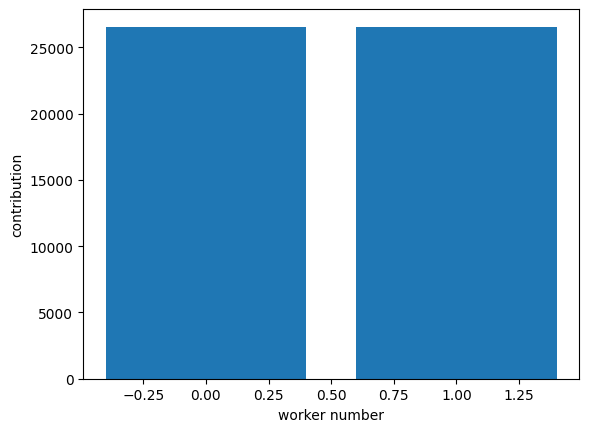

Epoch [85/200] Batch 0/625                 Loss D: 0.2805, loss G: 0.3208, FID Score: 249.6
Epoch [85/200] Batch 100/625                 Loss D: 0.2408, loss G: 0.2655, FID Score: 235.2
Epoch [85/200] Batch 200/625                 Loss D: 0.2916, loss G: 0.2843, FID Score: 234.0
Epoch [85/200] Batch 300/625                 Loss D: 0.2222, loss G: 0.4729, FID Score: 228.6
Epoch [85/200] Batch 400/625                 Loss D: 0.2376, loss G: 0.3652, FID Score: 241.7
Epoch [85/200] Batch 500/625                 Loss D: 0.2654, loss G: 0.4536, FID Score: 229.4
Epoch [85/200] Batch 600/625                 Loss D: 0.2606, loss G: 0.3114, FID Score: 233.3
Epoch [86/200] Batch 0/625                 Loss D: 0.2931, loss G: 0.3061, FID Score: 231.1
Epoch [86/200] Batch 100/625                 Loss D: 0.2435, loss G: 0.3754, FID Score: 237.5
Epoch [86/200] Batch 200/625                 Loss D: 0.2479, loss G: 0.5297, FID Score: 232.2
Epoch [86/200] Batch 300/625                 Loss D: 0.2351, los

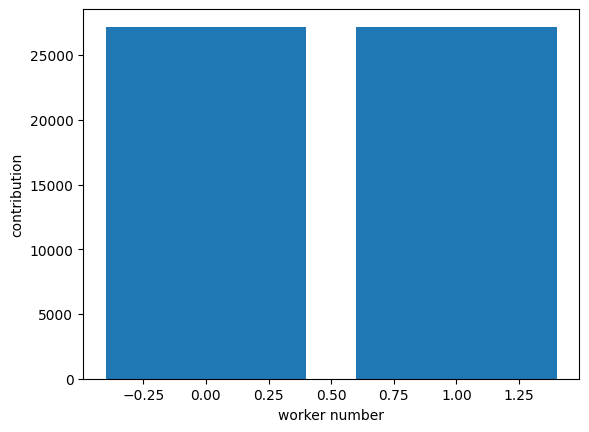

Epoch [87/200] Batch 0/625                 Loss D: 0.2578, loss G: 0.3461, FID Score: 222.6
Epoch [87/200] Batch 100/625                 Loss D: 0.2508, loss G: 0.2427, FID Score: 241.0
Epoch [87/200] Batch 200/625                 Loss D: 0.2708, loss G: 0.3509, FID Score: 248.4
Epoch [87/200] Batch 300/625                 Loss D: 0.2559, loss G: 0.3547, FID Score: 242.0
Epoch [87/200] Batch 400/625                 Loss D: 0.2619, loss G: 0.2404, FID Score: 232.3
Epoch [87/200] Batch 500/625                 Loss D: 0.2775, loss G: 0.3595, FID Score: 216.7
Epoch [87/200] Batch 600/625                 Loss D: 0.2441, loss G: 0.2801, FID Score: 253.4
Epoch [88/200] Batch 0/625                 Loss D: 0.2568, loss G: 0.3013, FID Score: 234.8
Epoch [88/200] Batch 100/625                 Loss D: 0.2382, loss G: 0.3267, FID Score: 239.7
Epoch [88/200] Batch 200/625                 Loss D: 0.2805, loss G: 0.4082, FID Score: 243.1
Epoch [88/200] Batch 300/625                 Loss D: 0.2366, los

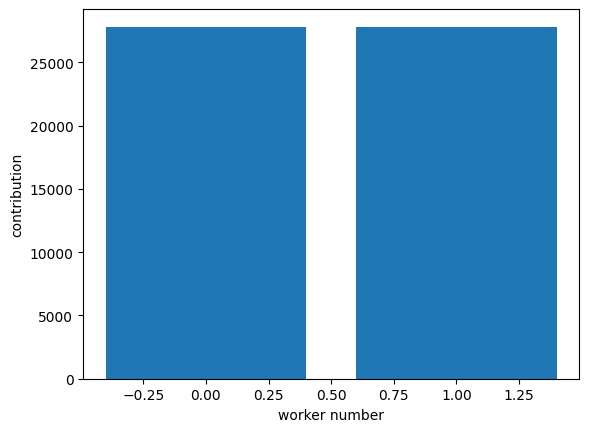

Epoch [89/200] Batch 0/625                 Loss D: 0.2500, loss G: 0.3156, FID Score: 239.5
Epoch [89/200] Batch 100/625                 Loss D: 0.2563, loss G: 0.2766, FID Score: 235.8
Epoch [89/200] Batch 200/625                 Loss D: 0.2553, loss G: 0.4648, FID Score: 246.2
Epoch [89/200] Batch 300/625                 Loss D: 0.2507, loss G: 0.2810, FID Score: 240.3
Epoch [89/200] Batch 400/625                 Loss D: 0.2550, loss G: 0.2565, FID Score: 232.6
Epoch [89/200] Batch 500/625                 Loss D: 0.2793, loss G: 0.4650, FID Score: 241.7
Epoch [89/200] Batch 600/625                 Loss D: 0.2636, loss G: 0.2831, FID Score: 224.4
Epoch [90/200] Batch 0/625                 Loss D: 0.2534, loss G: 0.2907, FID Score: 237.8
Epoch [90/200] Batch 100/625                 Loss D: 0.2641, loss G: 0.3426, FID Score: 241.7
Epoch [90/200] Batch 200/625                 Loss D: 0.2611, loss G: 0.3815, FID Score: 240.0
Epoch [90/200] Batch 300/625                 Loss D: 0.2488, los

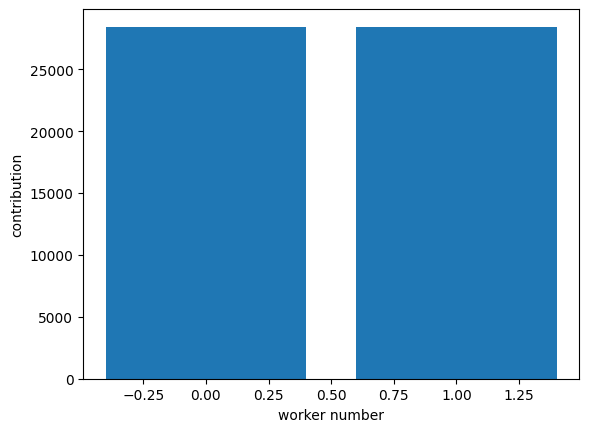

Epoch [91/200] Batch 0/625                 Loss D: 0.2675, loss G: 0.3740, FID Score: 241.0
Epoch [91/200] Batch 100/625                 Loss D: 0.2623, loss G: 0.3817, FID Score: 235.9
Epoch [91/200] Batch 200/625                 Loss D: 0.2651, loss G: 0.3113, FID Score: 231.5
Epoch [91/200] Batch 300/625                 Loss D: 0.2460, loss G: 0.2523, FID Score: 237.8
Epoch [91/200] Batch 400/625                 Loss D: 0.2596, loss G: 0.2807, FID Score: 237.7
Epoch [91/200] Batch 500/625                 Loss D: 0.3154, loss G: 0.5133, FID Score: 232.4
Epoch [91/200] Batch 600/625                 Loss D: 0.2675, loss G: 0.2325, FID Score: 224.4
Epoch [92/200] Batch 0/625                 Loss D: 0.2961, loss G: 0.3866, FID Score: 222.6
Epoch [92/200] Batch 100/625                 Loss D: 0.2628, loss G: 0.3066, FID Score: 237.8
Epoch [92/200] Batch 200/625                 Loss D: 0.2705, loss G: 0.2601, FID Score: 240.6
Epoch [92/200] Batch 300/625                 Loss D: 0.2557, los

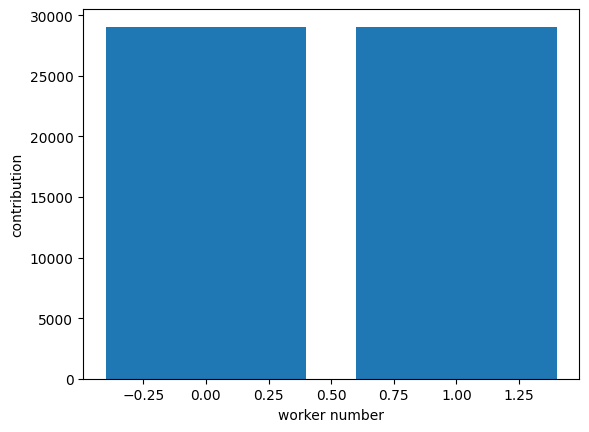

Epoch [93/200] Batch 0/625                 Loss D: 0.2708, loss G: 0.3289, FID Score: 226.0
Epoch [93/200] Batch 100/625                 Loss D: 0.2441, loss G: 0.2801, FID Score: 235.7
Epoch [93/200] Batch 200/625                 Loss D: 0.2576, loss G: 0.3414, FID Score: 232.8
Epoch [93/200] Batch 300/625                 Loss D: 0.2512, loss G: 0.3777, FID Score: 242.5
Epoch [93/200] Batch 400/625                 Loss D: 0.2693, loss G: 0.4166, FID Score: 229.7
Epoch [93/200] Batch 500/625                 Loss D: 0.2748, loss G: 0.3669, FID Score: 238.5
Epoch [93/200] Batch 600/625                 Loss D: 0.2646, loss G: 0.2995, FID Score: 232.8
Epoch [94/200] Batch 0/625                 Loss D: 0.2475, loss G: 0.3940, FID Score: 241.8
Epoch [94/200] Batch 100/625                 Loss D: 0.2719, loss G: 0.2578, FID Score: 228.0
Epoch [94/200] Batch 200/625                 Loss D: 0.2867, loss G: 0.4299, FID Score: 220.5
Epoch [94/200] Batch 300/625                 Loss D: 0.2348, los

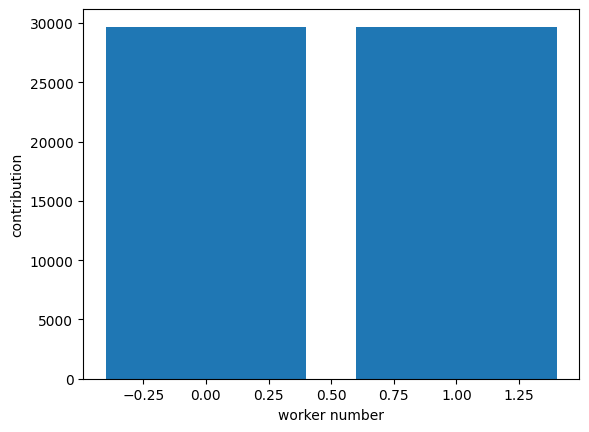

Epoch [95/200] Batch 0/625                 Loss D: 0.2552, loss G: 0.2847, FID Score: 236.0
Epoch [95/200] Batch 100/625                 Loss D: 0.2518, loss G: 0.2604, FID Score: 241.5
Epoch [95/200] Batch 200/625                 Loss D: 0.2424, loss G: 0.3693, FID Score: 248.4
Epoch [95/200] Batch 300/625                 Loss D: 0.2533, loss G: 0.2859, FID Score: 243.7
Epoch [95/200] Batch 400/625                 Loss D: 0.2454, loss G: 0.3236, FID Score: 227.6
Epoch [95/200] Batch 500/625                 Loss D: 0.2501, loss G: 0.3059, FID Score: 231.9
Epoch [95/200] Batch 600/625                 Loss D: 0.2825, loss G: 0.3343, FID Score: 227.5
Epoch [96/200] Batch 0/625                 Loss D: 0.2810, loss G: 0.3805, FID Score: 228.6
Epoch [96/200] Batch 100/625                 Loss D: 0.2459, loss G: 0.3205, FID Score: 236.0
Epoch [96/200] Batch 200/625                 Loss D: 0.2864, loss G: 0.4488, FID Score: 231.1
Epoch [96/200] Batch 300/625                 Loss D: 0.2465, los

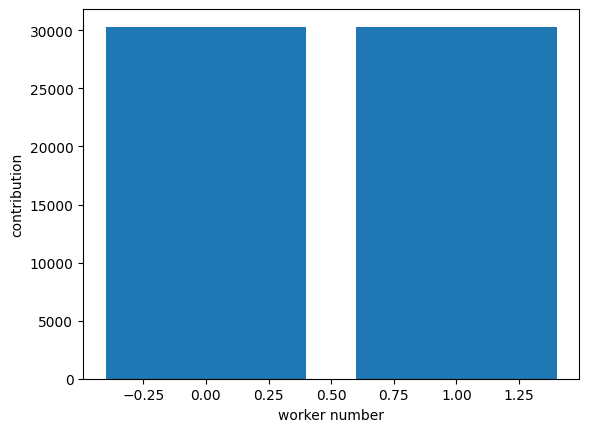

Epoch [97/200] Batch 0/625                 Loss D: 0.2854, loss G: 0.2855, FID Score: 236.4
Epoch [97/200] Batch 100/625                 Loss D: 0.2476, loss G: 0.3136, FID Score: 228.0
Epoch [97/200] Batch 200/625                 Loss D: 0.2677, loss G: 0.3670, FID Score: 237.0
Epoch [97/200] Batch 300/625                 Loss D: 0.2661, loss G: 0.3233, FID Score: 231.0
Epoch [97/200] Batch 400/625                 Loss D: 0.2485, loss G: 0.3007, FID Score: 235.8
Epoch [97/200] Batch 500/625                 Loss D: 0.2956, loss G: 0.5110, FID Score: 225.2
Epoch [97/200] Batch 600/625                 Loss D: 0.2652, loss G: 0.3137, FID Score: 234.6
Epoch [98/200] Batch 0/625                 Loss D: 0.3087, loss G: 0.2100, FID Score: 233.1
Epoch [98/200] Batch 100/625                 Loss D: 0.2692, loss G: 0.2603, FID Score: 227.2
Epoch [98/200] Batch 200/625                 Loss D: 0.2706, loss G: 0.3620, FID Score: 237.5
Epoch [98/200] Batch 300/625                 Loss D: 0.2445, los

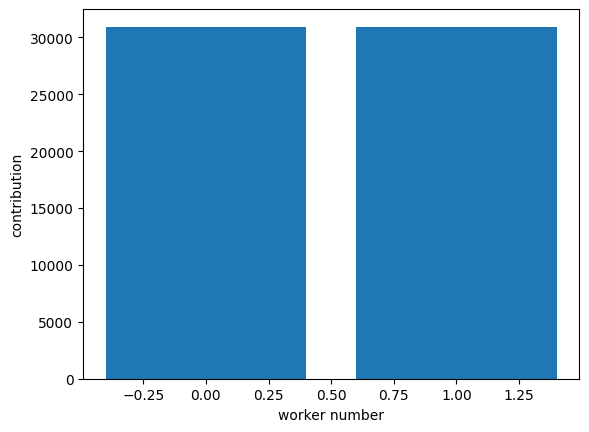

Epoch [99/200] Batch 0/625                 Loss D: 0.2560, loss G: 0.4040, FID Score: 236.4
Epoch [99/200] Batch 100/625                 Loss D: 0.2759, loss G: 0.2911, FID Score: 236.6
Epoch [99/200] Batch 200/625                 Loss D: 0.2796, loss G: 0.3383, FID Score: 252.7
Epoch [99/200] Batch 300/625                 Loss D: 0.2642, loss G: 0.2999, FID Score: 232.8
Epoch [99/200] Batch 400/625                 Loss D: 0.2275, loss G: 0.2359, FID Score: 232.4
Epoch [99/200] Batch 500/625                 Loss D: 0.2721, loss G: 0.2799, FID Score: 237.0
Epoch [99/200] Batch 600/625                 Loss D: 0.2632, loss G: 0.2996, FID Score: 233.3
Epoch [100/200] Batch 0/625                 Loss D: 0.2906, loss G: 0.2940, FID Score: 216.5
Epoch [100/200] Batch 100/625                 Loss D: 0.2577, loss G: 0.3182, FID Score: 232.3
Epoch [100/200] Batch 200/625                 Loss D: 0.2983, loss G: 0.2825, FID Score: 238.8
Epoch [100/200] Batch 300/625                 Loss D: 0.2407,

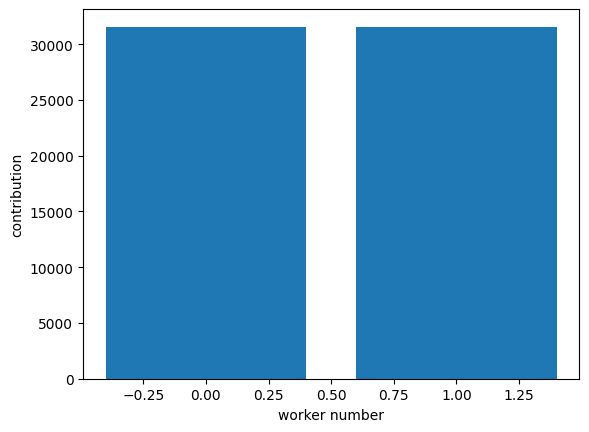

Epoch [101/200] Batch 0/625                 Loss D: 0.2545, loss G: 0.2856, FID Score: 228.5
Epoch [101/200] Batch 100/625                 Loss D: 0.2702, loss G: 0.3439, FID Score: 227.1
Epoch [101/200] Batch 200/625                 Loss D: 0.2685, loss G: 0.3587, FID Score: 236.2
Epoch [101/200] Batch 300/625                 Loss D: 0.2520, loss G: 0.2767, FID Score: 244.8
Epoch [101/200] Batch 400/625                 Loss D: 0.2552, loss G: 0.3479, FID Score: 242.4
Epoch [101/200] Batch 500/625                 Loss D: 0.2831, loss G: 0.2960, FID Score: 234.5
Epoch [101/200] Batch 600/625                 Loss D: 0.2519, loss G: 0.3313, FID Score: 248.3
Epoch [102/200] Batch 0/625                 Loss D: 0.2758, loss G: 0.2852, FID Score: 227.0
Epoch [102/200] Batch 100/625                 Loss D: 0.2438, loss G: 0.3669, FID Score: 243.9
Epoch [102/200] Batch 200/625                 Loss D: 0.2786, loss G: 0.2644, FID Score: 248.4
Epoch [102/200] Batch 300/625                 Loss D: 

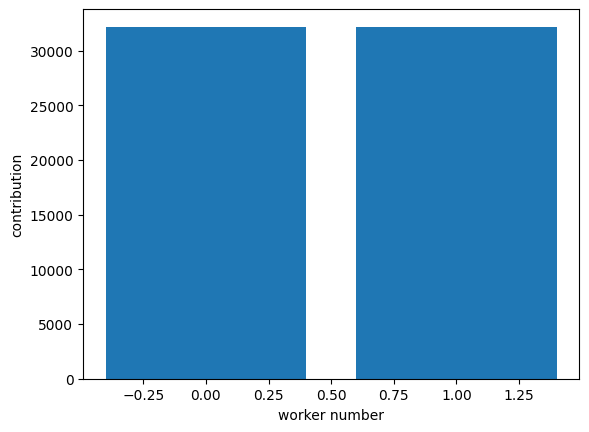

Epoch [103/200] Batch 0/625                 Loss D: 0.2770, loss G: 0.3919, FID Score: 232.6
Epoch [103/200] Batch 100/625                 Loss D: 0.2651, loss G: 0.2761, FID Score: 233.7
Epoch [103/200] Batch 200/625                 Loss D: 0.2610, loss G: 0.3505, FID Score: 246.6
Epoch [103/200] Batch 300/625                 Loss D: 0.2265, loss G: 0.2626, FID Score: 234.5
Epoch [103/200] Batch 400/625                 Loss D: 0.2666, loss G: 0.2402, FID Score: 242.7
Epoch [103/200] Batch 500/625                 Loss D: 0.2970, loss G: 0.3806, FID Score: 220.9
Epoch [103/200] Batch 600/625                 Loss D: 0.2577, loss G: 0.2785, FID Score: 233.4
Epoch [104/200] Batch 0/625                 Loss D: 0.3020, loss G: 0.2659, FID Score: 241.9
Epoch [104/200] Batch 100/625                 Loss D: 0.2518, loss G: 0.3512, FID Score: 232.5
Epoch [104/200] Batch 200/625                 Loss D: 0.2790, loss G: 0.3567, FID Score: 246.9
Epoch [104/200] Batch 300/625                 Loss D: 

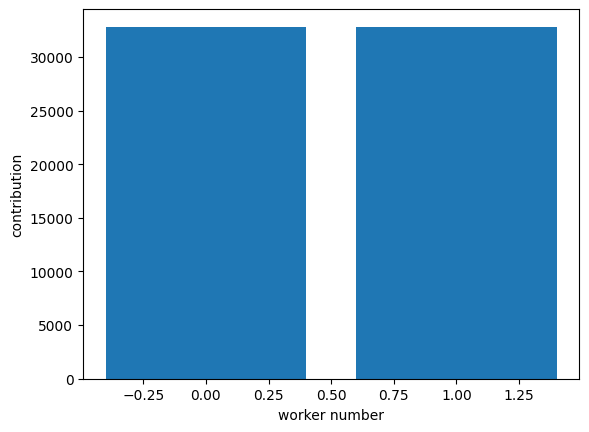

Epoch [105/200] Batch 0/625                 Loss D: 0.2756, loss G: 0.3001, FID Score: 240.1
Epoch [105/200] Batch 100/625                 Loss D: 0.2760, loss G: 0.2753, FID Score: 230.9
Epoch [105/200] Batch 200/625                 Loss D: 0.2848, loss G: 0.4325, FID Score: 241.7
Epoch [105/200] Batch 300/625                 Loss D: 0.2569, loss G: 0.2437, FID Score: 242.5
Epoch [105/200] Batch 400/625                 Loss D: 0.2457, loss G: 0.2574, FID Score: 229.0
Epoch [105/200] Batch 500/625                 Loss D: 0.2954, loss G: 0.2885, FID Score: 227.2
Epoch [105/200] Batch 600/625                 Loss D: 0.2775, loss G: 0.3566, FID Score: 230.2
Epoch [106/200] Batch 0/625                 Loss D: 0.2811, loss G: 0.3070, FID Score: 236.4
Epoch [106/200] Batch 100/625                 Loss D: 0.2409, loss G: 0.3281, FID Score: 233.0
Epoch [106/200] Batch 200/625                 Loss D: 0.2751, loss G: 0.2582, FID Score: 235.0
Epoch [106/200] Batch 300/625                 Loss D: 

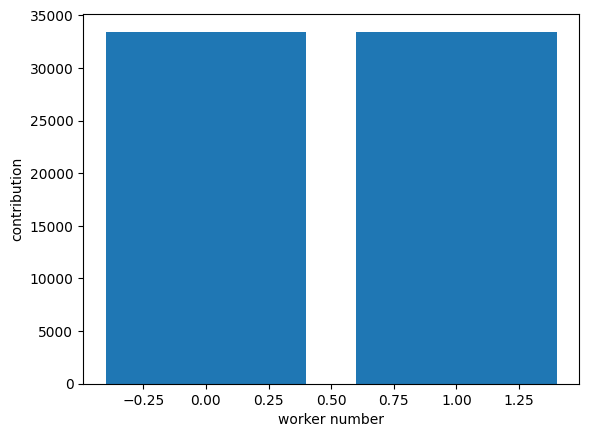

Epoch [107/200] Batch 0/625                 Loss D: 0.2956, loss G: 0.2977, FID Score: 225.4
Epoch [107/200] Batch 100/625                 Loss D: 0.2537, loss G: 0.3705, FID Score: 233.2
Epoch [107/200] Batch 200/625                 Loss D: 0.2859, loss G: 0.3176, FID Score: 244.9
Epoch [107/200] Batch 300/625                 Loss D: 0.2380, loss G: 0.2625, FID Score: 230.7
Epoch [107/200] Batch 400/625                 Loss D: 0.2486, loss G: 0.3254, FID Score: 234.1
Epoch [107/200] Batch 500/625                 Loss D: 0.3074, loss G: 0.3880, FID Score: 233.2
Epoch [107/200] Batch 600/625                 Loss D: 0.2791, loss G: 0.2367, FID Score: 242.3
Epoch [108/200] Batch 0/625                 Loss D: 0.2821, loss G: 0.2078, FID Score: 222.9
Epoch [108/200] Batch 100/625                 Loss D: 0.2708, loss G: 0.2518, FID Score: 253.2
Epoch [108/200] Batch 200/625                 Loss D: 0.2790, loss G: 0.4233, FID Score: 231.3
Epoch [108/200] Batch 300/625                 Loss D: 

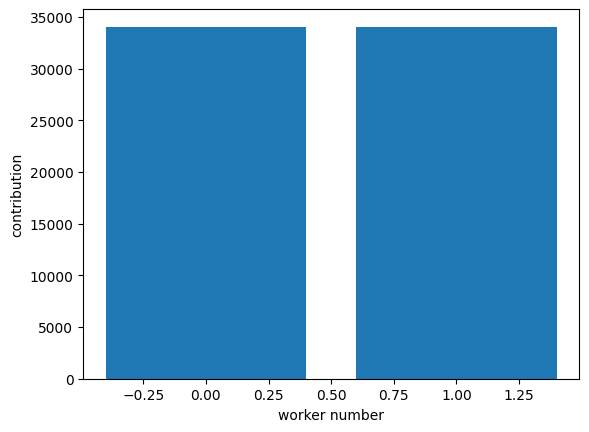

Epoch [109/200] Batch 0/625                 Loss D: 0.2950, loss G: 0.3423, FID Score: 226.3
Epoch [109/200] Batch 100/625                 Loss D: 0.2788, loss G: 0.3214, FID Score: 231.1
Epoch [109/200] Batch 200/625                 Loss D: 0.2563, loss G: 0.2858, FID Score: 225.5
Epoch [109/200] Batch 300/625                 Loss D: 0.2785, loss G: 0.2695, FID Score: 231.0
Epoch [109/200] Batch 400/625                 Loss D: 0.2576, loss G: 0.3012, FID Score: 238.5
Epoch [109/200] Batch 500/625                 Loss D: 0.3028, loss G: 0.3506, FID Score: 220.7
Epoch [109/200] Batch 600/625                 Loss D: 0.2762, loss G: 0.2754, FID Score: 238.3
Epoch [110/200] Batch 0/625                 Loss D: 0.2723, loss G: 0.3554, FID Score: 227.6
Epoch [110/200] Batch 100/625                 Loss D: 0.2572, loss G: 0.3015, FID Score: 251.6
Epoch [110/200] Batch 200/625                 Loss D: 0.2653, loss G: 0.3631, FID Score: 231.8
Epoch [110/200] Batch 300/625                 Loss D: 

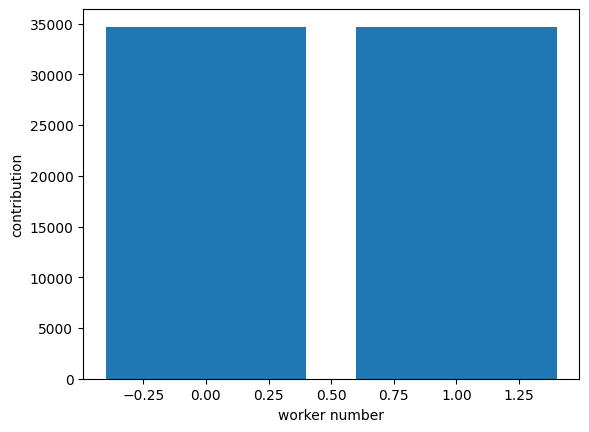

Epoch [111/200] Batch 0/625                 Loss D: 0.2623, loss G: 0.3094, FID Score: 228.6
Epoch [111/200] Batch 100/625                 Loss D: 0.2466, loss G: 0.2746, FID Score: 235.7
Epoch [111/200] Batch 200/625                 Loss D: 0.2568, loss G: 0.3349, FID Score: 239.4
Epoch [111/200] Batch 300/625                 Loss D: 0.2590, loss G: 0.2719, FID Score: 241.7
Epoch [111/200] Batch 400/625                 Loss D: 0.2581, loss G: 0.2860, FID Score: 240.5
Epoch [111/200] Batch 500/625                 Loss D: 0.2867, loss G: 0.3036, FID Score: 226.4
Epoch [111/200] Batch 600/625                 Loss D: 0.2895, loss G: 0.2755, FID Score: 229.4
Epoch [112/200] Batch 0/625                 Loss D: 0.2675, loss G: 0.3607, FID Score: 238.4
Epoch [112/200] Batch 100/625                 Loss D: 0.2564, loss G: 0.3060, FID Score: 227.0
Epoch [112/200] Batch 200/625                 Loss D: 0.2885, loss G: 0.3456, FID Score: 223.8
Epoch [112/200] Batch 300/625                 Loss D: 

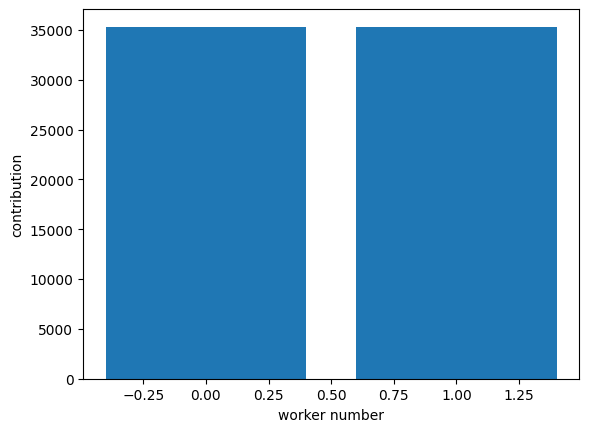

Epoch [113/200] Batch 0/625                 Loss D: 0.2718, loss G: 0.3043, FID Score: 239.5
Epoch [113/200] Batch 100/625                 Loss D: 0.2574, loss G: 0.2919, FID Score: 233.6
Epoch [113/200] Batch 200/625                 Loss D: 0.2880, loss G: 0.4185, FID Score: 240.8
Epoch [113/200] Batch 300/625                 Loss D: 0.2644, loss G: 0.2671, FID Score: 233.7
Epoch [113/200] Batch 400/625                 Loss D: 0.2460, loss G: 0.3266, FID Score: 228.7
Epoch [113/200] Batch 500/625                 Loss D: 0.2997, loss G: 0.3591, FID Score: 228.7
Epoch [113/200] Batch 600/625                 Loss D: 0.2820, loss G: 0.3378, FID Score: 221.9
Epoch [114/200] Batch 0/625                 Loss D: 0.2772, loss G: 0.2804, FID Score: 218.7
Epoch [114/200] Batch 100/625                 Loss D: 0.2631, loss G: 0.3042, FID Score: 237.8
Epoch [114/200] Batch 200/625                 Loss D: 0.2830, loss G: 0.3259, FID Score: 231.4
Epoch [114/200] Batch 300/625                 Loss D: 

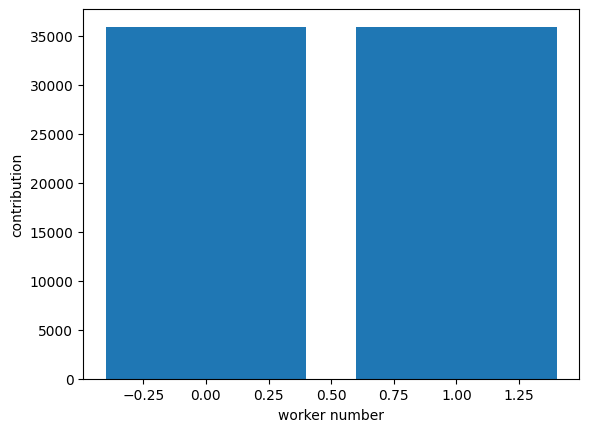

Epoch [115/200] Batch 0/625                 Loss D: 0.2982, loss G: 0.3307, FID Score: 244.1
Epoch [115/200] Batch 100/625                 Loss D: 0.2693, loss G: 0.2578, FID Score: 253.6
Epoch [115/200] Batch 200/625                 Loss D: 0.2615, loss G: 0.2732, FID Score: 234.8
Epoch [115/200] Batch 300/625                 Loss D: 0.2549, loss G: 0.3207, FID Score: 233.9
Epoch [115/200] Batch 400/625                 Loss D: 0.2550, loss G: 0.2353, FID Score: 218.1
Epoch [115/200] Batch 500/625                 Loss D: 0.2822, loss G: 0.3851, FID Score: 225.0
Epoch [115/200] Batch 600/625                 Loss D: 0.2604, loss G: 0.2980, FID Score: 227.2
Epoch [116/200] Batch 0/625                 Loss D: 0.2801, loss G: 0.2964, FID Score: 249.7
Epoch [116/200] Batch 100/625                 Loss D: 0.2539, loss G: 0.2809, FID Score: 228.4
Epoch [116/200] Batch 200/625                 Loss D: 0.2712, loss G: 0.2557, FID Score: 237.4
Epoch [116/200] Batch 300/625                 Loss D: 

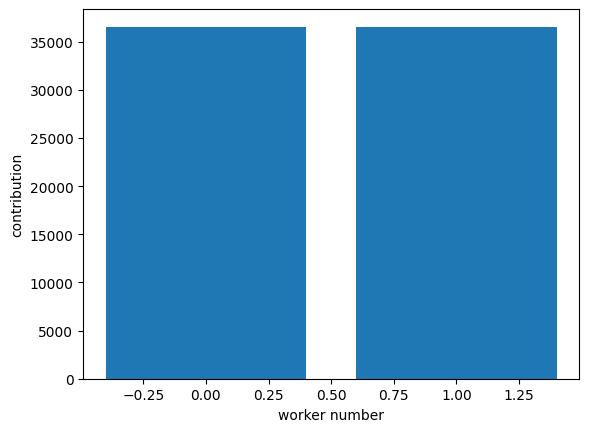

Epoch [117/200] Batch 0/625                 Loss D: 0.2829, loss G: 0.2946, FID Score: 239.3
Epoch [117/200] Batch 100/625                 Loss D: 0.2709, loss G: 0.3125, FID Score: 235.3
Epoch [117/200] Batch 200/625                 Loss D: 0.2595, loss G: 0.3534, FID Score: 251.6
Epoch [117/200] Batch 300/625                 Loss D: 0.2785, loss G: 0.3164, FID Score: 233.1
Epoch [117/200] Batch 400/625                 Loss D: 0.2671, loss G: 0.2736, FID Score: 226.3
Epoch [117/200] Batch 500/625                 Loss D: 0.2713, loss G: 0.3105, FID Score: 230.7
Epoch [117/200] Batch 600/625                 Loss D: 0.2768, loss G: 0.3641, FID Score: 223.8
Epoch [118/200] Batch 0/625                 Loss D: 0.3035, loss G: 0.2968, FID Score: 228.5
Epoch [118/200] Batch 100/625                 Loss D: 0.2558, loss G: 0.2556, FID Score: 231.9
Epoch [118/200] Batch 200/625                 Loss D: 0.2912, loss G: 0.2842, FID Score: 249.8
Epoch [118/200] Batch 300/625                 Loss D: 

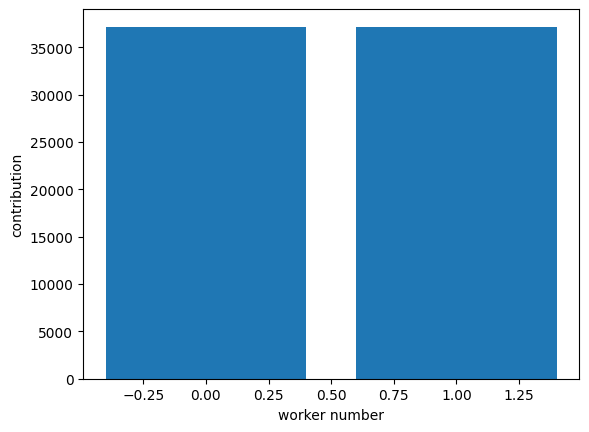

Epoch [119/200] Batch 0/625                 Loss D: 0.2608, loss G: 0.2883, FID Score: 223.9
Epoch [119/200] Batch 100/625                 Loss D: 0.2569, loss G: 0.3106, FID Score: 228.9
Epoch [119/200] Batch 200/625                 Loss D: 0.2909, loss G: 0.3533, FID Score: 229.8
Epoch [119/200] Batch 300/625                 Loss D: 0.2700, loss G: 0.2703, FID Score: 239.6
Epoch [119/200] Batch 400/625                 Loss D: 0.2656, loss G: 0.3142, FID Score: 246.8
Epoch [119/200] Batch 500/625                 Loss D: 0.3072, loss G: 0.2494, FID Score: 238.4
Epoch [119/200] Batch 600/625                 Loss D: 0.2688, loss G: 0.3041, FID Score: 227.8
Epoch [120/200] Batch 0/625                 Loss D: 0.2740, loss G: 0.2859, FID Score: 239.4
Epoch [120/200] Batch 100/625                 Loss D: 0.2574, loss G: 0.3543, FID Score: 235.0
Epoch [120/200] Batch 200/625                 Loss D: 0.2922, loss G: 0.3093, FID Score: 221.0
Epoch [120/200] Batch 300/625                 Loss D: 

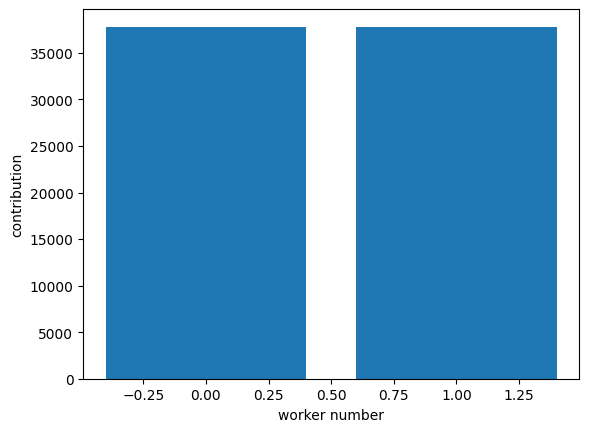

Epoch [121/200] Batch 0/625                 Loss D: 0.2858, loss G: 0.2789, FID Score: 228.8
Epoch [121/200] Batch 100/625                 Loss D: 0.2551, loss G: 0.3055, FID Score: 231.5
Epoch [121/200] Batch 200/625                 Loss D: 0.2591, loss G: 0.2481, FID Score: 223.4
Epoch [121/200] Batch 300/625                 Loss D: 0.2508, loss G: 0.2549, FID Score: 226.8
Epoch [121/200] Batch 400/625                 Loss D: 0.2572, loss G: 0.2934, FID Score: 223.6
Epoch [121/200] Batch 500/625                 Loss D: 0.3040, loss G: 0.2532, FID Score: 233.7
Epoch [121/200] Batch 600/625                 Loss D: 0.2841, loss G: 0.3227, FID Score: 236.5
Epoch [122/200] Batch 0/625                 Loss D: 0.2664, loss G: 0.2942, FID Score: 231.5
Epoch [122/200] Batch 100/625                 Loss D: 0.2585, loss G: 0.3103, FID Score: 229.4
Epoch [122/200] Batch 200/625                 Loss D: 0.2565, loss G: 0.3972, FID Score: 230.9
Epoch [122/200] Batch 300/625                 Loss D: 

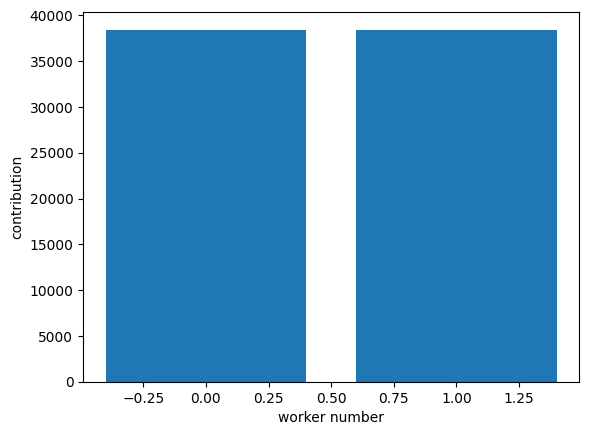

Epoch [123/200] Batch 0/625                 Loss D: 0.2852, loss G: 0.3012, FID Score: 223.1
Epoch [123/200] Batch 100/625                 Loss D: 0.2554, loss G: 0.2683, FID Score: 236.1
Epoch [123/200] Batch 200/625                 Loss D: 0.2906, loss G: 0.2707, FID Score: 232.6
Epoch [123/200] Batch 300/625                 Loss D: 0.2674, loss G: 0.2667, FID Score: 238.4
Epoch [123/200] Batch 400/625                 Loss D: 0.2534, loss G: 0.3129, FID Score: 235.9
Epoch [123/200] Batch 500/625                 Loss D: 0.2922, loss G: 0.2895, FID Score: 239.7
Epoch [123/200] Batch 600/625                 Loss D: 0.2860, loss G: 0.3064, FID Score: 225.5
Epoch [124/200] Batch 0/625                 Loss D: 0.2770, loss G: 0.2843, FID Score: 230.7
Epoch [124/200] Batch 100/625                 Loss D: 0.2546, loss G: 0.2404, FID Score: 229.1
Epoch [124/200] Batch 200/625                 Loss D: 0.2732, loss G: 0.3611, FID Score: 243.1
Epoch [124/200] Batch 300/625                 Loss D: 

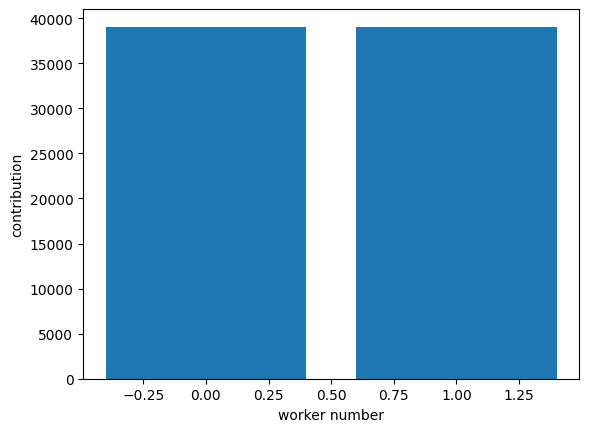

Epoch [125/200] Batch 0/625                 Loss D: 0.2942, loss G: 0.2840, FID Score: 235.3
Epoch [125/200] Batch 100/625                 Loss D: 0.2388, loss G: 0.2722, FID Score: 227.6
Epoch [125/200] Batch 200/625                 Loss D: 0.2870, loss G: 0.3675, FID Score: 243.6
Epoch [125/200] Batch 300/625                 Loss D: 0.2725, loss G: 0.2941, FID Score: 221.7
Epoch [125/200] Batch 400/625                 Loss D: 0.2675, loss G: 0.2542, FID Score: 224.2
Epoch [125/200] Batch 500/625                 Loss D: 0.2740, loss G: 0.3201, FID Score: 227.1
Epoch [125/200] Batch 600/625                 Loss D: 0.2763, loss G: 0.3911, FID Score: 226.4
Epoch [126/200] Batch 0/625                 Loss D: 0.2719, loss G: 0.2930, FID Score: 234.4
Epoch [126/200] Batch 100/625                 Loss D: 0.2648, loss G: 0.2865, FID Score: 236.3
Epoch [126/200] Batch 200/625                 Loss D: 0.2660, loss G: 0.3893, FID Score: 233.8
Epoch [126/200] Batch 300/625                 Loss D: 

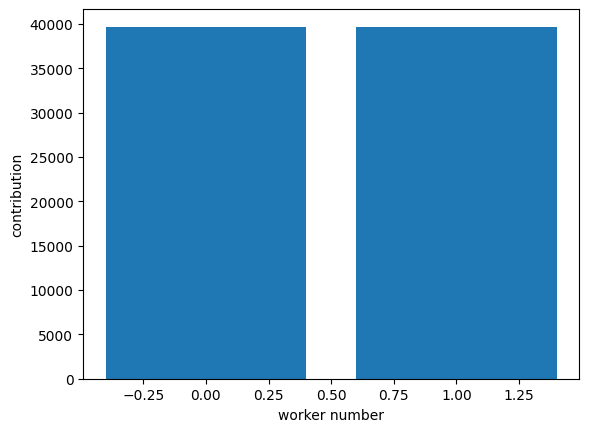

Epoch [127/200] Batch 0/625                 Loss D: 0.3093, loss G: 0.2992, FID Score: 220.8
Epoch [127/200] Batch 100/625                 Loss D: 0.2628, loss G: 0.3206, FID Score: 233.0
Epoch [127/200] Batch 200/625                 Loss D: 0.2780, loss G: 0.2732, FID Score: 234.8
Epoch [127/200] Batch 300/625                 Loss D: 0.2689, loss G: 0.2711, FID Score: 233.5
Epoch [127/200] Batch 400/625                 Loss D: 0.2677, loss G: 0.3057, FID Score: 229.3
Epoch [127/200] Batch 500/625                 Loss D: 0.2912, loss G: 0.2663, FID Score: 224.5
Epoch [127/200] Batch 600/625                 Loss D: 0.2897, loss G: 0.3779, FID Score: 231.8
Epoch [128/200] Batch 0/625                 Loss D: 0.2908, loss G: 0.2711, FID Score: 228.2
Epoch [128/200] Batch 100/625                 Loss D: 0.2616, loss G: 0.2936, FID Score: 236.9
Epoch [128/200] Batch 200/625                 Loss D: 0.2734, loss G: 0.3147, FID Score: 230.5
Epoch [128/200] Batch 300/625                 Loss D: 

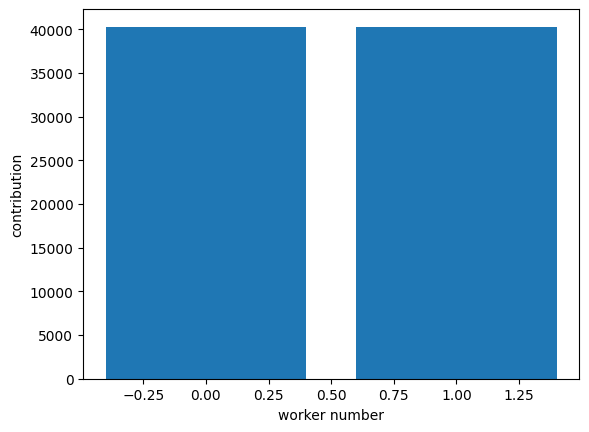

Epoch [129/200] Batch 0/625                 Loss D: 0.3125, loss G: 0.2446, FID Score: 247.2
Epoch [129/200] Batch 100/625                 Loss D: 0.2656, loss G: 0.2380, FID Score: 233.1
Epoch [129/200] Batch 200/625                 Loss D: 0.2734, loss G: 0.3025, FID Score: 246.0
Epoch [129/200] Batch 300/625                 Loss D: 0.2671, loss G: 0.3285, FID Score: 241.9
Epoch [129/200] Batch 400/625                 Loss D: 0.2497, loss G: 0.2900, FID Score: 240.3
Epoch [129/200] Batch 500/625                 Loss D: 0.2937, loss G: 0.2569, FID Score: 230.0
Epoch [129/200] Batch 600/625                 Loss D: 0.2712, loss G: 0.2576, FID Score: 234.6
Epoch [130/200] Batch 0/625                 Loss D: 0.2852, loss G: 0.2407, FID Score: 213.7
Epoch [130/200] Batch 100/625                 Loss D: 0.2832, loss G: 0.3345, FID Score: 221.3
Epoch [130/200] Batch 200/625                 Loss D: 0.2983, loss G: 0.3377, FID Score: 231.1
Epoch [130/200] Batch 300/625                 Loss D: 

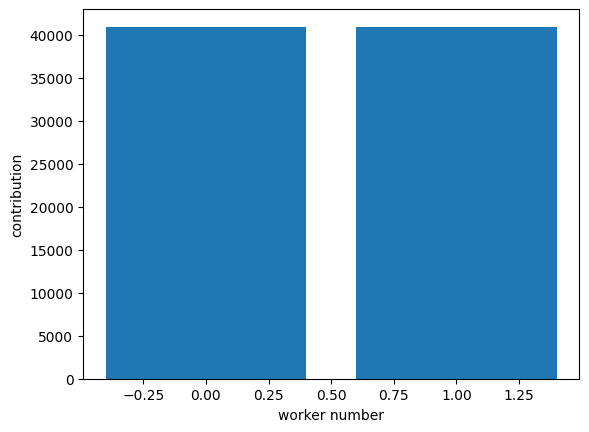

Epoch [131/200] Batch 0/625                 Loss D: 0.2829, loss G: 0.2917, FID Score: 223.9
Epoch [131/200] Batch 100/625                 Loss D: 0.2801, loss G: 0.2195, FID Score: 220.9
Epoch [131/200] Batch 200/625                 Loss D: 0.2589, loss G: 0.2999, FID Score: 238.6
Epoch [131/200] Batch 300/625                 Loss D: 0.2605, loss G: 0.3104, FID Score: 227.9
Epoch [131/200] Batch 400/625                 Loss D: 0.2706, loss G: 0.2597, FID Score: 226.8
Epoch [131/200] Batch 500/625                 Loss D: 0.2706, loss G: 0.3168, FID Score: 228.0
Epoch [131/200] Batch 600/625                 Loss D: 0.2780, loss G: 0.2994, FID Score: 222.0
Epoch [132/200] Batch 0/625                 Loss D: 0.2876, loss G: 0.2791, FID Score: 238.7
Epoch [132/200] Batch 100/625                 Loss D: 0.2584, loss G: 0.2651, FID Score: 229.8
Epoch [132/200] Batch 200/625                 Loss D: 0.2775, loss G: 0.2510, FID Score: 236.3
Epoch [132/200] Batch 300/625                 Loss D: 

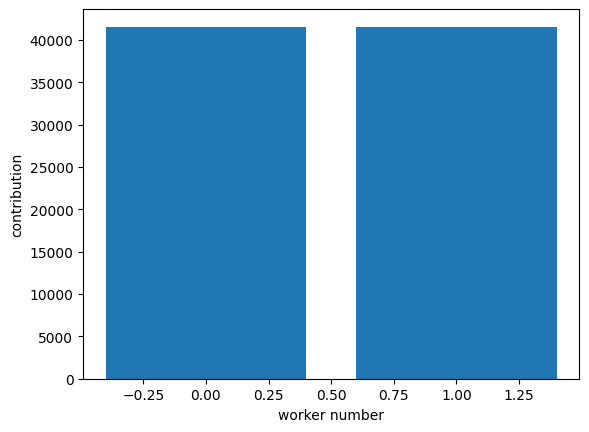

Epoch [133/200] Batch 0/625                 Loss D: 0.2951, loss G: 0.3403, FID Score: 230.9
Epoch [133/200] Batch 100/625                 Loss D: 0.2553, loss G: 0.2666, FID Score: 231.3
Epoch [133/200] Batch 200/625                 Loss D: 0.2652, loss G: 0.3410, FID Score: 233.8
Epoch [133/200] Batch 300/625                 Loss D: 0.2728, loss G: 0.2800, FID Score: 248.3
Epoch [133/200] Batch 400/625                 Loss D: 0.2399, loss G: 0.3252, FID Score: 249.1
Epoch [133/200] Batch 500/625                 Loss D: 0.2804, loss G: 0.2715, FID Score: 229.4
Epoch [133/200] Batch 600/625                 Loss D: 0.2772, loss G: 0.2862, FID Score: 236.6
Epoch [134/200] Batch 0/625                 Loss D: 0.2887, loss G: 0.2928, FID Score: 229.9
Epoch [134/200] Batch 100/625                 Loss D: 0.2640, loss G: 0.2567, FID Score: 216.2
Epoch [134/200] Batch 200/625                 Loss D: 0.2675, loss G: 0.2920, FID Score: 221.1
Epoch [134/200] Batch 300/625                 Loss D: 

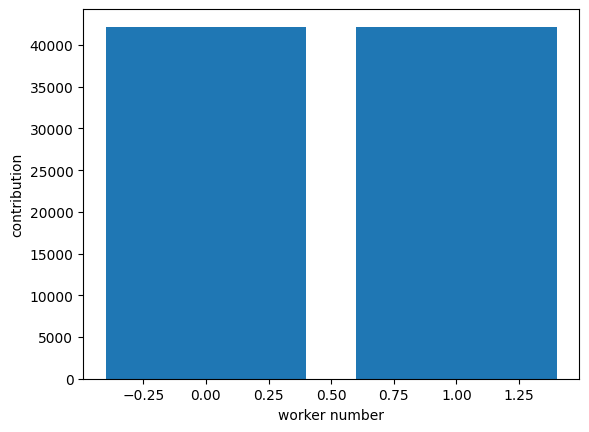

Epoch [135/200] Batch 0/625                 Loss D: 0.2736, loss G: 0.2378, FID Score: 237.9
Epoch [135/200] Batch 100/625                 Loss D: 0.2635, loss G: 0.2700, FID Score: 234.0
Epoch [135/200] Batch 200/625                 Loss D: 0.2732, loss G: 0.3311, FID Score: 245.7
Epoch [135/200] Batch 300/625                 Loss D: 0.2705, loss G: 0.2848, FID Score: 233.3
Epoch [135/200] Batch 400/625                 Loss D: 0.2747, loss G: 0.2514, FID Score: 234.2
Epoch [135/200] Batch 500/625                 Loss D: 0.2794, loss G: 0.2581, FID Score: 232.7
Epoch [135/200] Batch 600/625                 Loss D: 0.2880, loss G: 0.2358, FID Score: 242.1
Epoch [136/200] Batch 0/625                 Loss D: 0.2888, loss G: 0.2278, FID Score: 236.4
Epoch [136/200] Batch 100/625                 Loss D: 0.2529, loss G: 0.2947, FID Score: 236.3
Epoch [136/200] Batch 200/625                 Loss D: 0.2863, loss G: 0.3180, FID Score: 242.0
Epoch [136/200] Batch 300/625                 Loss D: 

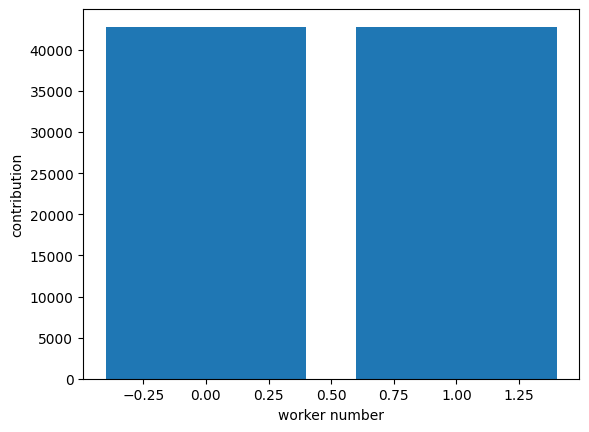

Epoch [137/200] Batch 0/625                 Loss D: 0.2915, loss G: 0.2879, FID Score: 229.8
Epoch [137/200] Batch 100/625                 Loss D: 0.2518, loss G: 0.2624, FID Score: 238.1
Epoch [137/200] Batch 200/625                 Loss D: 0.2676, loss G: 0.3289, FID Score: 234.9
Epoch [137/200] Batch 300/625                 Loss D: 0.2689, loss G: 0.2492, FID Score: 235.7
Epoch [137/200] Batch 400/625                 Loss D: 0.2585, loss G: 0.3268, FID Score: 232.7
Epoch [137/200] Batch 500/625                 Loss D: 0.2900, loss G: 0.2978, FID Score: 233.8
Epoch [137/200] Batch 600/625                 Loss D: 0.2661, loss G: 0.2693, FID Score: 217.5
Epoch [138/200] Batch 0/625                 Loss D: 0.3027, loss G: 0.3197, FID Score: 213.8
Epoch [138/200] Batch 100/625                 Loss D: 0.2780, loss G: 0.2826, FID Score: 225.4
Epoch [138/200] Batch 200/625                 Loss D: 0.2660, loss G: 0.3398, FID Score: 233.4
Epoch [138/200] Batch 300/625                 Loss D: 

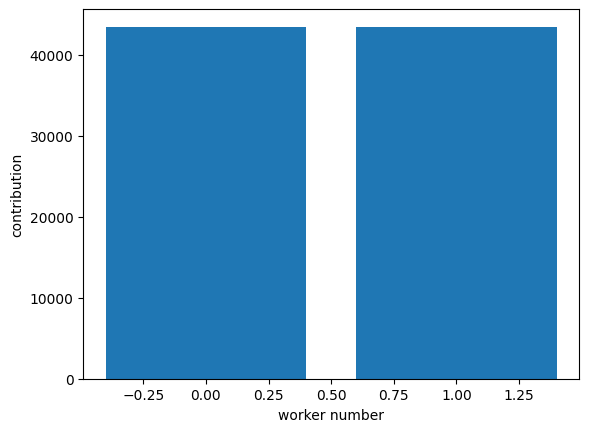

Epoch [139/200] Batch 0/625                 Loss D: 0.2912, loss G: 0.2703, FID Score: 246.2
Epoch [139/200] Batch 100/625                 Loss D: 0.2618, loss G: 0.2936, FID Score: 234.6
Epoch [139/200] Batch 200/625                 Loss D: 0.2912, loss G: 0.4473, FID Score: 235.0
Epoch [139/200] Batch 300/625                 Loss D: 0.2646, loss G: 0.2210, FID Score: 222.1
Epoch [139/200] Batch 400/625                 Loss D: 0.2604, loss G: 0.3125, FID Score: 240.1
Epoch [139/200] Batch 500/625                 Loss D: 0.2983, loss G: 0.3366, FID Score: 219.5
Epoch [139/200] Batch 600/625                 Loss D: 0.2830, loss G: 0.2792, FID Score: 228.9
Epoch [140/200] Batch 0/625                 Loss D: 0.3251, loss G: 0.2429, FID Score: 232.0
Epoch [140/200] Batch 100/625                 Loss D: 0.2598, loss G: 0.2769, FID Score: 234.4
Epoch [140/200] Batch 200/625                 Loss D: 0.2638, loss G: 0.3444, FID Score: 236.9
Epoch [140/200] Batch 300/625                 Loss D: 

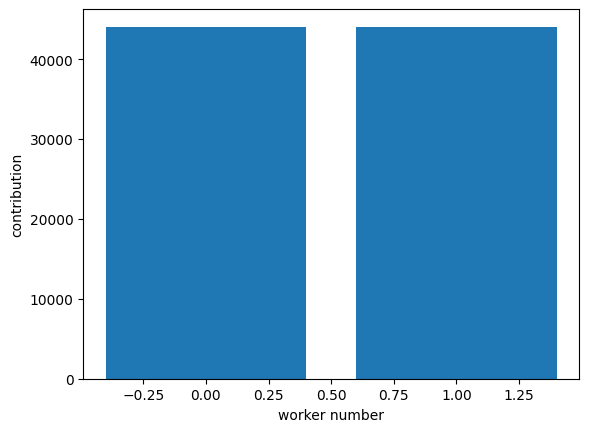

Epoch [141/200] Batch 0/625                 Loss D: 0.2790, loss G: 0.2689, FID Score: 242.0
Epoch [141/200] Batch 100/625                 Loss D: 0.2674, loss G: 0.2785, FID Score: 245.4
Epoch [141/200] Batch 200/625                 Loss D: 0.2630, loss G: 0.3705, FID Score: 229.9
Epoch [141/200] Batch 300/625                 Loss D: 0.2643, loss G: 0.2714, FID Score: 225.9
Epoch [141/200] Batch 400/625                 Loss D: 0.2518, loss G: 0.2649, FID Score: 239.1
Epoch [141/200] Batch 500/625                 Loss D: 0.2999, loss G: 0.2393, FID Score: 232.8
Epoch [141/200] Batch 600/625                 Loss D: 0.2632, loss G: 0.3141, FID Score: 235.8
Epoch [142/200] Batch 0/625                 Loss D: 0.2931, loss G: 0.2786, FID Score: 236.3
Epoch [142/200] Batch 100/625                 Loss D: 0.2676, loss G: 0.2838, FID Score: 234.0
Epoch [142/200] Batch 200/625                 Loss D: 0.2624, loss G: 0.3004, FID Score: 231.3
Epoch [142/200] Batch 300/625                 Loss D: 

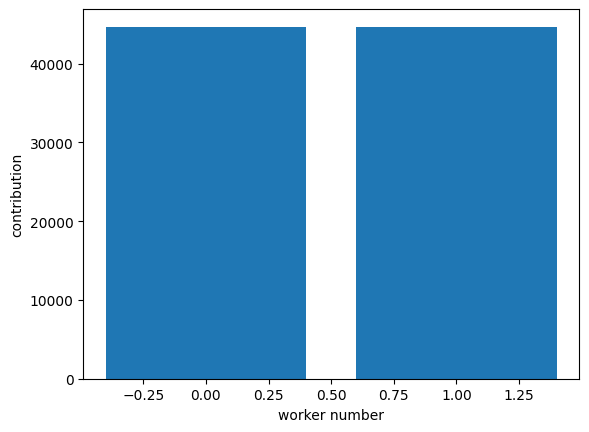

Epoch [143/200] Batch 0/625                 Loss D: 0.2978, loss G: 0.2602, FID Score: 238.2
Epoch [143/200] Batch 100/625                 Loss D: 0.2660, loss G: 0.2973, FID Score: 221.6
Epoch [143/200] Batch 200/625                 Loss D: 0.2649, loss G: 0.2983, FID Score: 246.5
Epoch [143/200] Batch 300/625                 Loss D: 0.2766, loss G: 0.2978, FID Score: 236.7
Epoch [143/200] Batch 400/625                 Loss D: 0.2610, loss G: 0.2724, FID Score: 232.1
Epoch [143/200] Batch 500/625                 Loss D: 0.2701, loss G: 0.3256, FID Score: 236.0
Epoch [143/200] Batch 600/625                 Loss D: 0.2676, loss G: 0.2842, FID Score: 244.6
Epoch [144/200] Batch 0/625                 Loss D: 0.2851, loss G: 0.3163, FID Score: 236.6
Epoch [144/200] Batch 100/625                 Loss D: 0.2718, loss G: 0.2829, FID Score: 221.9
Epoch [144/200] Batch 200/625                 Loss D: 0.2744, loss G: 0.2913, FID Score: 226.8
Epoch [144/200] Batch 300/625                 Loss D: 

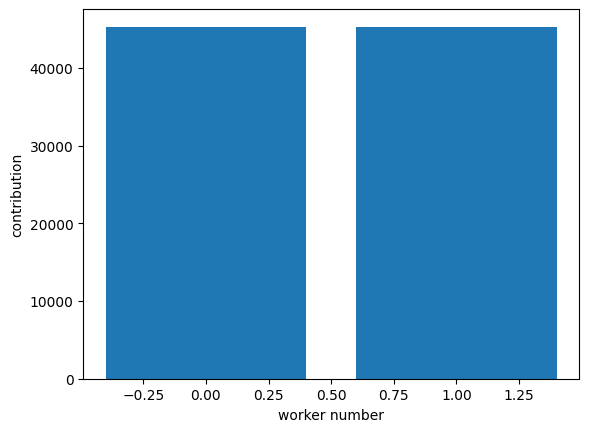

Epoch [145/200] Batch 0/625                 Loss D: 0.3008, loss G: 0.2855, FID Score: 228.2
Epoch [145/200] Batch 100/625                 Loss D: 0.2658, loss G: 0.3043, FID Score: 236.3
Epoch [145/200] Batch 200/625                 Loss D: 0.2747, loss G: 0.3065, FID Score: 245.5
Epoch [145/200] Batch 300/625                 Loss D: 0.2614, loss G: 0.2731, FID Score: 234.3
Epoch [145/200] Batch 400/625                 Loss D: 0.2552, loss G: 0.2895, FID Score: 238.9
Epoch [145/200] Batch 500/625                 Loss D: 0.2835, loss G: 0.3317, FID Score: 230.9
Epoch [145/200] Batch 600/625                 Loss D: 0.2796, loss G: 0.2834, FID Score: 242.7
Epoch [146/200] Batch 0/625                 Loss D: 0.3002, loss G: 0.2596, FID Score: 240.5
Epoch [146/200] Batch 100/625                 Loss D: 0.2645, loss G: 0.2454, FID Score: 242.3
Epoch [146/200] Batch 200/625                 Loss D: 0.2778, loss G: 0.3184, FID Score: 224.9
Epoch [146/200] Batch 300/625                 Loss D: 

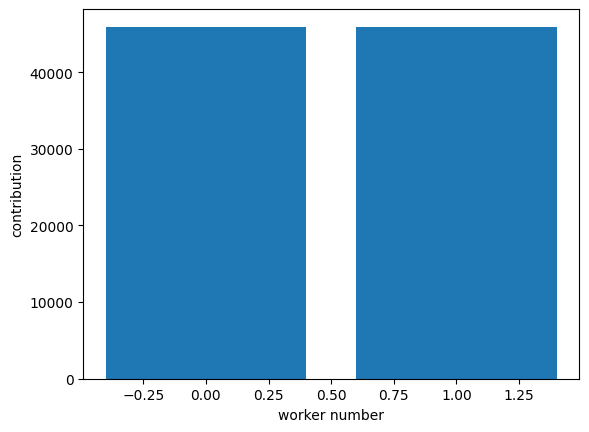

Epoch [147/200] Batch 0/625                 Loss D: 0.2962, loss G: 0.2375, FID Score: 226.0
Epoch [147/200] Batch 100/625                 Loss D: 0.2619, loss G: 0.3200, FID Score: 236.5
Epoch [147/200] Batch 200/625                 Loss D: 0.2832, loss G: 0.2615, FID Score: 240.5
Epoch [147/200] Batch 300/625                 Loss D: 0.2913, loss G: 0.2978, FID Score: 227.0
Epoch [147/200] Batch 400/625                 Loss D: 0.2583, loss G: 0.3041, FID Score: 240.0
Epoch [147/200] Batch 500/625                 Loss D: 0.2915, loss G: 0.2949, FID Score: 227.7
Epoch [147/200] Batch 600/625                 Loss D: 0.2561, loss G: 0.2907, FID Score: 233.5
Epoch [148/200] Batch 0/625                 Loss D: 0.2915, loss G: 0.2557, FID Score: 231.2
Epoch [148/200] Batch 100/625                 Loss D: 0.2676, loss G: 0.3025, FID Score: 227.6
Epoch [148/200] Batch 200/625                 Loss D: 0.2755, loss G: 0.3102, FID Score: 244.9
Epoch [148/200] Batch 300/625                 Loss D: 

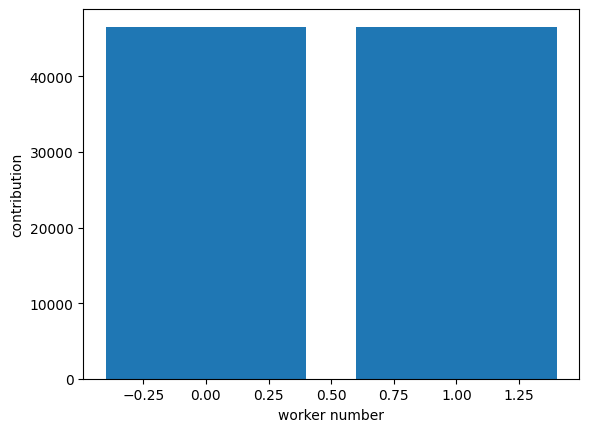

Epoch [149/200] Batch 0/625                 Loss D: 0.2881, loss G: 0.3051, FID Score: 219.6
Epoch [149/200] Batch 100/625                 Loss D: 0.2712, loss G: 0.3910, FID Score: 231.9
Epoch [149/200] Batch 200/625                 Loss D: 0.2660, loss G: 0.3038, FID Score: 248.9
Epoch [149/200] Batch 300/625                 Loss D: 0.2633, loss G: 0.2666, FID Score: 238.9
Epoch [149/200] Batch 400/625                 Loss D: 0.2529, loss G: 0.3118, FID Score: 224.8
Epoch [149/200] Batch 500/625                 Loss D: 0.2798, loss G: 0.2959, FID Score: 233.2
Epoch [149/200] Batch 600/625                 Loss D: 0.2644, loss G: 0.2722, FID Score: 224.7
Epoch [150/200] Batch 0/625                 Loss D: 0.2947, loss G: 0.2818, FID Score: 228.7
Epoch [150/200] Batch 100/625                 Loss D: 0.2489, loss G: 0.3175, FID Score: 238.2
Epoch [150/200] Batch 200/625                 Loss D: 0.2677, loss G: 0.3047, FID Score: 234.7
Epoch [150/200] Batch 300/625                 Loss D: 

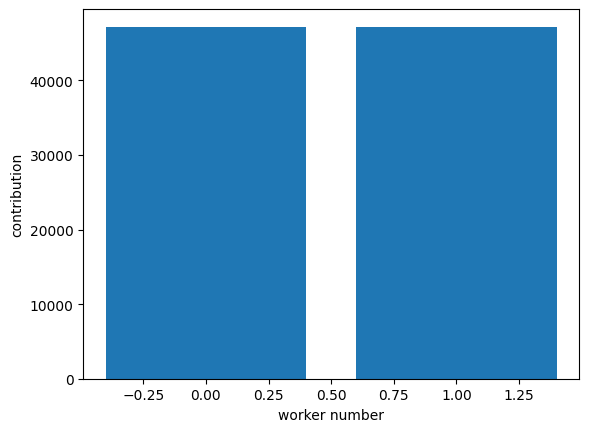

Epoch [151/200] Batch 0/625                 Loss D: 0.2903, loss G: 0.2809, FID Score: 247.4
Epoch [151/200] Batch 100/625                 Loss D: 0.2704, loss G: 0.3167, FID Score: 224.4
Epoch [151/200] Batch 200/625                 Loss D: 0.2754, loss G: 0.2910, FID Score: 237.7
Epoch [151/200] Batch 300/625                 Loss D: 0.2728, loss G: 0.2768, FID Score: 241.3
Epoch [151/200] Batch 400/625                 Loss D: 0.2534, loss G: 0.3293, FID Score: 219.6
Epoch [151/200] Batch 500/625                 Loss D: 0.2935, loss G: 0.3131, FID Score: 235.3
Epoch [151/200] Batch 600/625                 Loss D: 0.2659, loss G: 0.2758, FID Score: 228.6
Epoch [152/200] Batch 0/625                 Loss D: 0.2822, loss G: 0.2663, FID Score: 235.7
Epoch [152/200] Batch 100/625                 Loss D: 0.2620, loss G: 0.3202, FID Score: 244.8
Epoch [152/200] Batch 200/625                 Loss D: 0.2778, loss G: 0.2601, FID Score: 233.8
Epoch [152/200] Batch 300/625                 Loss D: 

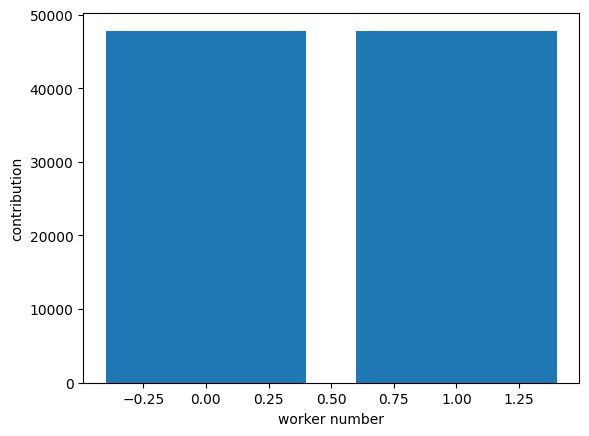

Epoch [153/200] Batch 0/625                 Loss D: 0.3007, loss G: 0.2635, FID Score: 236.5
Epoch [153/200] Batch 100/625                 Loss D: 0.2720, loss G: 0.3037, FID Score: 223.1
Epoch [153/200] Batch 200/625                 Loss D: 0.2723, loss G: 0.2890, FID Score: 248.3
Epoch [153/200] Batch 300/625                 Loss D: 0.2427, loss G: 0.2500, FID Score: 209.6
Epoch [153/200] Batch 400/625                 Loss D: 0.2633, loss G: 0.2722, FID Score: 236.5
Epoch [153/200] Batch 500/625                 Loss D: 0.2867, loss G: 0.2697, FID Score: 227.7
Epoch [153/200] Batch 600/625                 Loss D: 0.2699, loss G: 0.2394, FID Score: 231.6
Epoch [154/200] Batch 0/625                 Loss D: 0.2696, loss G: 0.2695, FID Score: 228.0
Epoch [154/200] Batch 100/625                 Loss D: 0.2686, loss G: 0.2763, FID Score: 232.0
Epoch [154/200] Batch 200/625                 Loss D: 0.2777, loss G: 0.2709, FID Score: 237.7
Epoch [154/200] Batch 300/625                 Loss D: 

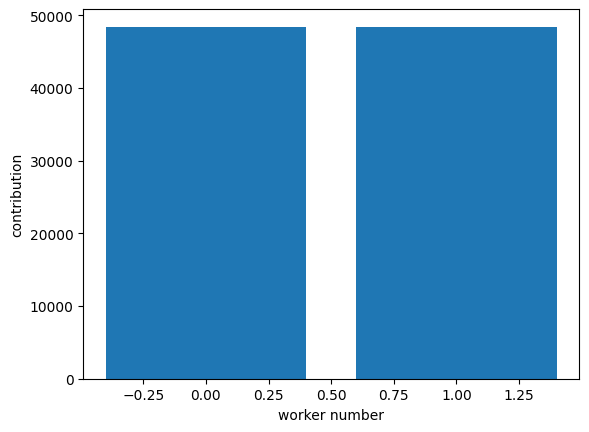

Epoch [155/200] Batch 0/625                 Loss D: 0.2933, loss G: 0.2338, FID Score: 239.9
Epoch [155/200] Batch 100/625                 Loss D: 0.2516, loss G: 0.2522, FID Score: 238.3
Epoch [155/200] Batch 200/625                 Loss D: 0.2812, loss G: 0.2611, FID Score: 235.1
Epoch [155/200] Batch 300/625                 Loss D: 0.2775, loss G: 0.2829, FID Score: 229.9
Epoch [155/200] Batch 400/625                 Loss D: 0.2636, loss G: 0.2745, FID Score: 243.6
Epoch [155/200] Batch 500/625                 Loss D: 0.2927, loss G: 0.3133, FID Score: 225.8
Epoch [155/200] Batch 600/625                 Loss D: 0.2555, loss G: 0.3175, FID Score: 234.3
Epoch [156/200] Batch 0/625                 Loss D: 0.2908, loss G: 0.2280, FID Score: 229.0
Epoch [156/200] Batch 100/625                 Loss D: 0.2624, loss G: 0.2335, FID Score: 237.8
Epoch [156/200] Batch 200/625                 Loss D: 0.2704, loss G: 0.3171, FID Score: 238.1
Epoch [156/200] Batch 300/625                 Loss D: 

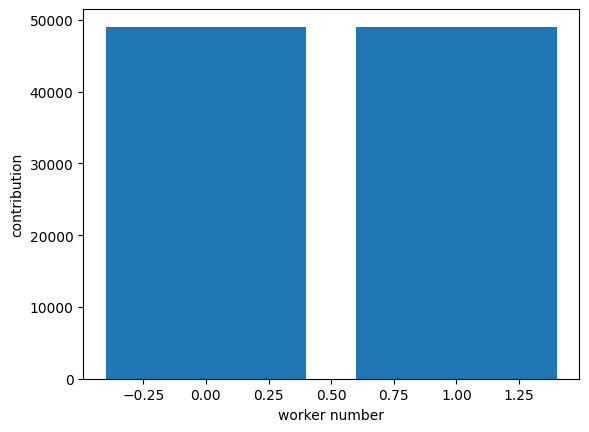

Epoch [157/200] Batch 0/625                 Loss D: 0.3065, loss G: 0.2404, FID Score: 232.9
Epoch [157/200] Batch 100/625                 Loss D: 0.2468, loss G: 0.2819, FID Score: 238.9
Epoch [157/200] Batch 200/625                 Loss D: 0.2701, loss G: 0.3341, FID Score: 234.0
Epoch [157/200] Batch 300/625                 Loss D: 0.2676, loss G: 0.2958, FID Score: 234.8
Epoch [157/200] Batch 400/625                 Loss D: 0.2635, loss G: 0.2626, FID Score: 240.6
Epoch [157/200] Batch 500/625                 Loss D: 0.2763, loss G: 0.2974, FID Score: 234.5
Epoch [157/200] Batch 600/625                 Loss D: 0.2616, loss G: 0.2921, FID Score: 235.1
Epoch [158/200] Batch 0/625                 Loss D: 0.2813, loss G: 0.2624, FID Score: 232.6
Epoch [158/200] Batch 100/625                 Loss D: 0.2753, loss G: 0.2951, FID Score: 232.6
Epoch [158/200] Batch 200/625                 Loss D: 0.2836, loss G: 0.3177, FID Score: 233.3
Epoch [158/200] Batch 300/625                 Loss D: 

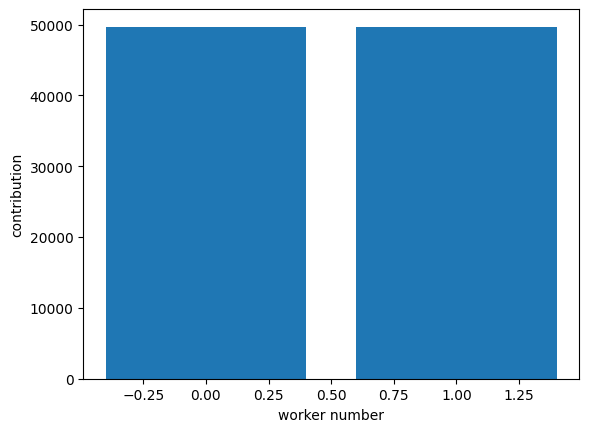

Epoch [159/200] Batch 0/625                 Loss D: 0.2983, loss G: 0.2388, FID Score: 233.1
Epoch [159/200] Batch 100/625                 Loss D: 0.2681, loss G: 0.3148, FID Score: 228.9
Epoch [159/200] Batch 200/625                 Loss D: 0.2998, loss G: 0.3151, FID Score: 240.5
Epoch [159/200] Batch 300/625                 Loss D: 0.2728, loss G: 0.2825, FID Score: 221.3
Epoch [159/200] Batch 400/625                 Loss D: 0.2726, loss G: 0.2718, FID Score: 238.6
Epoch [159/200] Batch 500/625                 Loss D: 0.2787, loss G: 0.2957, FID Score: 236.2
Epoch [159/200] Batch 600/625                 Loss D: 0.2661, loss G: 0.2770, FID Score: 235.6
Epoch [160/200] Batch 0/625                 Loss D: 0.2764, loss G: 0.2673, FID Score: 224.0
Epoch [160/200] Batch 100/625                 Loss D: 0.2740, loss G: 0.2774, FID Score: 226.6
Epoch [160/200] Batch 200/625                 Loss D: 0.2744, loss G: 0.3206, FID Score: 233.2
Epoch [160/200] Batch 300/625                 Loss D: 

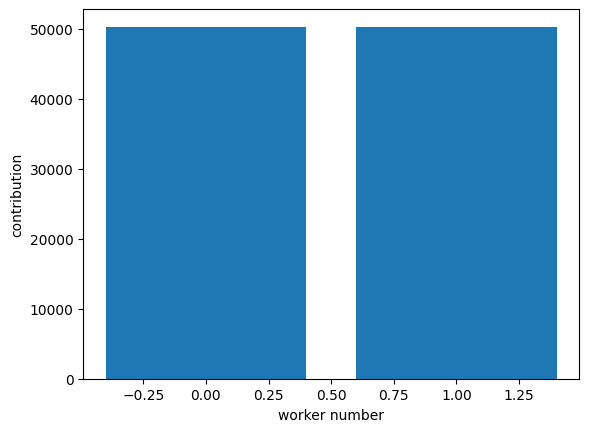

Epoch [161/200] Batch 0/625                 Loss D: 0.2738, loss G: 0.2854, FID Score: 238.5
Epoch [161/200] Batch 100/625                 Loss D: 0.2619, loss G: 0.3055, FID Score: 240.2
Epoch [161/200] Batch 200/625                 Loss D: 0.2879, loss G: 0.2641, FID Score: 233.6
Epoch [161/200] Batch 300/625                 Loss D: 0.2645, loss G: 0.2632, FID Score: 238.1
Epoch [161/200] Batch 400/625                 Loss D: 0.2730, loss G: 0.2362, FID Score: 235.5
Epoch [161/200] Batch 500/625                 Loss D: 0.2886, loss G: 0.3077, FID Score: 233.6
Epoch [161/200] Batch 600/625                 Loss D: 0.2730, loss G: 0.2506, FID Score: 237.2
Epoch [162/200] Batch 0/625                 Loss D: 0.2930, loss G: 0.2525, FID Score: 239.5
Epoch [162/200] Batch 100/625                 Loss D: 0.2557, loss G: 0.3074, FID Score: 234.1
Epoch [162/200] Batch 200/625                 Loss D: 0.2789, loss G: 0.3187, FID Score: 236.2
Epoch [162/200] Batch 300/625                 Loss D: 

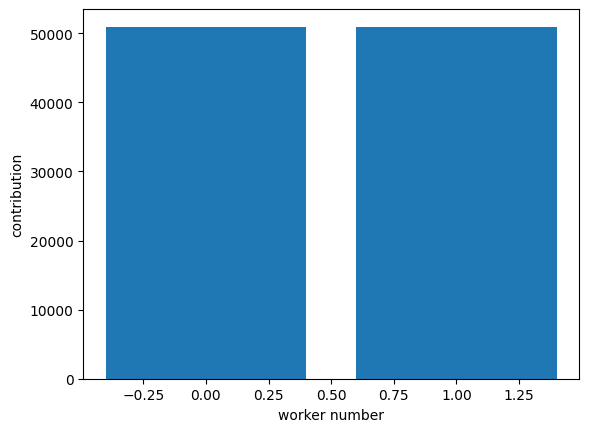

Epoch [163/200] Batch 0/625                 Loss D: 0.2852, loss G: 0.2559, FID Score: 230.1
Epoch [163/200] Batch 100/625                 Loss D: 0.2682, loss G: 0.2545, FID Score: 226.5
Epoch [163/200] Batch 200/625                 Loss D: 0.2736, loss G: 0.3259, FID Score: 228.7
Epoch [163/200] Batch 300/625                 Loss D: 0.2790, loss G: 0.2429, FID Score: 225.1
Epoch [163/200] Batch 400/625                 Loss D: 0.2609, loss G: 0.2750, FID Score: 230.1
Epoch [163/200] Batch 500/625                 Loss D: 0.2782, loss G: 0.2628, FID Score: 238.6
Epoch [163/200] Batch 600/625                 Loss D: 0.2729, loss G: 0.2532, FID Score: 237.6
Epoch [164/200] Batch 0/625                 Loss D: 0.2970, loss G: 0.3481, FID Score: 225.1
Epoch [164/200] Batch 100/625                 Loss D: 0.2656, loss G: 0.2926, FID Score: 230.7
Epoch [164/200] Batch 200/625                 Loss D: 0.2800, loss G: 0.2871, FID Score: 230.1
Epoch [164/200] Batch 300/625                 Loss D: 

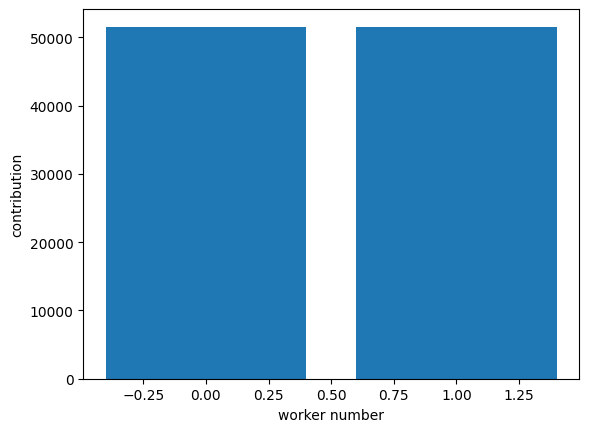

Epoch [165/200] Batch 0/625                 Loss D: 0.2824, loss G: 0.3029, FID Score: 242.0
Epoch [165/200] Batch 100/625                 Loss D: 0.2690, loss G: 0.2580, FID Score: 235.3
Epoch [165/200] Batch 200/625                 Loss D: 0.2784, loss G: 0.3617, FID Score: 244.9
Epoch [165/200] Batch 300/625                 Loss D: 0.2531, loss G: 0.3210, FID Score: 232.7
Epoch [165/200] Batch 400/625                 Loss D: 0.2806, loss G: 0.2761, FID Score: 236.3
Epoch [165/200] Batch 500/625                 Loss D: 0.2845, loss G: 0.3051, FID Score: 241.8
Epoch [165/200] Batch 600/625                 Loss D: 0.2753, loss G: 0.2676, FID Score: 240.4
Epoch [166/200] Batch 0/625                 Loss D: 0.2836, loss G: 0.2768, FID Score: 232.5
Epoch [166/200] Batch 100/625                 Loss D: 0.2836, loss G: 0.2655, FID Score: 230.1
Epoch [166/200] Batch 200/625                 Loss D: 0.2784, loss G: 0.2965, FID Score: 233.9
Epoch [166/200] Batch 300/625                 Loss D: 

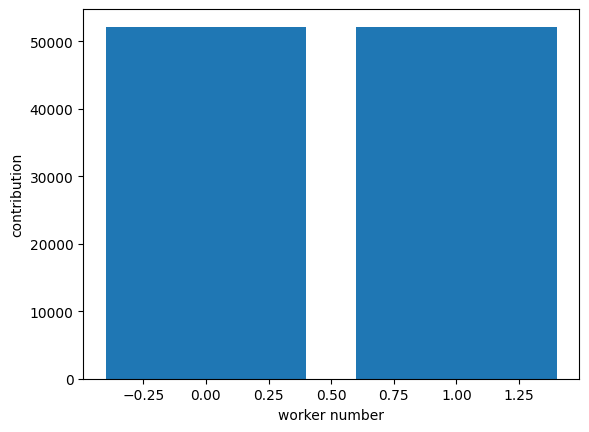

Epoch [167/200] Batch 0/625                 Loss D: 0.2907, loss G: 0.2754, FID Score: 226.3
Epoch [167/200] Batch 100/625                 Loss D: 0.2642, loss G: 0.3258, FID Score: 233.8
Epoch [167/200] Batch 200/625                 Loss D: 0.2804, loss G: 0.2830, FID Score: 240.7
Epoch [167/200] Batch 300/625                 Loss D: 0.2714, loss G: 0.2712, FID Score: 232.2
Epoch [167/200] Batch 400/625                 Loss D: 0.2512, loss G: 0.2923, FID Score: 250.7
Epoch [167/200] Batch 500/625                 Loss D: 0.2788, loss G: 0.2833, FID Score: 228.4
Epoch [167/200] Batch 600/625                 Loss D: 0.2667, loss G: 0.2900, FID Score: 229.9
Epoch [168/200] Batch 0/625                 Loss D: 0.2988, loss G: 0.3015, FID Score: 233.8
Epoch [168/200] Batch 100/625                 Loss D: 0.2694, loss G: 0.2882, FID Score: 235.5
Epoch [168/200] Batch 200/625                 Loss D: 0.2949, loss G: 0.3433, FID Score: 239.7
Epoch [168/200] Batch 300/625                 Loss D: 

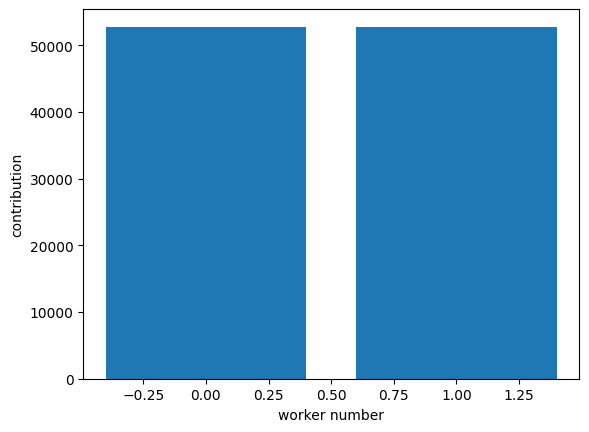

Epoch [169/200] Batch 0/625                 Loss D: 0.2891, loss G: 0.2900, FID Score: 237.4
Epoch [169/200] Batch 100/625                 Loss D: 0.2603, loss G: 0.2720, FID Score: 229.0
Epoch [169/200] Batch 200/625                 Loss D: 0.2838, loss G: 0.2953, FID Score: 252.3
Epoch [169/200] Batch 300/625                 Loss D: 0.2642, loss G: 0.2900, FID Score: 221.3
Epoch [169/200] Batch 400/625                 Loss D: 0.2681, loss G: 0.2787, FID Score: 230.8
Epoch [169/200] Batch 500/625                 Loss D: 0.2776, loss G: 0.2901, FID Score: 236.5
Epoch [169/200] Batch 600/625                 Loss D: 0.2845, loss G: 0.3113, FID Score: 244.6
Epoch [170/200] Batch 0/625                 Loss D: 0.2787, loss G: 0.2700, FID Score: 229.4
Epoch [170/200] Batch 100/625                 Loss D: 0.2743, loss G: 0.2768, FID Score: 220.5
Epoch [170/200] Batch 200/625                 Loss D: 0.2655, loss G: 0.2839, FID Score: 236.4
Epoch [170/200] Batch 300/625                 Loss D: 

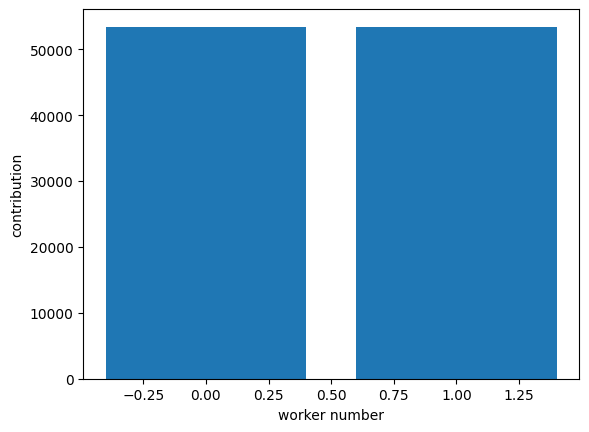

Epoch [171/200] Batch 0/625                 Loss D: 0.3076, loss G: 0.2575, FID Score: 246.6
Epoch [171/200] Batch 100/625                 Loss D: 0.2566, loss G: 0.3041, FID Score: 240.6
Epoch [171/200] Batch 200/625                 Loss D: 0.2860, loss G: 0.3267, FID Score: 242.0
Epoch [171/200] Batch 300/625                 Loss D: 0.2718, loss G: 0.2747, FID Score: 235.6
Epoch [171/200] Batch 400/625                 Loss D: 0.2708, loss G: 0.3124, FID Score: 232.4
Epoch [171/200] Batch 500/625                 Loss D: 0.2726, loss G: 0.3158, FID Score: 225.5
Epoch [171/200] Batch 600/625                 Loss D: 0.2652, loss G: 0.2586, FID Score: 244.7
Epoch [172/200] Batch 0/625                 Loss D: 0.2818, loss G: 0.2768, FID Score: 228.0
Epoch [172/200] Batch 100/625                 Loss D: 0.2788, loss G: 0.2485, FID Score: 229.7
Epoch [172/200] Batch 200/625                 Loss D: 0.2722, loss G: 0.3269, FID Score: 240.0
Epoch [172/200] Batch 300/625                 Loss D: 

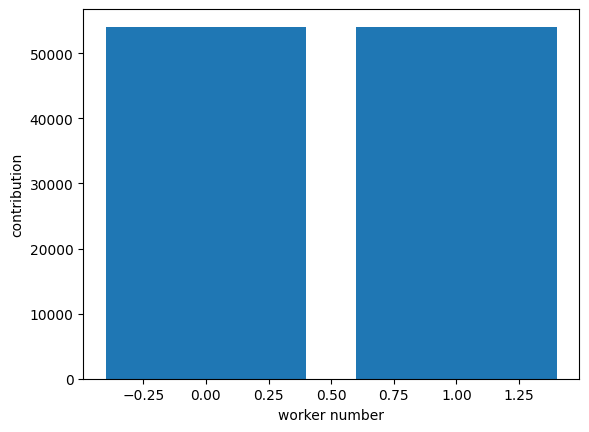

Epoch [173/200] Batch 0/625                 Loss D: 0.2766, loss G: 0.3044, FID Score: 236.5
Epoch [173/200] Batch 100/625                 Loss D: 0.2619, loss G: 0.2705, FID Score: 229.7
Epoch [173/200] Batch 200/625                 Loss D: 0.2708, loss G: 0.2696, FID Score: 236.6
Epoch [173/200] Batch 300/625                 Loss D: 0.2740, loss G: 0.2701, FID Score: 232.3
Epoch [173/200] Batch 400/625                 Loss D: 0.2778, loss G: 0.2537, FID Score: 220.0
Epoch [173/200] Batch 500/625                 Loss D: 0.2816, loss G: 0.2695, FID Score: 229.6
Epoch [173/200] Batch 600/625                 Loss D: 0.2623, loss G: 0.2856, FID Score: 236.1
Epoch [174/200] Batch 0/625                 Loss D: 0.2830, loss G: 0.2789, FID Score: 238.1
Epoch [174/200] Batch 100/625                 Loss D: 0.2616, loss G: 0.2843, FID Score: 245.4
Epoch [174/200] Batch 200/625                 Loss D: 0.2860, loss G: 0.3030, FID Score: 236.9
Epoch [174/200] Batch 300/625                 Loss D: 

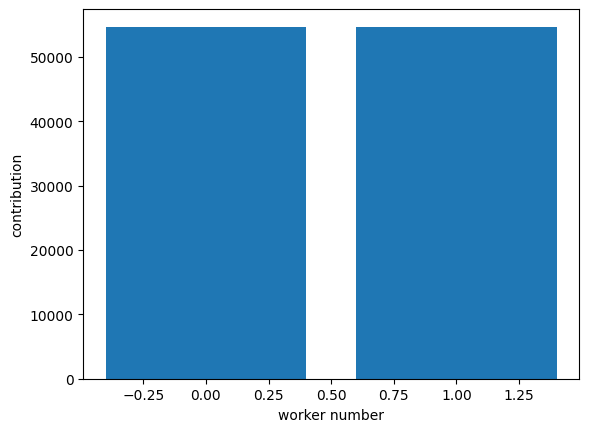

Epoch [175/200] Batch 0/625                 Loss D: 0.2871, loss G: 0.2436, FID Score: 237.0
Epoch [175/200] Batch 100/625                 Loss D: 0.2578, loss G: 0.2554, FID Score: 222.4
Epoch [175/200] Batch 200/625                 Loss D: 0.2871, loss G: 0.3131, FID Score: 249.3
Epoch [175/200] Batch 300/625                 Loss D: 0.2715, loss G: 0.2711, FID Score: 234.4
Epoch [175/200] Batch 400/625                 Loss D: 0.2814, loss G: 0.2933, FID Score: 241.9
Epoch [175/200] Batch 500/625                 Loss D: 0.2687, loss G: 0.2674, FID Score: 240.2
Epoch [175/200] Batch 600/625                 Loss D: 0.2679, loss G: 0.2913, FID Score: 228.3
Epoch [176/200] Batch 0/625                 Loss D: 0.2940, loss G: 0.2633, FID Score: 234.3
Epoch [176/200] Batch 100/625                 Loss D: 0.2701, loss G: 0.2873, FID Score: 231.5
Epoch [176/200] Batch 200/625                 Loss D: 0.2866, loss G: 0.3353, FID Score: 233.8
Epoch [176/200] Batch 300/625                 Loss D: 

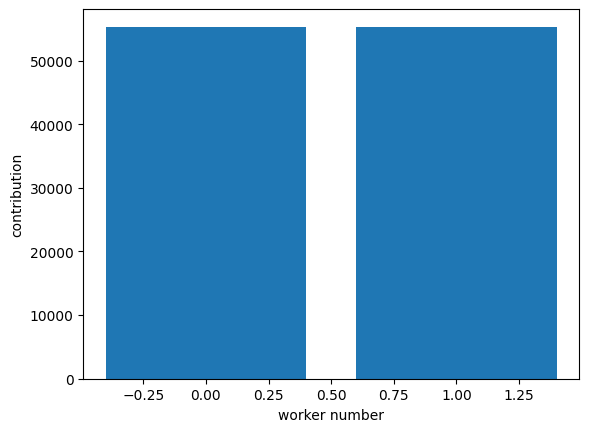

Epoch [177/200] Batch 0/625                 Loss D: 0.2893, loss G: 0.2453, FID Score: 240.0
Epoch [177/200] Batch 100/625                 Loss D: 0.2664, loss G: 0.2484, FID Score: 227.3
Epoch [177/200] Batch 200/625                 Loss D: 0.2737, loss G: 0.2864, FID Score: 233.5
Epoch [177/200] Batch 300/625                 Loss D: 0.2673, loss G: 0.2962, FID Score: 248.6
Epoch [177/200] Batch 400/625                 Loss D: 0.2843, loss G: 0.2783, FID Score: 234.4
Epoch [177/200] Batch 500/625                 Loss D: 0.2854, loss G: 0.3079, FID Score: 237.6
Epoch [177/200] Batch 600/625                 Loss D: 0.2705, loss G: 0.2484, FID Score: 215.8
Epoch [178/200] Batch 0/625                 Loss D: 0.2834, loss G: 0.2559, FID Score: 234.8
Epoch [178/200] Batch 100/625                 Loss D: 0.2574, loss G: 0.2867, FID Score: 244.0
Epoch [178/200] Batch 200/625                 Loss D: 0.2882, loss G: 0.2915, FID Score: 238.2
Epoch [178/200] Batch 300/625                 Loss D: 

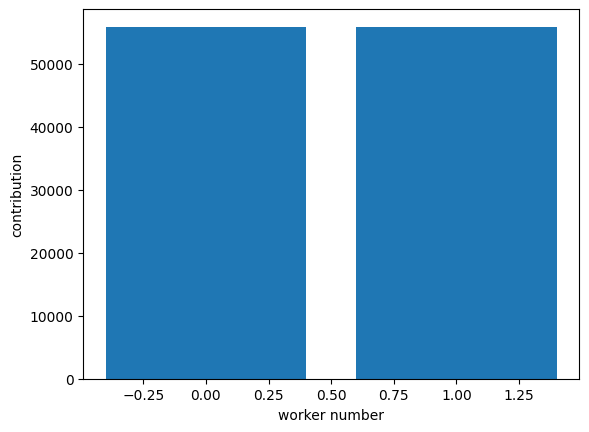

Epoch [179/200] Batch 0/625                 Loss D: 0.2755, loss G: 0.2451, FID Score: 250.1
Epoch [179/200] Batch 100/625                 Loss D: 0.2698, loss G: 0.2657, FID Score: 232.5
Epoch [179/200] Batch 200/625                 Loss D: 0.2766, loss G: 0.2908, FID Score: 237.6
Epoch [179/200] Batch 300/625                 Loss D: 0.2669, loss G: 0.2904, FID Score: 243.0
Epoch [179/200] Batch 400/625                 Loss D: 0.2459, loss G: 0.2564, FID Score: 237.0
Epoch [179/200] Batch 500/625                 Loss D: 0.2821, loss G: 0.2716, FID Score: 240.9
Epoch [179/200] Batch 600/625                 Loss D: 0.2740, loss G: 0.2638, FID Score: 213.5
Epoch [180/200] Batch 0/625                 Loss D: 0.2735, loss G: 0.2469, FID Score: 250.9
Epoch [180/200] Batch 100/625                 Loss D: 0.2609, loss G: 0.2573, FID Score: 229.4
Epoch [180/200] Batch 200/625                 Loss D: 0.2833, loss G: 0.3433, FID Score: 229.1
Epoch [180/200] Batch 300/625                 Loss D: 

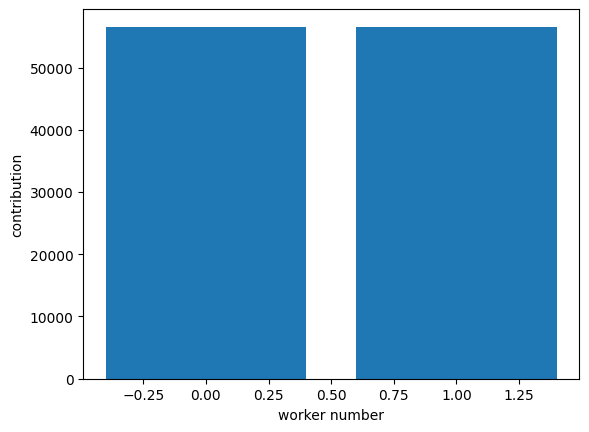

Epoch [181/200] Batch 0/625                 Loss D: 0.2785, loss G: 0.2929, FID Score: 236.9
Epoch [181/200] Batch 100/625                 Loss D: 0.2668, loss G: 0.2682, FID Score: 238.6
Epoch [181/200] Batch 200/625                 Loss D: 0.2728, loss G: 0.3195, FID Score: 237.3
Epoch [181/200] Batch 300/625                 Loss D: 0.2832, loss G: 0.2434, FID Score: 222.9
Epoch [181/200] Batch 400/625                 Loss D: 0.2801, loss G: 0.2746, FID Score: 243.0
Epoch [181/200] Batch 500/625                 Loss D: 0.2947, loss G: 0.2792, FID Score: 236.0
Epoch [181/200] Batch 600/625                 Loss D: 0.2721, loss G: 0.2927, FID Score: 241.9
Epoch [182/200] Batch 0/625                 Loss D: 0.2876, loss G: 0.2574, FID Score: 229.2
Epoch [182/200] Batch 100/625                 Loss D: 0.2724, loss G: 0.2720, FID Score: 244.4
Epoch [182/200] Batch 200/625                 Loss D: 0.2759, loss G: 0.2722, FID Score: 222.7
Epoch [182/200] Batch 300/625                 Loss D: 

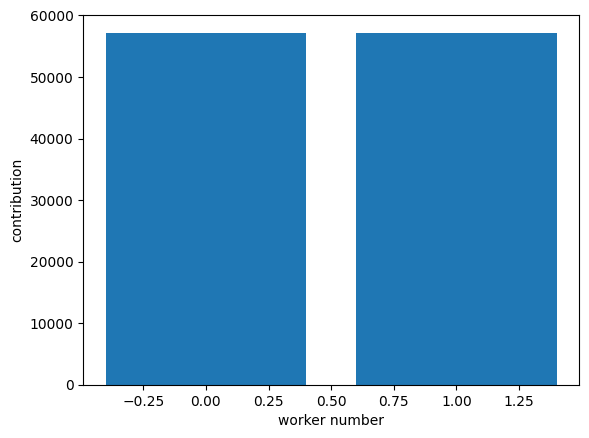

Epoch [183/200] Batch 0/625                 Loss D: 0.2921, loss G: 0.2764, FID Score: 249.8
Epoch [183/200] Batch 100/625                 Loss D: 0.2495, loss G: 0.2482, FID Score: 244.5
Epoch [183/200] Batch 200/625                 Loss D: 0.2701, loss G: 0.2928, FID Score: 250.0
Epoch [183/200] Batch 300/625                 Loss D: 0.2583, loss G: 0.2791, FID Score: 225.1
Epoch [183/200] Batch 400/625                 Loss D: 0.2870, loss G: 0.2966, FID Score: 245.4
Epoch [183/200] Batch 500/625                 Loss D: 0.2842, loss G: 0.2984, FID Score: 225.4
Epoch [183/200] Batch 600/625                 Loss D: 0.2721, loss G: 0.2937, FID Score: 237.0
Epoch [184/200] Batch 0/625                 Loss D: 0.2987, loss G: 0.3220, FID Score: 241.6
Epoch [184/200] Batch 100/625                 Loss D: 0.2617, loss G: 0.2662, FID Score: 249.9
Epoch [184/200] Batch 200/625                 Loss D: 0.2732, loss G: 0.2713, FID Score: 246.2
Epoch [184/200] Batch 300/625                 Loss D: 

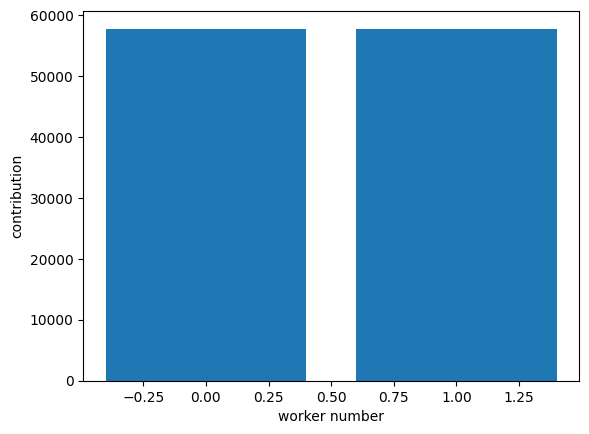

Epoch [185/200] Batch 0/625                 Loss D: 0.2829, loss G: 0.2771, FID Score: 245.4
Epoch [185/200] Batch 100/625                 Loss D: 0.2710, loss G: 0.2633, FID Score: 234.7
Epoch [185/200] Batch 200/625                 Loss D: 0.2881, loss G: 0.2964, FID Score: 232.5
Epoch [185/200] Batch 300/625                 Loss D: 0.2752, loss G: 0.2962, FID Score: 220.9
Epoch [185/200] Batch 400/625                 Loss D: 0.2742, loss G: 0.2851, FID Score: 233.5
Epoch [185/200] Batch 500/625                 Loss D: 0.2802, loss G: 0.2799, FID Score: 242.3
Epoch [185/200] Batch 600/625                 Loss D: 0.2595, loss G: 0.2877, FID Score: 230.5
Epoch [186/200] Batch 0/625                 Loss D: 0.2883, loss G: 0.2928, FID Score: 246.5
Epoch [186/200] Batch 100/625                 Loss D: 0.2475, loss G: 0.2825, FID Score: 241.9
Epoch [186/200] Batch 200/625                 Loss D: 0.2797, loss G: 0.2977, FID Score: 246.2
Epoch [186/200] Batch 300/625                 Loss D: 

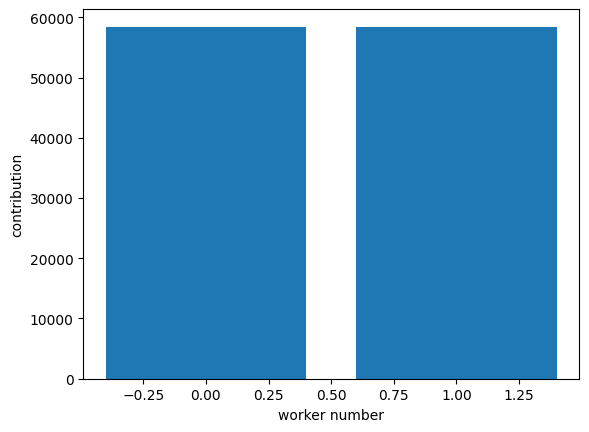

Epoch [187/200] Batch 0/625                 Loss D: 0.2937, loss G: 0.2852, FID Score: 227.0
Epoch [187/200] Batch 100/625                 Loss D: 0.2532, loss G: 0.2458, FID Score: 237.0
Epoch [187/200] Batch 200/625                 Loss D: 0.2808, loss G: 0.2768, FID Score: 228.5
Epoch [187/200] Batch 300/625                 Loss D: 0.2664, loss G: 0.2892, FID Score: 240.3
Epoch [187/200] Batch 400/625                 Loss D: 0.2754, loss G: 0.2613, FID Score: 236.0
Epoch [187/200] Batch 500/625                 Loss D: 0.2807, loss G: 0.3063, FID Score: 237.9
Epoch [187/200] Batch 600/625                 Loss D: 0.2697, loss G: 0.3058, FID Score: 229.1
Epoch [188/200] Batch 0/625                 Loss D: 0.2743, loss G: 0.2728, FID Score: 238.5
Epoch [188/200] Batch 100/625                 Loss D: 0.2707, loss G: 0.2418, FID Score: 233.7
Epoch [188/200] Batch 200/625                 Loss D: 0.2731, loss G: 0.2766, FID Score: 233.1
Epoch [188/200] Batch 300/625                 Loss D: 

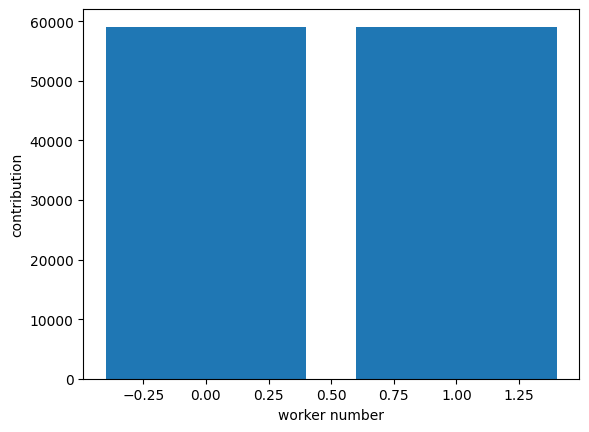

Epoch [189/200] Batch 0/625                 Loss D: 0.2875, loss G: 0.2523, FID Score: 234.7
Epoch [189/200] Batch 100/625                 Loss D: 0.2516, loss G: 0.2807, FID Score: 230.4
Epoch [189/200] Batch 200/625                 Loss D: 0.2759, loss G: 0.3006, FID Score: 230.6
Epoch [189/200] Batch 300/625                 Loss D: 0.2581, loss G: 0.2557, FID Score: 224.8
Epoch [189/200] Batch 400/625                 Loss D: 0.2606, loss G: 0.2660, FID Score: 233.8
Epoch [189/200] Batch 500/625                 Loss D: 0.2900, loss G: 0.2948, FID Score: 235.4
Epoch [189/200] Batch 600/625                 Loss D: 0.2754, loss G: 0.2866, FID Score: 246.8
Epoch [190/200] Batch 0/625                 Loss D: 0.2813, loss G: 0.2604, FID Score: 237.9
Epoch [190/200] Batch 100/625                 Loss D: 0.2613, loss G: 0.2680, FID Score: 234.6
Epoch [190/200] Batch 200/625                 Loss D: 0.2899, loss G: 0.3274, FID Score: 238.9
Epoch [190/200] Batch 300/625                 Loss D: 

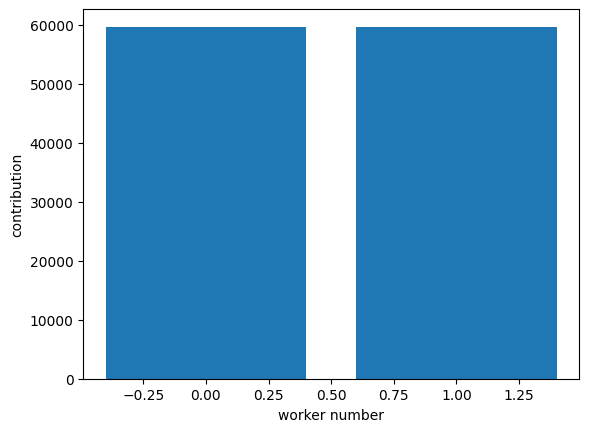

Epoch [191/200] Batch 0/625                 Loss D: 0.2733, loss G: 0.3011, FID Score: 232.0
Epoch [191/200] Batch 100/625                 Loss D: 0.2578, loss G: 0.2881, FID Score: 207.8
Epoch [191/200] Batch 200/625                 Loss D: 0.2852, loss G: 0.3378, FID Score: 247.1
Epoch [191/200] Batch 300/625                 Loss D: 0.2699, loss G: 0.2591, FID Score: 238.8
Epoch [191/200] Batch 400/625                 Loss D: 0.2636, loss G: 0.2716, FID Score: 237.1
Epoch [191/200] Batch 500/625                 Loss D: 0.2799, loss G: 0.2928, FID Score: 219.7
Epoch [191/200] Batch 600/625                 Loss D: 0.2873, loss G: 0.2707, FID Score: 238.0
Epoch [192/200] Batch 0/625                 Loss D: 0.2890, loss G: 0.2730, FID Score: 237.2
Epoch [192/200] Batch 100/625                 Loss D: 0.2722, loss G: 0.2690, FID Score: 226.3
Epoch [192/200] Batch 200/625                 Loss D: 0.2820, loss G: 0.3351, FID Score: 240.2
Epoch [192/200] Batch 300/625                 Loss D: 

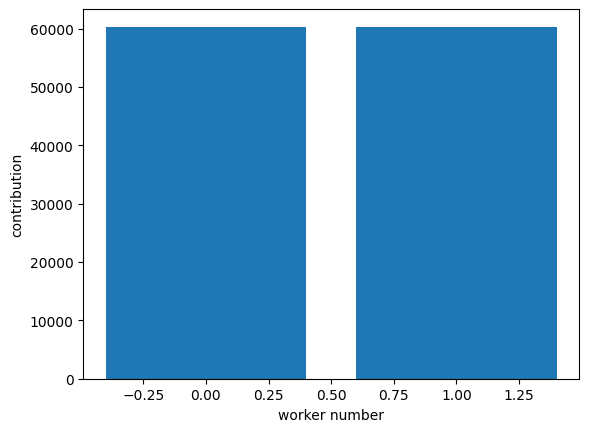

Epoch [193/200] Batch 0/625                 Loss D: 0.2886, loss G: 0.2615, FID Score: 227.4
Epoch [193/200] Batch 100/625                 Loss D: 0.2571, loss G: 0.2632, FID Score: 230.4
Epoch [193/200] Batch 200/625                 Loss D: 0.2848, loss G: 0.2982, FID Score: 225.0
Epoch [193/200] Batch 300/625                 Loss D: 0.2595, loss G: 0.2614, FID Score: 226.1
Epoch [193/200] Batch 400/625                 Loss D: 0.2606, loss G: 0.2476, FID Score: 232.8
Epoch [193/200] Batch 500/625                 Loss D: 0.2941, loss G: 0.2848, FID Score: 254.5
Epoch [193/200] Batch 600/625                 Loss D: 0.2793, loss G: 0.2764, FID Score: 230.8
Epoch [194/200] Batch 0/625                 Loss D: 0.2854, loss G: 0.2674, FID Score: 233.4
Epoch [194/200] Batch 100/625                 Loss D: 0.2691, loss G: 0.2609, FID Score: 235.5
Epoch [194/200] Batch 200/625                 Loss D: 0.2744, loss G: 0.2555, FID Score: 240.7
Epoch [194/200] Batch 300/625                 Loss D: 

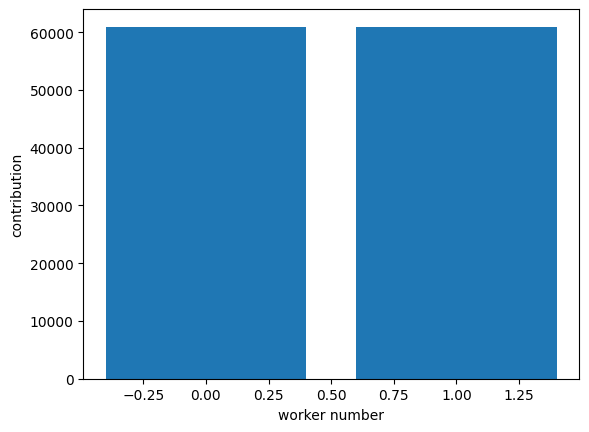

Epoch [195/200] Batch 0/625                 Loss D: 0.2739, loss G: 0.2609, FID Score: 246.8
Epoch [195/200] Batch 100/625                 Loss D: 0.2673, loss G: 0.2669, FID Score: 225.9
Epoch [195/200] Batch 200/625                 Loss D: 0.2792, loss G: 0.3004, FID Score: 221.8
Epoch [195/200] Batch 300/625                 Loss D: 0.2628, loss G: 0.2476, FID Score: 218.7
Epoch [195/200] Batch 400/625                 Loss D: 0.2660, loss G: 0.2512, FID Score: 241.3
Epoch [195/200] Batch 500/625                 Loss D: 0.2886, loss G: 0.2874, FID Score: 236.2
Epoch [195/200] Batch 600/625                 Loss D: 0.2746, loss G: 0.2964, FID Score: 237.7
Epoch [196/200] Batch 0/625                 Loss D: 0.2960, loss G: 0.2698, FID Score: 233.8
Epoch [196/200] Batch 100/625                 Loss D: 0.2628, loss G: 0.2915, FID Score: 248.3
Epoch [196/200] Batch 200/625                 Loss D: 0.2899, loss G: 0.3256, FID Score: 234.2
Epoch [196/200] Batch 300/625                 Loss D: 

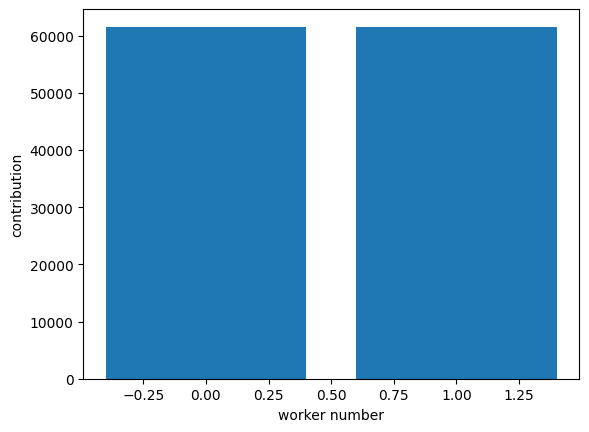

Epoch [197/200] Batch 0/625                 Loss D: 0.2845, loss G: 0.2935, FID Score: 225.0
Epoch [197/200] Batch 100/625                 Loss D: 0.2676, loss G: 0.2639, FID Score: 233.7
Epoch [197/200] Batch 200/625                 Loss D: 0.2705, loss G: 0.3056, FID Score: 237.1
Epoch [197/200] Batch 300/625                 Loss D: 0.2552, loss G: 0.2291, FID Score: 236.3
Epoch [197/200] Batch 400/625                 Loss D: 0.2832, loss G: 0.3276, FID Score: 241.1
Epoch [197/200] Batch 500/625                 Loss D: 0.2820, loss G: 0.2805, FID Score: 238.7
Epoch [197/200] Batch 600/625                 Loss D: 0.2847, loss G: 0.2692, FID Score: 235.9
Epoch [198/200] Batch 0/625                 Loss D: 0.2939, loss G: 0.2462, FID Score: 233.9
Epoch [198/200] Batch 100/625                 Loss D: 0.2659, loss G: 0.2669, FID Score: 242.9
Epoch [198/200] Batch 200/625                 Loss D: 0.2698, loss G: 0.3031, FID Score: 232.7
Epoch [198/200] Batch 300/625                 Loss D: 

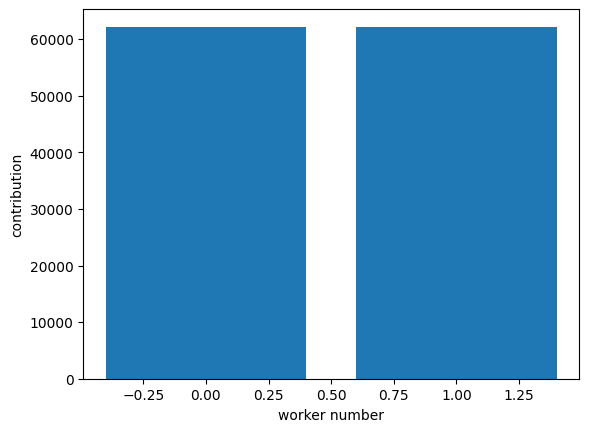

Epoch [199/200] Batch 0/625                 Loss D: 0.2826, loss G: 0.2551, FID Score: 226.5
Epoch [199/200] Batch 100/625                 Loss D: 0.2563, loss G: 0.2668, FID Score: 232.4
Epoch [199/200] Batch 200/625                 Loss D: 0.2764, loss G: 0.3139, FID Score: 241.3
Epoch [199/200] Batch 300/625                 Loss D: 0.2629, loss G: 0.2808, FID Score: 233.6
Epoch [199/200] Batch 400/625                 Loss D: 0.2636, loss G: 0.2649, FID Score: 232.4
Epoch [199/200] Batch 500/625                 Loss D: 0.2904, loss G: 0.2938, FID Score: 232.4
Epoch [199/200] Batch 600/625                 Loss D: 0.2767, loss G: 0.2973, FID Score: 223.7


In [27]:
# main training loop for F2U (trial == FALSE)
start = 0
end = start + NUM_EPOCHS
end = NUM_EPOCHS

soft_max = nn.Softmax(dim=0)
worker_contribution_cum = torch.zeros(NUM_WORKERS)

for epoch in range(start,end):
    for batch_id in range(len(worker_loaders[0])):

        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
        fake = main_server.generator(noise)
        
        for disc_train_iter in range(Discriminator_trainig_iterations):
            highest_loss = 0
            lowest_loss = math.inf
            chosen_discriminator = None
            worker_losses = []
            for worker_id, worker in enumerate(workers):
                current_worker_real = worker_loaders[worker_id][batch_id].float().to(dev)

                # print('worker ({}) datasum:'.format(worker_id),sum(current_worker_real.flatten()).item())
                # print(current_worker_real.shape)

                worker.d_optimizer.zero_grad()
            
                ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
                current_disc_real = worker.discriminator(current_worker_real).reshape(-1)
                worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
                # print('real_classification:', round(sum(current_disc_real).item(),6),'real_loss:',round(worker.loss_disc_real.item(),6))
                current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
                worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
                # print('fake_classification:', round(sum(current_disc_fake).item(),6),'fake_loss:',round(worker.loss_disc_fake.item(),6))
                worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
                
                worker.loss_disc.backward()
                worker.d_optimizer.step()

                workers_weights[worker_id] = worker.discriminator.state_dict()
                worker_losses.append(worker.loss_disc_fake.detach())
                # print(worker.loss_disc_fake, i)
                if highest_loss < worker.loss_disc_fake and trainig_strategies == 'most_forgiving':
                    highest_loss = worker.loss_disc_fake
                    chosen_discriminator = worker_id
                    chosen_worker = workers[chosen_discriminator]
                    worker_contribution_cum[chosen_discriminator]+=1
                    
                if lowest_loss > worker.loss_disc_fake and trainig_strategies == 'least_forgiving' :
                    lowest_loss = worker.loss_disc_fake
                    chosen_discriminator = worker_id
                    chosen_worker = workers[chosen_discriminator]
                    worker_contribution_cum[chosen_discriminator]+=1
            # print(f"chosen worker is {chosen_discriminator} with loss of: {highest_loss.item():.4f}")
        
        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        if trainig_strategies in ['fed_avg', 'weighted_avg_most']:
            worker_losses = torch.FloatTensor(worker_losses)
            # print(f"worker_losses before: {worker_losses}")
            worker_losses_sm = soft_max(worker_losses)
            # print(worker_losses_sm)
            worker_contribution_cum += worker_losses_sm
        elif trainig_strategies == 'weighted_avg_least':
            # print(f"worker_losses before: {worker_losses}")
            worker_losses = -1*torch.FloatTensor(worker_losses)
            # print(f"worker_losses after: {worker_losses}")
            worker_losses_sm = soft_max(worker_losses)
            # print(f"worker_losses_sm: {worker_losses_sm}")
            worker_contribution_cum += worker_losses_sm

        # print(f"worker_losses after softmax: {worker_losses_sm}")

        # worker_total_weights1 = []
        # for worker in workers:
        #     weight_sum = 0
        #     for i, p in enumerate(worker.discriminator.parameters()):
        #         output = sum(p.detach().cpu().numpy().flatten())
        #         weight_sum += output
        #     worker_total_weights1.append(round(weight_sum,1))

        main_server.g_optimizer.zero_grad()

        if trainig_strategies == 'fed_avg':
            avg_w = main_server.fed_average(workers_weights)
            main_server.global_disc.load_state_dict(avg_w)
            for worker in workers:
                worker.discriminator.load_state_dict(avg_w)
            output = main_server.global_disc(fake).reshape(-1)
            chosen_worker = workers[0]
        elif trainig_strategies in ['weighted_avg_most','weighted_avg_least']:
            avg_w = main_server.weighted_fed_average(workers_weights,worker_losses_sm)
            main_server.global_disc.load_state_dict(avg_w)
            for worker in workers:
                worker.discriminator.load_state_dict(avg_w)
            output = main_server.global_disc(fake).reshape(-1)
            chosen_worker = workers[0]
        else:
            if WORKER_OVERRIDE:
                for worker in workers:
                    worker.discriminator.load_state_dict(chosen_worker.discriminator.state_dict())
            output = chosen_worker.discriminator(fake).reshape(-1)
        main_server.loss_gen = criterion(output, torch.ones_like(output))
        
        main_server.loss_gen.backward()
        # check weights of all workers before and after

        main_server.g_optimizer.step()

        # worker_total_weights2 = []
        # for worker in workers:
        #     weight_sum = 0
        #     for i, p in enumerate(worker.discriminator.parameters()):
        #         output = sum(p.detach().cpu().numpy().flatten())
        #         weight_sum += output
        #     worker_total_weights2.append(round(weight_sum,1))
        
        # diff = []
        # for i, curr_weight in enumerate(worker_total_weights2):
        #     diff.append(abs(curr_weight-worker_total_weights1[i]))
        # print("before g_optimizer:", worker_total_weights1, "after g_optimizer:", worker_total_weights2, "diff:", diff)

        with torch.no_grad():
            logger.log_workers(workers,epoch,batch_id,len(worker_loaders[0]))
            logger.log(chosen_worker.loss_disc.item(),main_server.loss_gen.item(),chosen_worker.loss_disc_real, chosen_worker.loss_disc_fake,epoch,batch_id,len(worker_loaders[0]))
        # Print loss
        if batch_id % 100 == 0:
            fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            gen_imgs = main_server.generator(fid_z.detach())
            mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
            mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
            fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
            logger.log_fid(fid,epoch,batch_id,len(worker_loaders[0]))

            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_id}/{len(worker_loaders[0])} \
                Loss D: {chosen_worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
            )
        
    with torch.no_grad():
        main_server.generator.eval()
        fake = main_server.generator(fixed_noise)
        main_server.generator.train()
        logger.log_images(fake,len(fake), epoch, batch_id, len(worker_loaders[0]))

    if epoch % 2 == 0 and epoch != 0:
        chosen_w_np = worker_contribution_cum.detach().cpu().numpy()
        plt.bar(range(len(chosen_w_np)),chosen_w_np)
        plt.xlabel('worker number')
        plt.ylabel('contribution')
        plt.savefig('{}/worker_cont.png'.format(logger.writer.logdir))
        plt.show()
    if (epoch+1) % 50 == 0 and epoch != 0:
        logger.save_models(main_server,workers,epoch)

In [28]:
# plt.bar(range(len(worker_chosen_counter)),worker_chosen_counter)
# plt.xlabel('worker number')
# plt.ylabel('chosen counter')
# plt.show()

In [29]:
# for testing the total weights
# worker_total_weights1 = []
# for worker in workers:
#     weight_sum = 0
#     for i, p in enumerate(worker.discriminator.parameters()):
#         output = sum(p.detach().cpu().numpy().flatten())
#         weight_sum += output
#     worker_total_weights1.append(round(weight_sum,1))

# worker_total_weights2 = []
# for worker in workers:
#     weight_sum = 0
#     for i, p in enumerate(worker.discriminator.parameters()):
#         output = sum(p.detach().cpu().numpy().flatten())
#         weight_sum += output
#     worker_total_weights2.append(round(weight_sum,1))

# diff = []
# for i, curr_weight in enumerate(worker_total_weights2):
#     diff.append(abs(curr_weight-worker_total_weights1[i]))
# print("before g_optimizer:", worker_total_weights1, "after g_optimizer:", worker_total_weights2, "diff:", diff)


In [30]:
# # GAN archicture trial (trial == TRUE)
# if trial:
#     start = 0
#     end = start + NUM_EPOCHS
#     for epoch in range(start,end):
#         for i, data in enumerate(dataloader_one):
#             worker = workers[0]
#             noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
#             fake = main_server.generator(noise)
#             real, _ = data

#             ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            
#             current_disc_real = worker.discriminator(real).reshape(-1)
#             # print('current discriminator real output', current_disc_real)
#             worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
#             # print('worker loss_disc_real output', current_disc_real)
#             current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
#             worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
#             worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
#             worker.discriminator.zero_grad()
#             worker.loss_disc.backward()
#             # total_norm_d =0
#             # for p in list(filter(lambda p: p.grad is not None, worker.discriminator.parameters())):
#             #     total_norm_d += p.grad.detach().data.norm(2).item()** 2
#             # total_norm_d = total_norm_d ** 0.5

#             worker.d_optimizer.step()

#             ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            
#             output = worker.discriminator(fake).reshape(-1)
#             main_server.loss_gen = criterion(output, torch.ones_like(output))
#             main_server.generator.zero_grad()
#             main_server.loss_gen.backward()

#             # total_norm_g =0
#             # for p in list(filter(lambda p: p.grad is not None, main_server.generator.parameters())):
#             #     total_norm_g += p.grad.detach().data.norm(2).item()** 2
#             # total_norm_g = total_norm_g ** 0.5

#             main_server.g_optimizer.step()


#             logger.log(worker.loss_disc.item(),main_server.loss_gen.item(),worker.loss_disc_real, worker.loss_disc_fake,epoch,i,len(dataloader_one))

#             # Print loss
#             if i % 100 == 0:    
#                 fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
#                 gen_imgs = main_server.generator(fid_z.detach())
#                 mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
#                 mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
#                 fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
#                 logger.log_fid(fid,epoch,i,len(dataloader_one))

#                 print(
#                     f"Epoch [{epoch}/{end}] Batch {i}/{len(dataloader_one)} \
#                     Loss D: {worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
#                 )

#             if i% 500 == 0:
#                 with torch.no_grad():
#                     fake = main_server.generator(fixed_noise)
#                     logger.log_images(fake,len(fake), epoch, i, len(dataloader_one))
#         if epoch % 50 == 0 and epoch !=0:
#             logger.save_models(main_server,workers,epoch)
